In [412]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline
import seaborn as sns
import datetime

In [413]:
matplotlib.rcParams['figure.dpi']= 300
sns.set(style="ticks", font_scale=1.0)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman'
})

In [494]:
def get_data():
    df1 = pd.read_csv("wandb_cloud.csv")
    df1 = df1.reset_index(drop=True)
    df2 = pd.read_csv("wandb_host.csv")
    df2 = df2.reset_index(drop=True)
    
    tot_df = pd.concat([df1, df2], ignore_index=True)
    tot_df = tot_df[tot_df["State"] != "crashed"]
    tot_df = tot_df.rename(columns={
        "epoch_40/online_vs0": "perf/online",
        "epoch_40/val_vs0_fqe": "perf/val_vs0_fqe",
        "epoch_40/val_vs0_q": "perf/val_vs0_q",
        "epoch_40/val_tderror": "perf/val_tderror",
        "epoch_40/val_loss": "perf/val_loss",
    })
    
    # Relabel the seeds
    cutoff_date = pd.to_datetime("30.08.2021").tz_localize("Europe/Moscow")
    tot_df["Created"] = pd.to_datetime(tot_df["Created"]).dt.tz_convert("Europe/Moscow")
    # Seed - 0
    tot_df.loc[tot_df["Created"] < cutoff_date, "seed"] = 0
    # Seed - 1
    tot_df.loc[(tot_df["Created"] >= cutoff_date) & (tot_df["seed"].isin([1202, 3008, 2904, 2905])), "seed"] = 1
    # Seed - 2
    tot_df.loc[tot_df["seed"] == 8800, "seed"] = 2
    
    # Relabel the industrial policy levels (i named them wrong during baseline training)
    high_mask = (tot_df.env == "industrial") & (tot_df.policy_level == "high")
    low_mask = (tot_df.env == "industrial") & (tot_df.policy_level == "low")
    
    tot_df.loc[high_mask, "policy_level"] = "low"
    tot_df.loc[low_mask, "policy_level"] = "high"
    
    # Extract only needed columns
    tot_df = tot_df[["alg", "env", "policy_level", 
                     "n_trajectories", "perf/online",
                    "perf/val_vs0_fqe", "perf/val_vs0_q",
                    "perf/val_tderror", "perf/val_loss", "seed"]]
    tot_df.dropna(subset = ['perf/online'], inplace=True)
#     tot_df.dropna(subset = ['perf/val_vs0_fqe'], inplace=True)
#     tot_df.dropna(subset = ['perf/val_loss'], inplace=True)
    
    # The higher the better the policy
    tot_df["perf/val_tderror"] = -tot_df["perf/val_tderror"]
    tot_df["perf/val_loss"] = -tot_df["perf/val_loss"]
    
    return tot_df


def get_neorl_percent(alg, env, level, traj):
    NeoRL = {
        "finrl_low": 152,
        "finrl_medium": 357,
        "finrl_high": 419,

        "industrial_low": -344311,
        "industrial_medium": -283121,
        "industrial_high": -220156,

        "citylearn_low": 29514,
        "citylearn_medium": 36900,
    }
    NeoRL_reported = {
        # FINRL
        "cql_finrl_low_99": 487,
        "cql_finrl_medium_99": 700,
        "cql_finrl_high_99": 671,

        "cql_finrl_low_999": 416,
        "cql_finrl_medium_999": 621,
        "cql_finrl_high_999": 444,

        # INDUSTRIAL
        "cql_industrial_low_99": -298161,
        "cql_industrial_medium_99": -277511,
        "cql_industrial_high_99": -223178,

        "cql_industrial_low_999": -341099,
        "cql_industrial_medium_999": -279299,
        "cql_industrial_high_999": -213588,

        "cql_industrial_low_9999": -323374,
        "cql_industrial_medium_9999": -282285,
        "cql_industrial_high_9999": -280470,

        # CITYLEARN
        "cql_citylearn_low_99": 30670,
        "cql_citylearn_medium_99": 39551,

        "cql_citylearn_low_999": 31611,
        "cql_citylearn_medium_999": 42737,

        "cql_citylearn_low_9999": 32285,
        "cql_citylearn_medium_9999": 42917,
    }
    
    perf = NeoRL_reported[f"{alg}_{env}_{level}_{traj}"]
    base = NeoRL[f"{env}_{level}"]
    
    rpc = perf - base
    rel_performance = 1.0 + (rpc / abs(base))
    
    return rel_performance


def normalize_performance(df):
    BASELINE_PERFORMANCES = {
        "finrl_low"   : 221.89583,
        "finrl_medium": 294.497,
        "finrl_high"  : 446.87292,

        "industrial_low"   : -323924.75,
        "industrial_medium": -275448.9,
        "industrial_high"  : -234118.12,

        "citylearn_low"   : 28056.443,
        "citylearn_medium": 32812.887
    }
    
    for ind, row in df.iterrows():
        for column in ["eop_mean", "eop_max", "eop_min"]:
            rpc = row[column] - BASELINE_PERFORMANCES[f'{row["env"]}_{row["policy_level"]}']
            rel_performance = 1.0 + (rpc / abs(BASELINE_PERFORMANCES[f'{row["env"]}_{row["policy_level"]}']))
            df.loc[ind, column] = rel_performance
            
        # Different for std
        rel_performance = abs(row["eop_std"] / BASELINE_PERFORMANCES[f'{row["env"]}_{row["policy_level"]}'])
        df.loc[ind, "eop_std"] = rel_performance
        
    return df

results = get_data()

In [495]:
results

alg         env policy_level  n_trajectories    perf/online  \
0     td3+bc  industrial         high          9999.0 -234245.758278   
1     td3+bc  industrial         high          9999.0 -234053.921075   
2     td3+bc  industrial         high          9999.0 -234120.577983   
3     td3+bc  industrial         high          9999.0 -234106.678277   
4     td3+bc  industrial         high          9999.0 -234166.793484   
...      ...         ...          ...             ...            ...   
2323  td3+bc   citylearn       medium            99.0   23080.636832   
2324  td3+bc   citylearn       medium            99.0   28301.194424   
2325  td3+bc   citylearn          low            99.0   23974.783399   
2326  td3+bc   citylearn          low            99.0   25894.943974   
2327  td3+bc   citylearn          low            99.0   26347.395416   

      perf/val_vs0_fqe  perf/val_vs0_q  perf/val_tderror  perf/val_loss  seed  
0        -44018.769531   -2.939622e+05     -4.024668e+08      -0.009951   2.0  
1        -44127.917969   -4.281916e+04     -1.105326e+10      -0.001288   2.0  
2        -44144.992188   -4.857657e+04     -3.866774e+07      -0.018656   2.0  
3        -44115.042969   -1.051571e+05     -3.051698e+08      -0.004720   2.0  
4        -44128.929688   -7.822564e+04     -6.044519e+07      -0.004144   2.0  
...                ...             ...               ...            ...   ...  
2323       8553.947266    3.559133e+04               NaN      -0.953973   0.0  
2324       8536.725586    1.858405e+07               NaN      -1.100579   0.0  
2325       4614.181641    1.785189e+07               NaN      -0.796028   0.0  
2326       4616.364258    1.367970e+04               NaN      -1.880728   0.0  
2327       4629.777344    5.448964e+03               NaN      -0.908778   0.0  

[1890 rows x 10 columns]

In [497]:
EXPECTED_RUNS_PER_SEED = 210
EXPECTED_RUNS_PER_ALG  = EXPECTED_RUNS_PER_SEED * 3

lower_bound_trials_per_seed = 10
total_seeds = 3

if total_seeds == 2:
    print()
    print("WARNING!!! DROPPING THIRD SEED")
    print()
    results = results[results.seed != 2]

print(f"Expected BC runs: {EXPECTED_RUNS_PER_ALG}; Actual runs: {len(results[results.alg == 'bc'])}")
print(f"Expected CQL runs: {EXPECTED_RUNS_PER_ALG}; Actual runs: {len(results[results.alg == 'cql'])}")
print(f"Expected TD3+BC runs: {EXPECTED_RUNS_PER_ALG}; Actual runs: {len(results[results.alg == 'td3+bc'])}")
print()

print(f"Expected FinRL runs: {180*3}; Actual runs: {len(results[results.env == 'finrl'])}")
print(f"Expected CityLearn runs: {180*3}; Actual runs: {len(results[results.env == 'citylearn'])}")
print(f"Expected Industrial runs: {270*3}; Actual runs: {len(results[results.env == 'industrial'])}")
print()

print(f"Expected seed0 runs: {210 * 3}; Actual runs: {len(results[results.seed == 0])}")
print(f"Expected seed1 runs: {210 * 3}; Actual runs: {len(results[results.seed == 1])}")
print(f"Expected seed2 runs: {210 * 3}; Actual runs: {len(results[results.seed == 2])}")

Expected BC runs: 630; Actual runs: 630
Expected CQL runs: 630; Actual runs: 630
Expected TD3+BC runs: 630; Actual runs: 630

Expected FinRL runs: 540; Actual runs: 540
Expected CityLearn runs: 540; Actual runs: 540
Expected Industrial runs: 810; Actual runs: 810

Expected seed0 runs: 630; Actual runs: 630
Expected seed1 runs: 630; Actual runs: 630
Expected seed2 runs: 630; Actual runs: 630


### Compute EOP for all experiments

In [416]:
from scipy.stats import iqr as scipy_iqr
from eop.core import expected_online_performance_arbit, expected_online_performance

# Arbitrary selection methods
exp_keys    = ["seed", "env", "policy_level", "n_trajectories", "alg"]
eop_keys    = ["eop_ind", "eop_mean", "eop_std", "eop_max", "eop_min", "ops_name"]
grouped_res = results.groupby(exp_keys)
arbit_experiments = []
for experiment, datapoints in grouped_res:
    eop_methods = ["val_vs0_fqe", "val_loss", "val_vs0_q", "val_tderror"]
    for eop_m in eop_methods:
        eop = expected_online_performance_arbit(datapoints["perf/online"], datapoints[f"perf/{eop_m}"].dropna(), lower_bound_trials_per_seed)
        if len(eop["mean"]) < lower_bound_trials_per_seed:
            continue

        for order_stat_i in range(len(eop["mean"])):
            arbit_experiments.append(experiment + (order_stat_i, eop["mean"][order_stat_i], eop["mean"][order_stat_i], eop["max"], eop["min"], eop_m))          
arbit_experiments = pd.DataFrame(arbit_experiments, columns=exp_keys+eop_keys)
arbit_experiments = arbit_experiments.groupby(["env", "policy_level", "n_trajectories", "alg", "ops_name", "eop_ind"]).agg({
    "eop_mean": "mean",
    "eop_std": "std",
    "eop_max": "max",
    "eop_min": "min"
}).reset_index()

# Uniform Selection method
exp_keys = ["env", "policy_level", "n_trajectories", "alg"]
grouped_res = results.groupby(exp_keys)
us_experiments = []
for experiment, datapoints in grouped_res:
    eop = expected_online_performance(datapoints["perf/online"], lower_bound_trials_per_seed * total_seeds)
    if len(eop["mean"]) < lower_bound_trials_per_seed * total_seeds:
        continue
            
    for order_stat_i in range(lower_bound_trials_per_seed * total_seeds):
        us_experiments.append(experiment + (order_stat_i, eop["mean"][order_stat_i], eop["std"][order_stat_i], eop["max"], eop["min"], "uniform"))
us_experiments = pd.DataFrame(us_experiments, columns=exp_keys+eop_keys)

all_experiments = pd.concat([us_experiments, arbit_experiments], ignore_index=True)
all_experiments = normalize_performance(all_experiments)

In [417]:
all_experiments

env policy_level  n_trajectories     alg  eop_ind  eop_mean  \
0      citylearn          low            99.0      bc        0  1.014415   
1      citylearn          low            99.0      bc        1  1.034476   
2      citylearn          low            99.0      bc        2  1.044174   
3      citylearn          low            99.0      bc        3  1.049940   
4      citylearn          low            99.0      bc        4  1.053864   
...          ...          ...             ...     ...      ...       ...   
3985  industrial       medium          9999.0  td3+bc        5  1.018614   
3986  industrial       medium          9999.0  td3+bc        6  1.018614   
3987  industrial       medium          9999.0  td3+bc        7  1.018614   
3988  industrial       medium          9999.0  td3+bc        8  1.019075   
3989  industrial       medium          9999.0  td3+bc        9  1.019075   

       eop_std   eop_max   eop_min   ops_name  
0     0.035062  1.078733  0.954059    uniform  
1     0.027828  1.078733  0.954059    uniform  
2     0.022810  1.078733  0.954059    uniform  
3     0.019791  1.078733  0.954059    uniform  
4     0.017886  1.078733  0.954059    uniform  
...        ...       ...       ...        ...  
3985  0.005834  1.024154  1.002507  val_vs0_q  
3986  0.005834  1.024154  1.002507  val_vs0_q  
3987  0.005834  1.024154  1.002507  val_vs0_q  
3988  0.005124  1.024154  1.002507  val_vs0_q  
3989  0.005124  1.024154  1.002507  val_vs0_q  

[3990 rows x 10 columns]

### Different Methods Are Preferred Under Varied Online Budgets

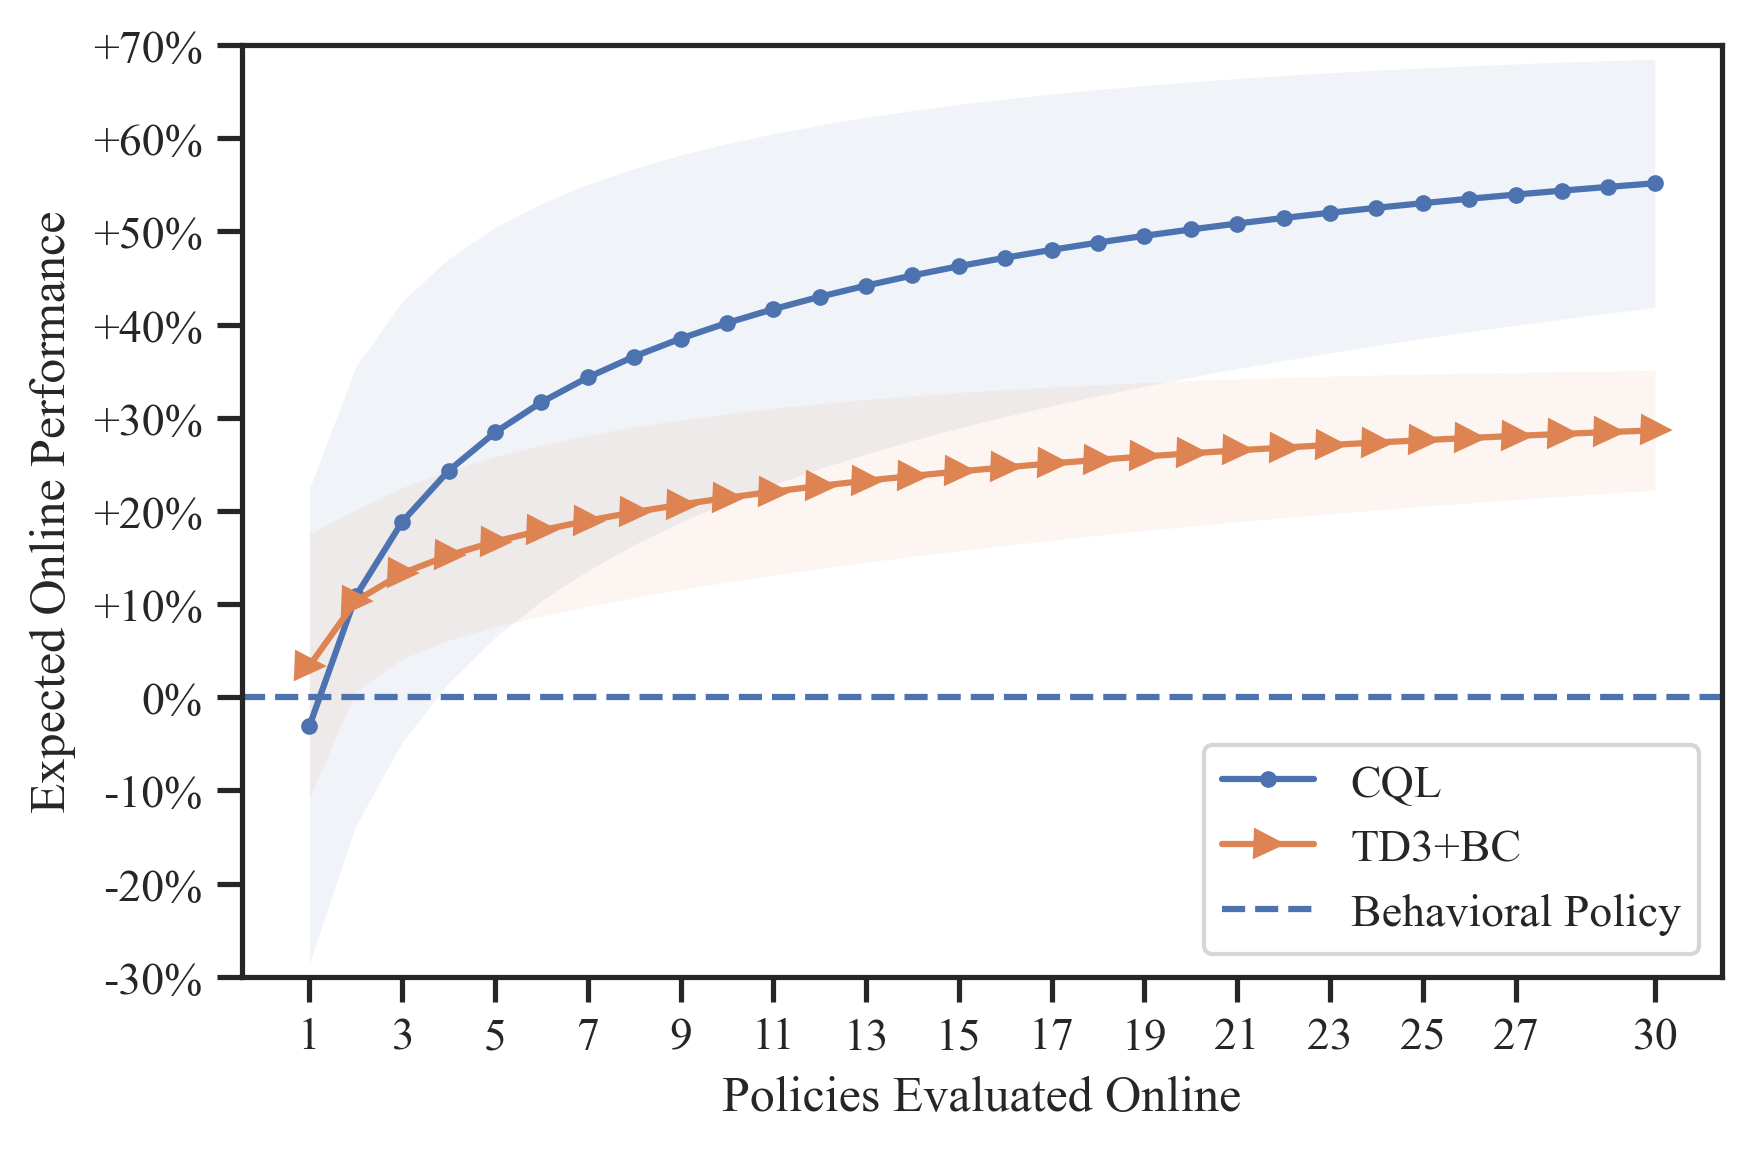

In [418]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

TARGET_TRIALS = 30
def cur_mask():
    return (all_experiments.ops_name == "uniform") & (all_experiments.env == "finrl") & (all_experiments.alg.isin(["td3+bc", "cql"]))
explore_experiments = all_experiments[cur_mask()]

# Draw
h3_grid = explore_experiments.groupby(["alg", "eop_ind"]).agg({
    "eop_mean": "mean",
    "eop_std": "mean",
    "eop_max": "max",
    "eop_min": "min"
})
# to set default values
marker         = cycle(('.', '>', 'X', 'o', '*')) 
linewidth      = 1.5
errorbar_kind  = "shade"
errorbar_alpha = 0.08
fontsize       = 12

_, cur_ax = plt.subplots(1,1)
cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

for n_trajectories, datapoints in h3_grid.groupby(["alg"]):
    means = datapoints["eop_mean"][:TARGET_TRIALS]
    vars  = datapoints["eop_std"][:TARGET_TRIALS]
    max_acc = max(datapoints["eop_max"])
    min_acc = min(datapoints["eop_min"])
    x_axis = [i+1 for i in range(len(means))]
    if True:
        if errorbar_kind == 'shade':
            minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
            plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
            plt.fill_between(x_axis,
                             minus_vars,
                             plus_vars,
                             alpha=errorbar_alpha)
        else:
            cur_ax.errorbar(x_axis,
                            means,
                            yerr=vars,
                            linestyle=linestyle,
                            linewidth=linewidth)
#     if n_trajectories == "uniform":
#         linewidth = 1.5
#         linestyle = "--"
#     else:
#         linewidth = 1.5
#         linestyle = "-"
    cur_ax.plot(x_axis,
                means,
                marker=next(marker),
                linewidth=linewidth,
                label=str.upper(f"{n_trajectories}")
               )

left, right = cur_ax.get_xlim()

# Draw baseline performance
plt.axhline(1.0, linestyle="dashed", linewidth=1.5, label="Behavioral Policy")

# Draw x axis
plt.xlim((left, right))
plt.xticks(list(range(1, TARGET_TRIALS + 1, 2))[:-1] + [30])

# Draw y axis (improvement percent?)
from math import floor
def improvement_ticks(y, pos):
    improvement = floor((y - 1.0) * 100)
    if improvement > 0:
        return f"+{improvement}%"
    else:
        return f"{improvement}%"
plt.ylim((0.7, 1.70))
cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

plt.locator_params(axis='y', nbins=10)
plt.tight_layout()
plt.legend(loc="lower right")
plt.savefig("finrl_td3_cql_uniform.pdf")
plt.show()

### BC can improve over the baseline 

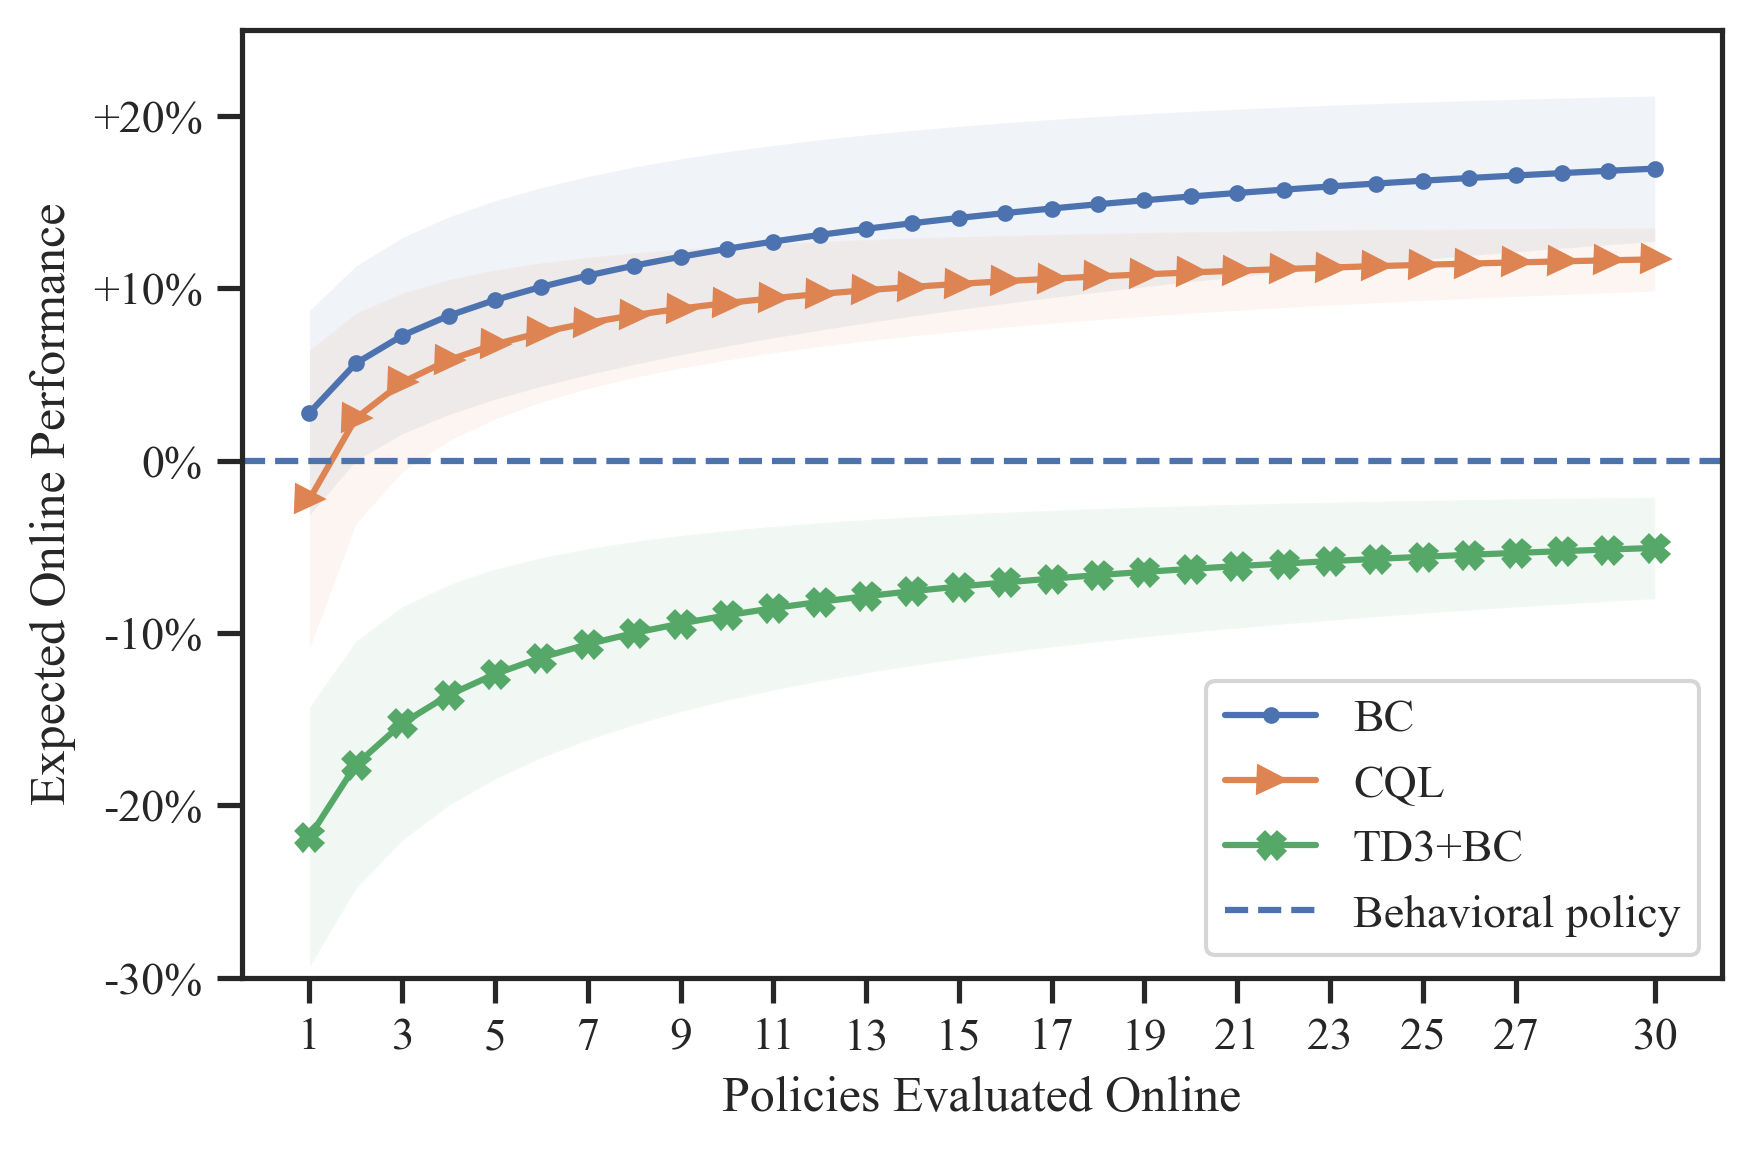

In [419]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

TARGET_TRIALS = 30
cur_mask = (all_experiments.ops_name == "uniform") & (all_experiments.env == "citylearn") & (all_experiments.alg.isin(["cql", "td3+bc", "bc"]))
explore_experiments = all_experiments[cur_mask]

# Draw
h3_grid = explore_experiments.groupby(["alg", "eop_ind"]).agg({
    "eop_mean": "mean",
    "eop_std": "mean",
    "eop_max": "max",
    "eop_min": "min"
})
# to set default values
marker         = cycle(('.', '>', 'X', 'o', '*')) 
linewidth      = 1.5
errorbar_kind  = "shade"
errorbar_alpha = 0.08
fontsize       = 12

_, cur_ax = plt.subplots(1,1)
cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

for n_trajectories, datapoints in h3_grid.groupby(["alg"]):
    means = datapoints["eop_mean"][:TARGET_TRIALS]
    vars  = datapoints["eop_std"][:TARGET_TRIALS]
    max_acc = max(datapoints["eop_max"])
    min_acc = min(datapoints["eop_min"])
    x_axis = [i+1 for i in range(len(means))]
    if True:
        if errorbar_kind == 'shade':
            minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
            plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
            plt.fill_between(x_axis,
                             minus_vars,
                             plus_vars,
                             alpha=errorbar_alpha)
        else:
            cur_ax.errorbar(x_axis,
                            means,
                            yerr=vars,
                            linestyle=linestyle,
                            linewidth=linewidth)
#     if n_trajectories == "uniform":
#         linewidth = 1.5
#         linestyle = "--"
#     else:
#         linewidth = 1.5
#         linestyle = "-"
    cur_ax.plot(x_axis,
                means,
                marker=next(marker),
                linewidth=linewidth,
                label=str.upper(f"{n_trajectories}")
               )

left, right = cur_ax.get_xlim()

# Draw baseline performance
plt.axhline(1.0, linestyle="dashed", linewidth=1.5, label="Behavioral policy")

# Draw x axis
plt.xlim((left, right))
plt.xticks(list(range(1, TARGET_TRIALS + 1, 2))[:-1] + [30])

# Draw y axis (improvement percent?)
from math import floor
def improvement_ticks(y, pos):
    improvement = floor((y - 1.0) * 100)
    if improvement > 0:
        return f"+{improvement}%"
    else:
        return f"{improvement}%"
plt.ylim((0.7, 1.25))
cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

plt.locator_params(axis='y', nbins=10)
plt.tight_layout()
plt.legend(loc="lower right")
plt.savefig(f"citylearn_bc_td3_cql_bc.pdf")
plt.show()

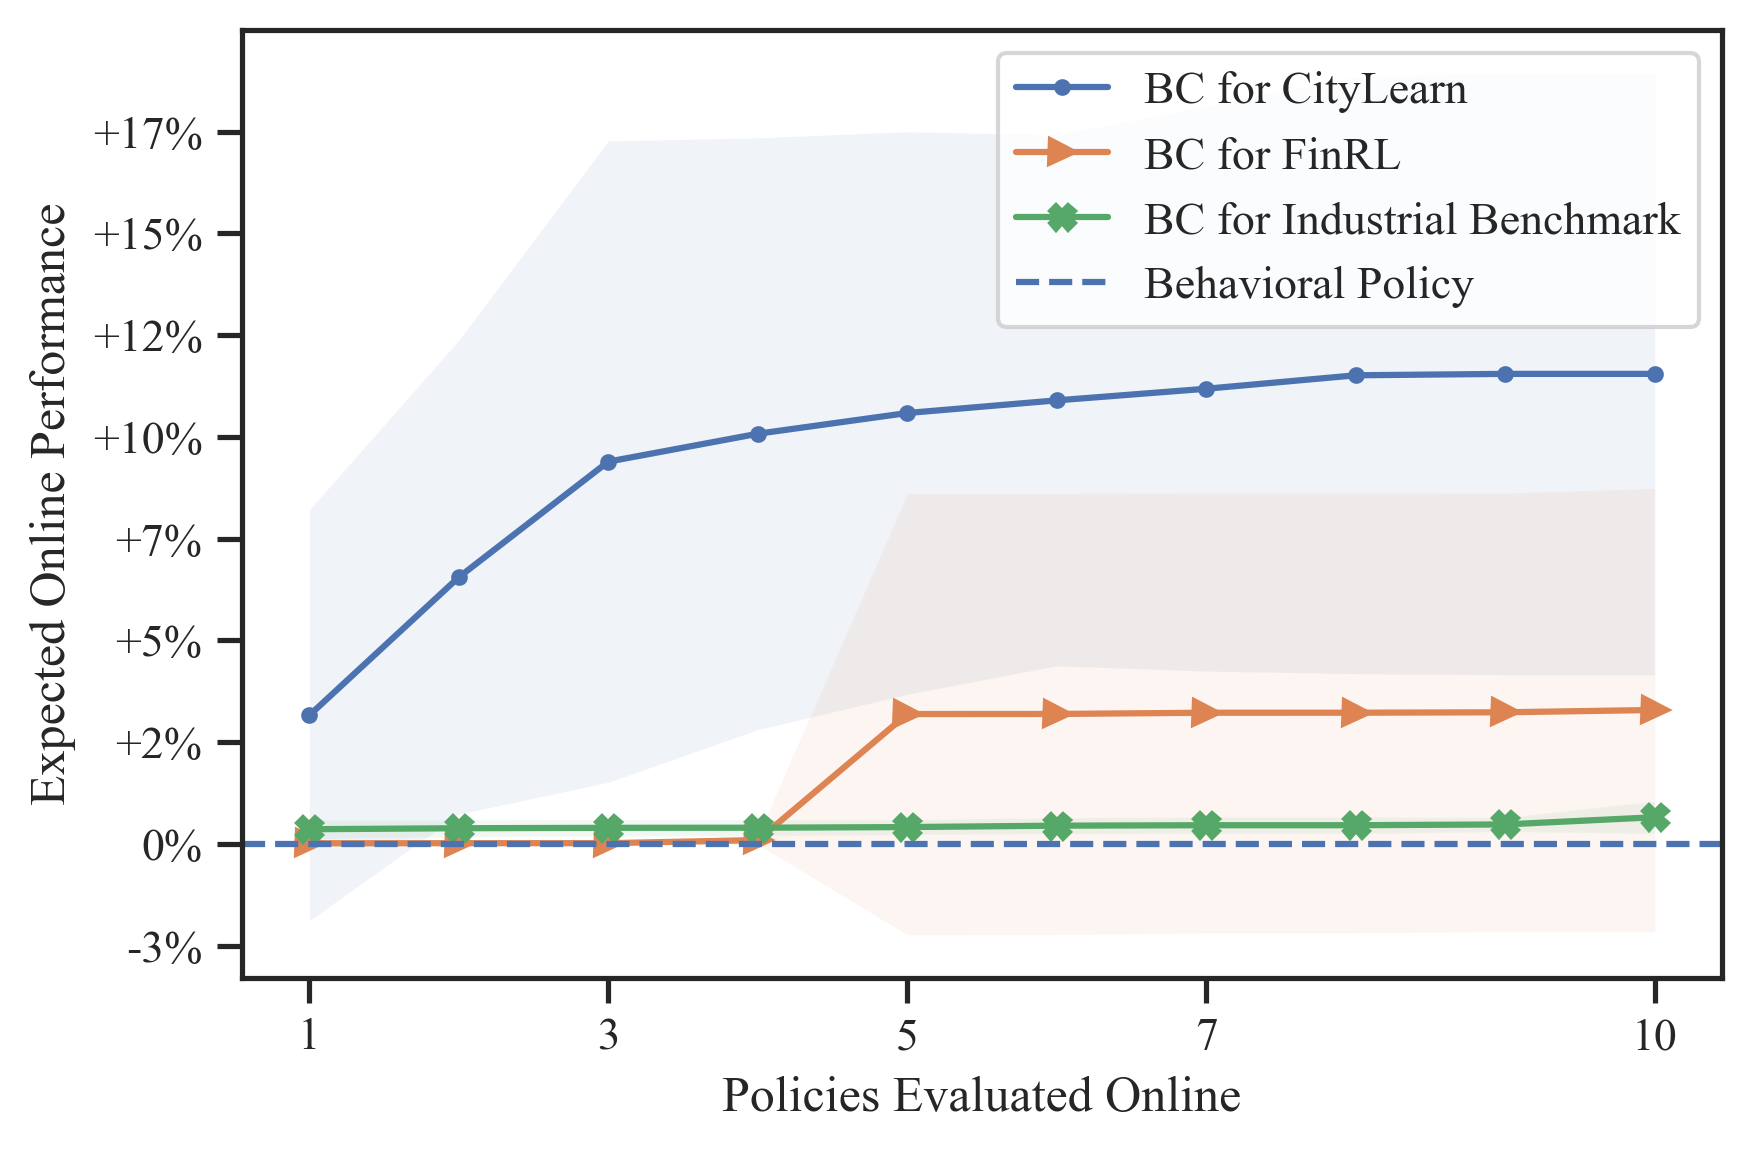

In [420]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

TARGET_TRIALS = 10
cur_mask = (all_experiments.ops_name == "val_loss") & (all_experiments.alg.isin(["bc"]))
explore_experiments = all_experiments[cur_mask]

# legend labels
labels = {
    "finrl": "BC for FinRL",
    "citylearn": "BC for CityLearn",
    "industrial": "BC for Industrial Benchmark"
}

# Draw
h3_grid = explore_experiments.groupby(["env", "eop_ind"]).agg({
    "eop_mean": "mean",
    "eop_std": "mean",
    "eop_max": "max",
    "eop_min": "min"
})
# to set default values
marker         = cycle(('.', '>', 'X', 'o', '*')) 
linewidth      = 1.5
errorbar_kind  = "shade"
errorbar_alpha = 0.08
fontsize       = 12

_, cur_ax = plt.subplots(1,1)
cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

for n_trajectories, datapoints in h3_grid.groupby(["env"]):
    means = datapoints["eop_mean"][:TARGET_TRIALS]
    vars  = datapoints["eop_std"][:TARGET_TRIALS]
    max_acc = max(datapoints["eop_max"])
    min_acc = min(datapoints["eop_min"])
    x_axis = [i+1 for i in range(len(means))]
    if True:
        if errorbar_kind == 'shade':
            minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
            plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
            plt.fill_between(x_axis,
                             minus_vars,
                             plus_vars,
                             alpha=errorbar_alpha)
        else:
            cur_ax.errorbar(x_axis,
                            means,
                            yerr=vars,
                            linestyle=linestyle,
                            linewidth=linewidth)
#     if n_trajectories == "uniform":
#         linewidth = 1.5
#         linestyle = "--"
#     else:
#         linewidth = 1.5
#         linestyle = "-"
    cur_ax.plot(x_axis,
                means,
                marker=next(marker),
                linewidth=linewidth,
                label=labels[n_trajectories]
               )

left, right = cur_ax.get_xlim()

# Draw baseline performance
plt.axhline(1.0, linestyle="dashed", linewidth=1.5, label="Behavioral Policy")

# Draw x axis
plt.xlim((left, right))
plt.xticks(list(range(1, TARGET_TRIALS + 1, 2))[:-1] + [10])

# Draw y axis (improvement percent?)
from math import floor
def improvement_ticks(y, pos):
    improvement = floor((y - 1.0) * 100)
    if improvement > 0:
        return f"+{improvement}%"
    else:
        return f"{improvement}%"
# plt.ylim((0.7, 1.20))
cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

plt.locator_params(axis='y', nbins=10)
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig("bc_safe.pdf")
plt.show()

low 99


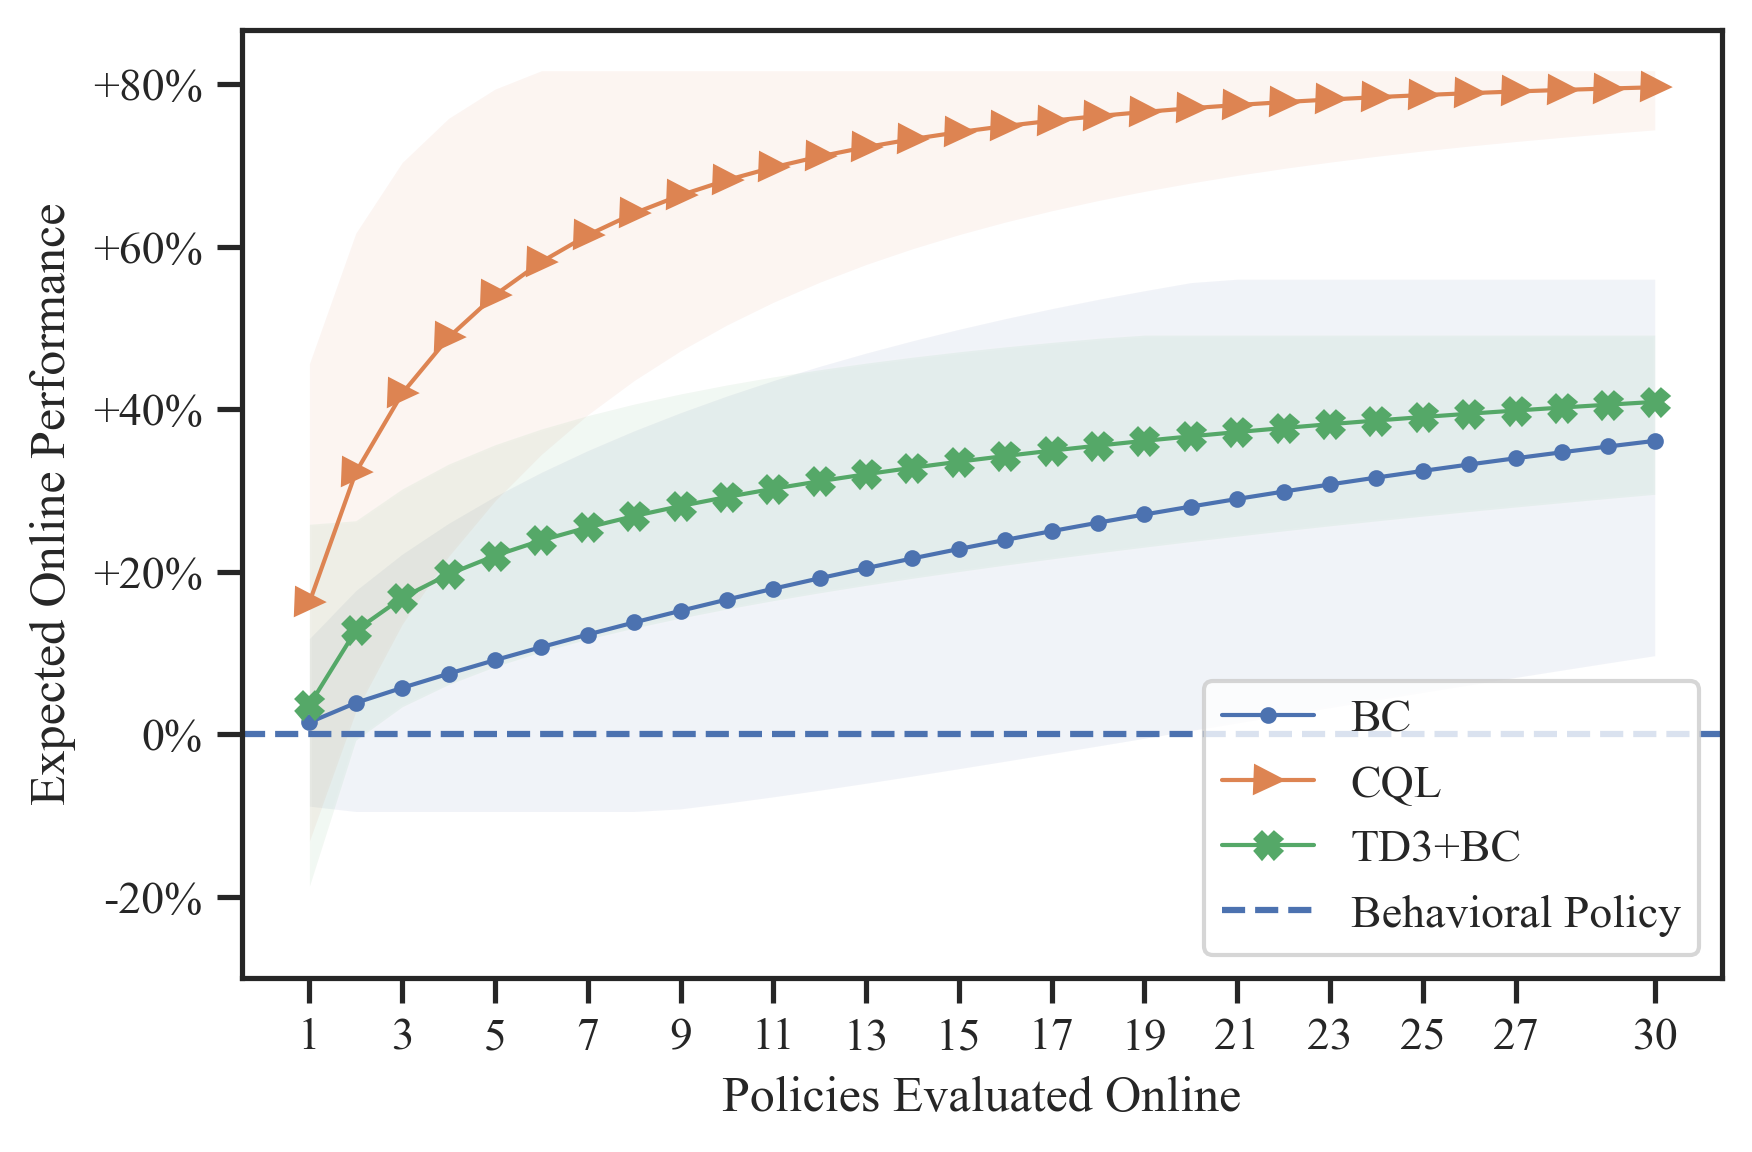

low 999


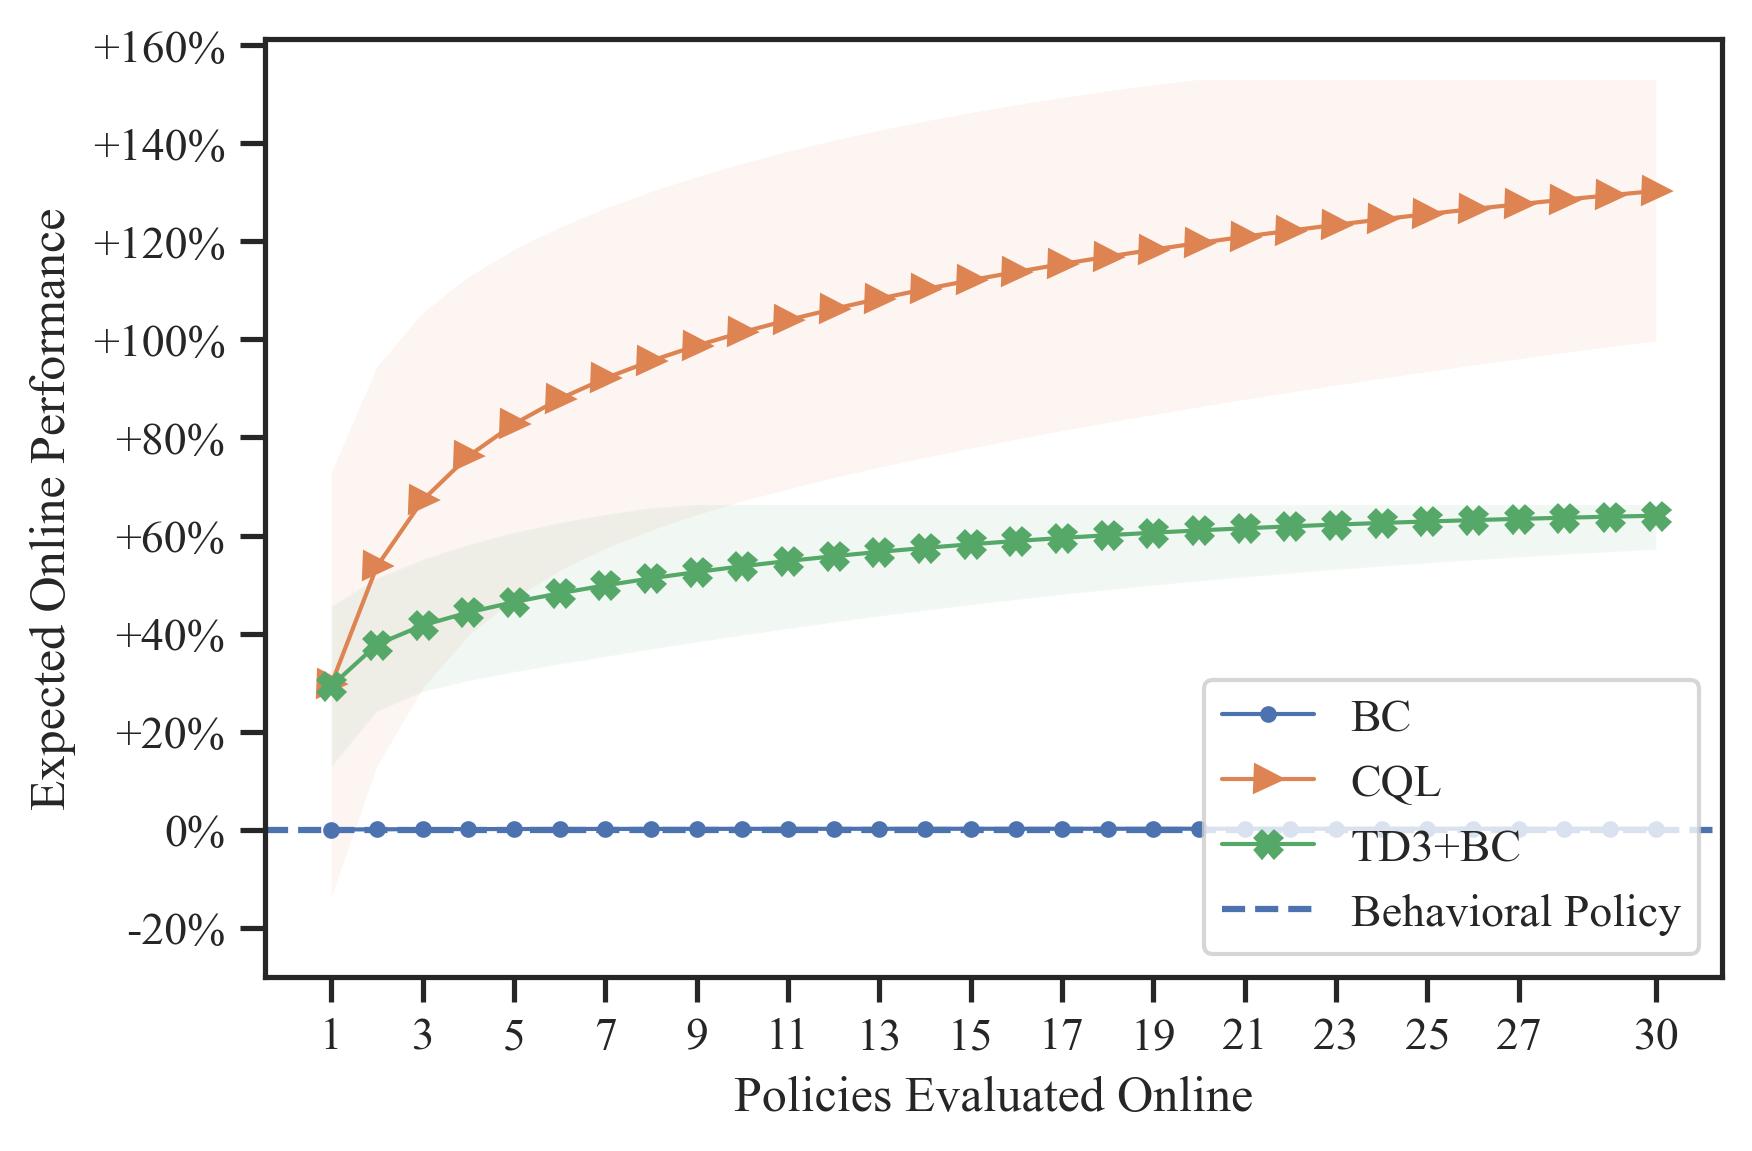

low 9999


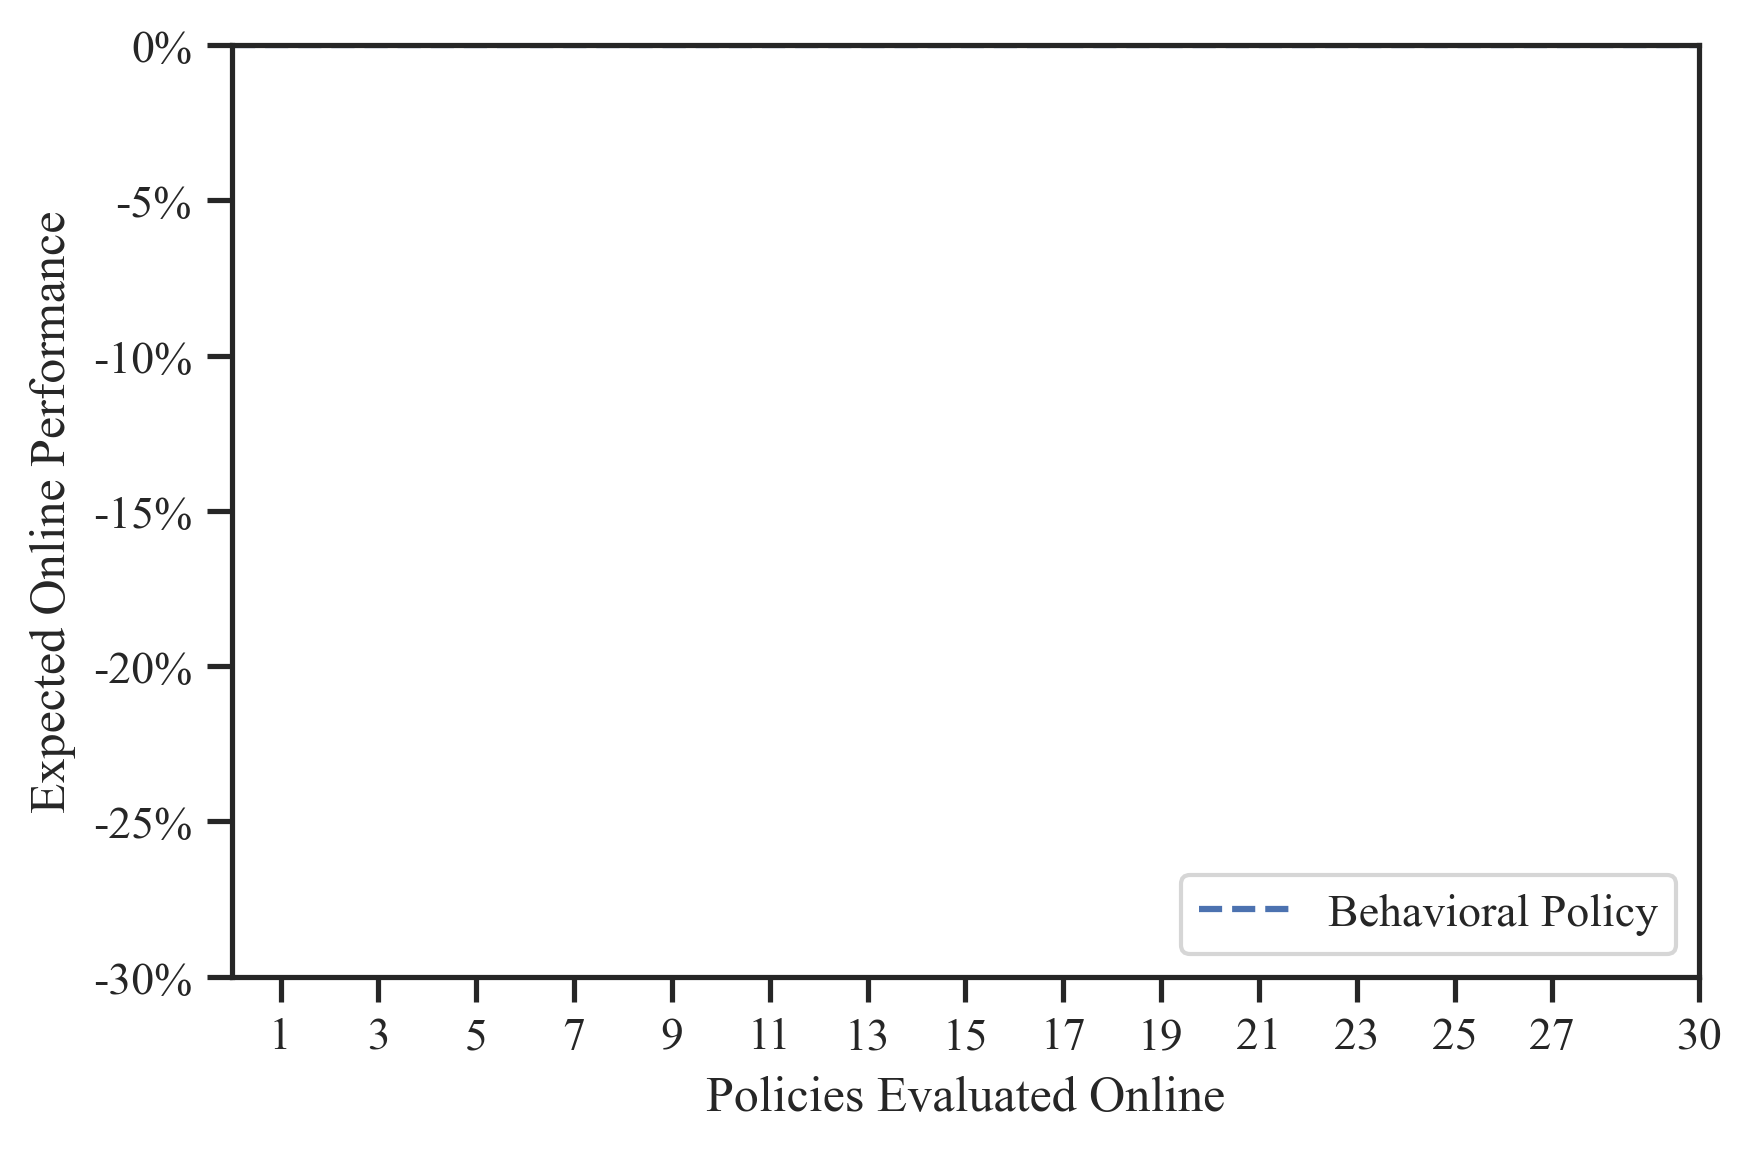

medium 99


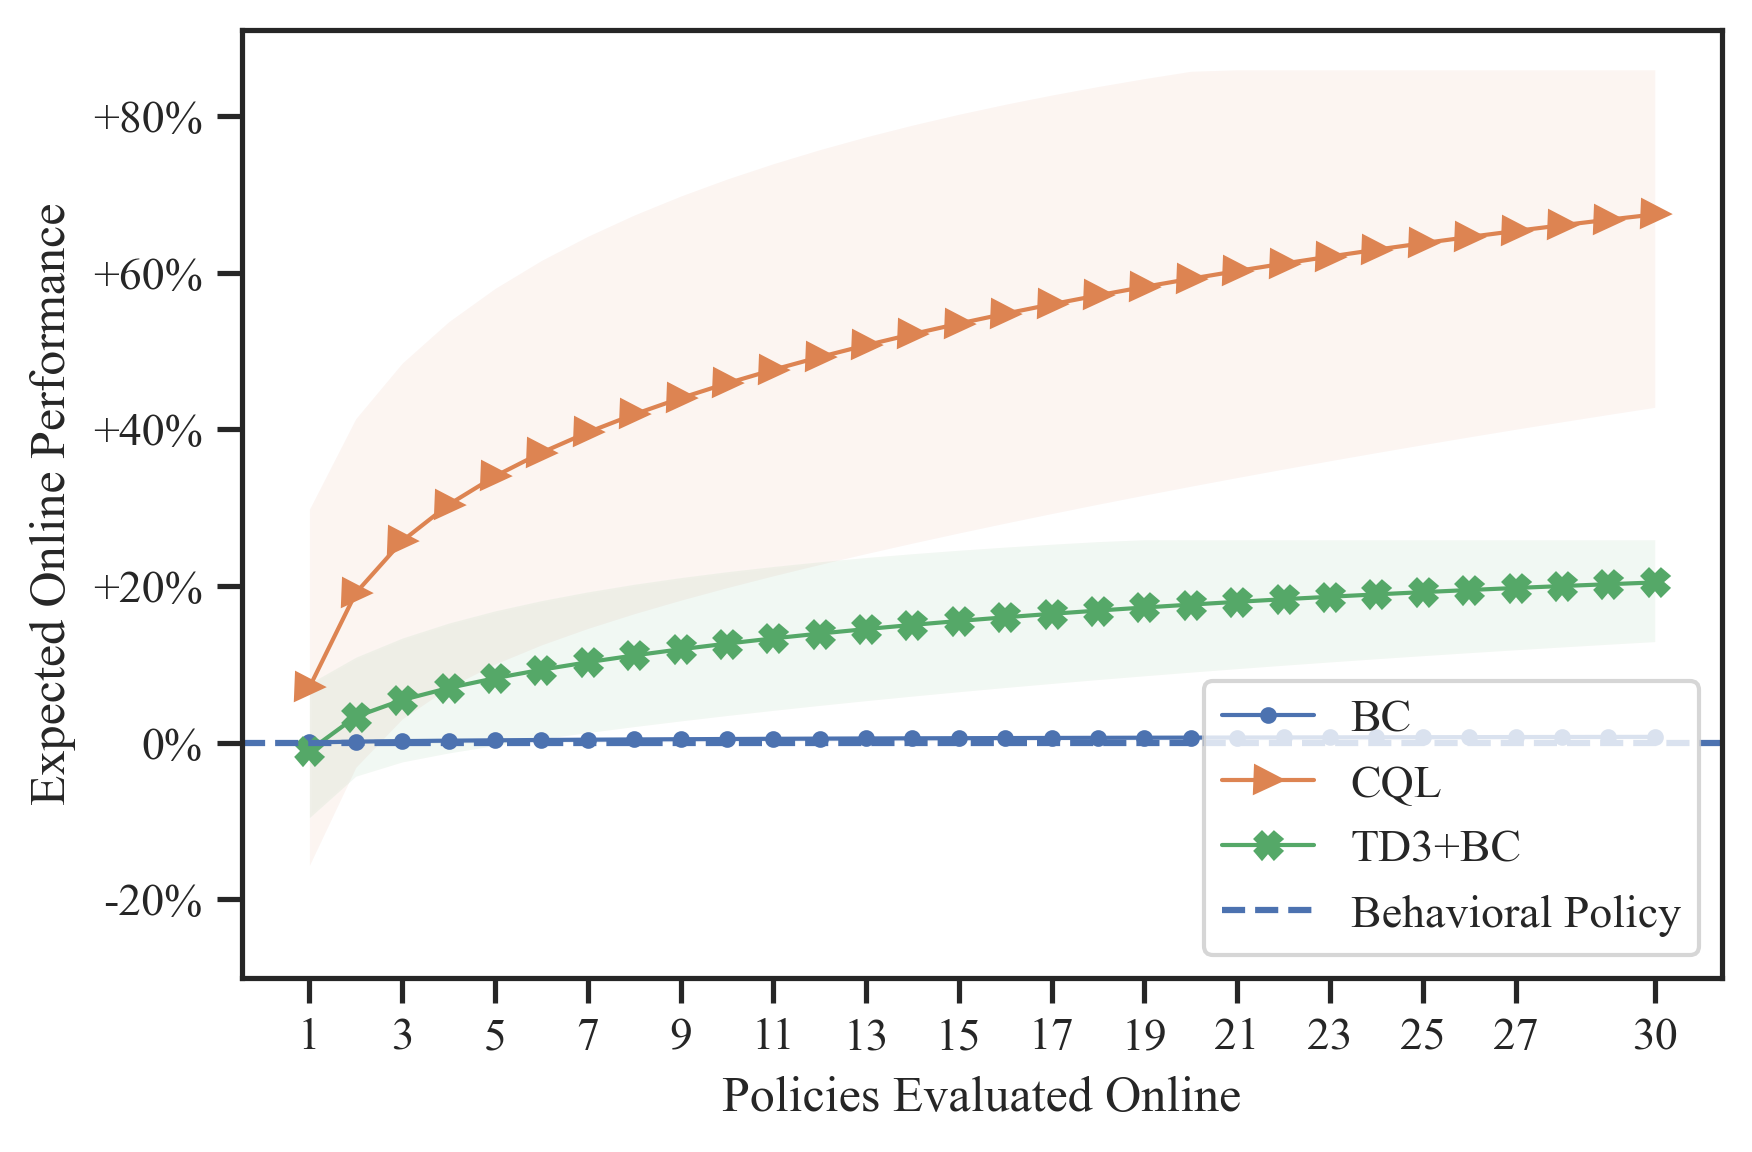

medium 999


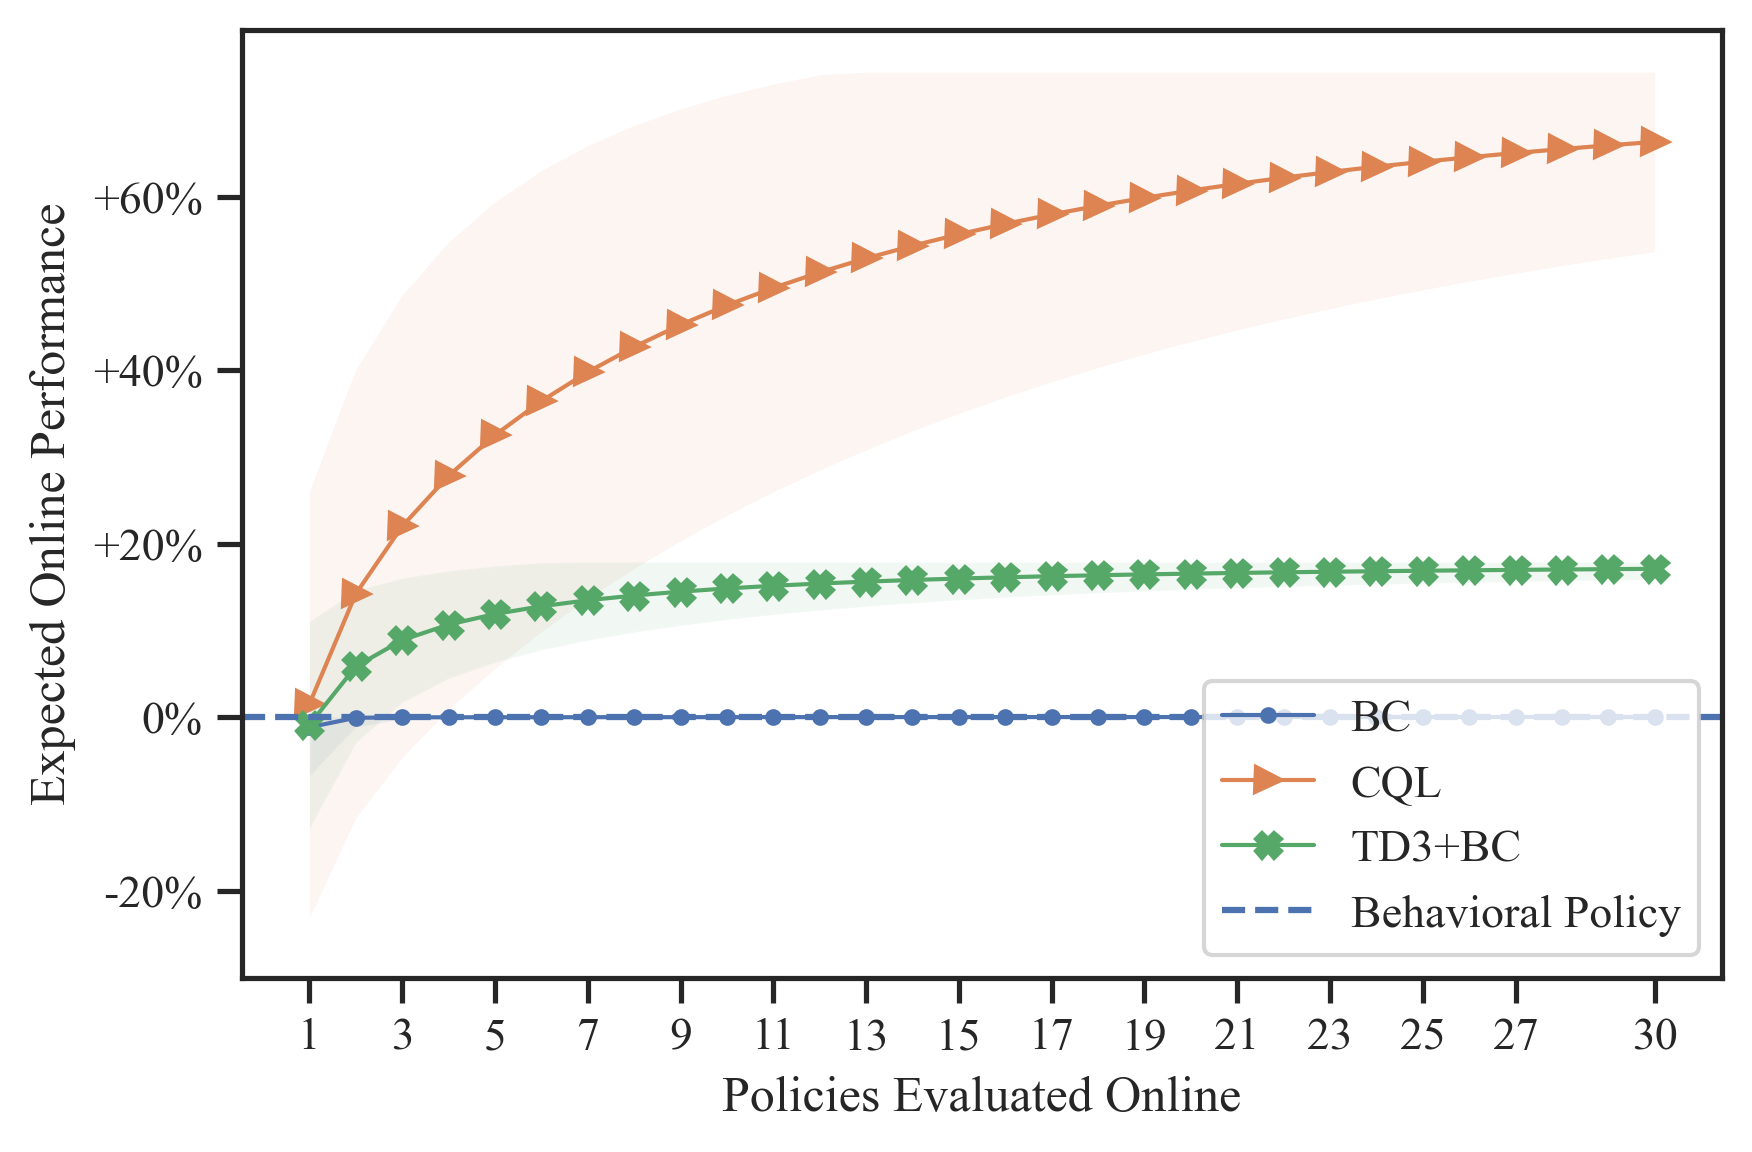

medium 9999


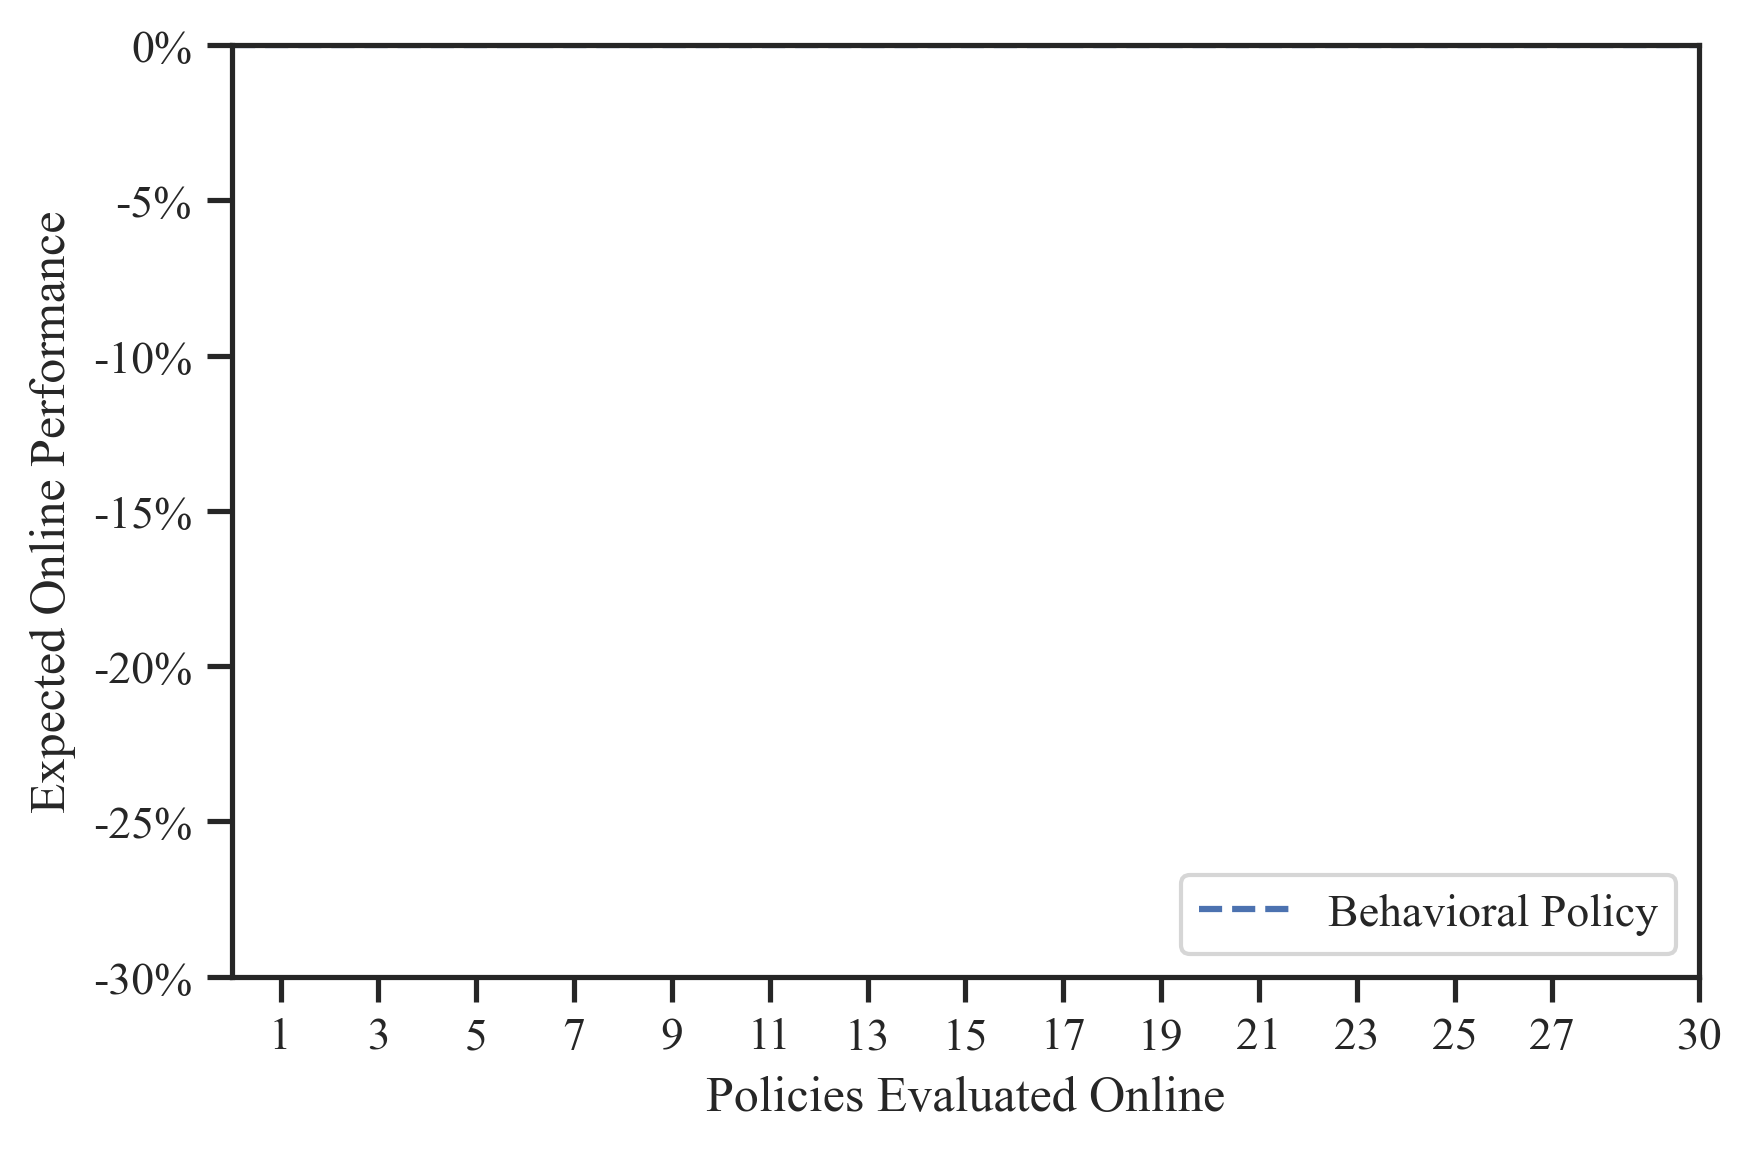

high 99


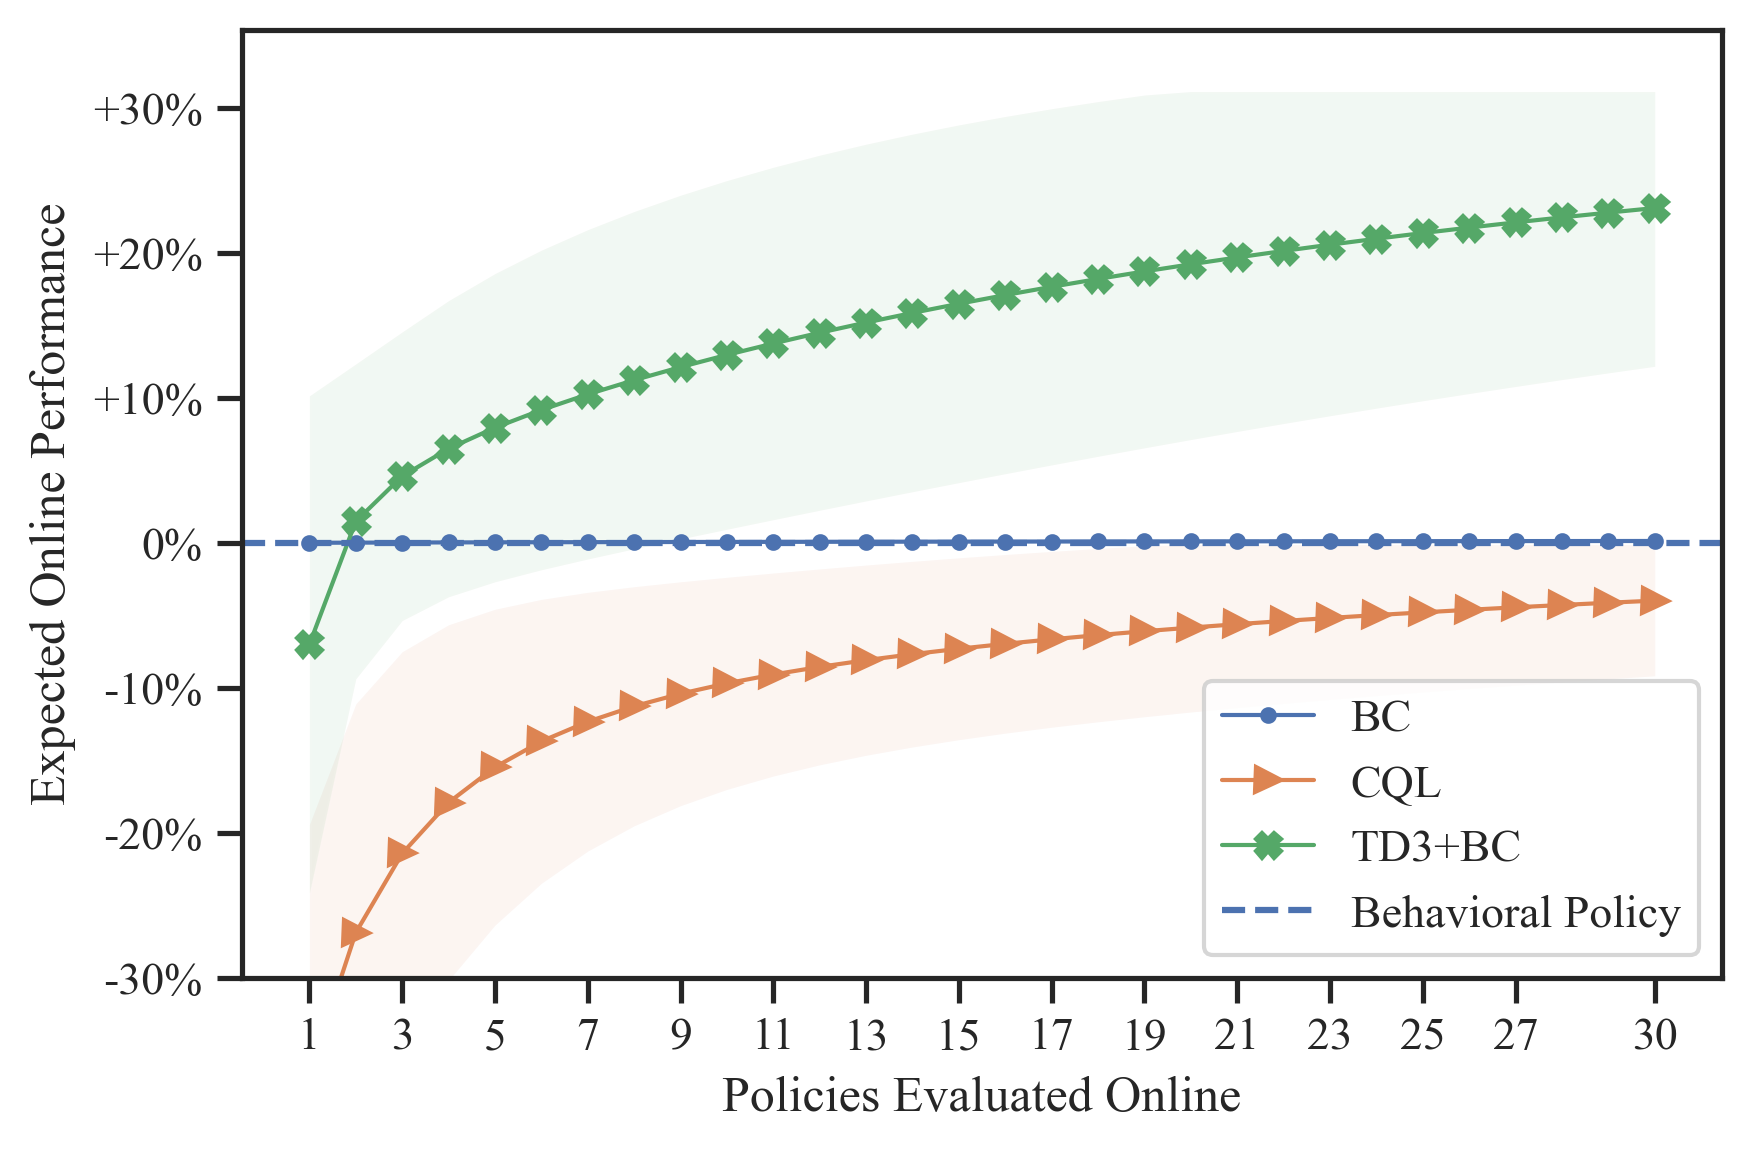

high 999


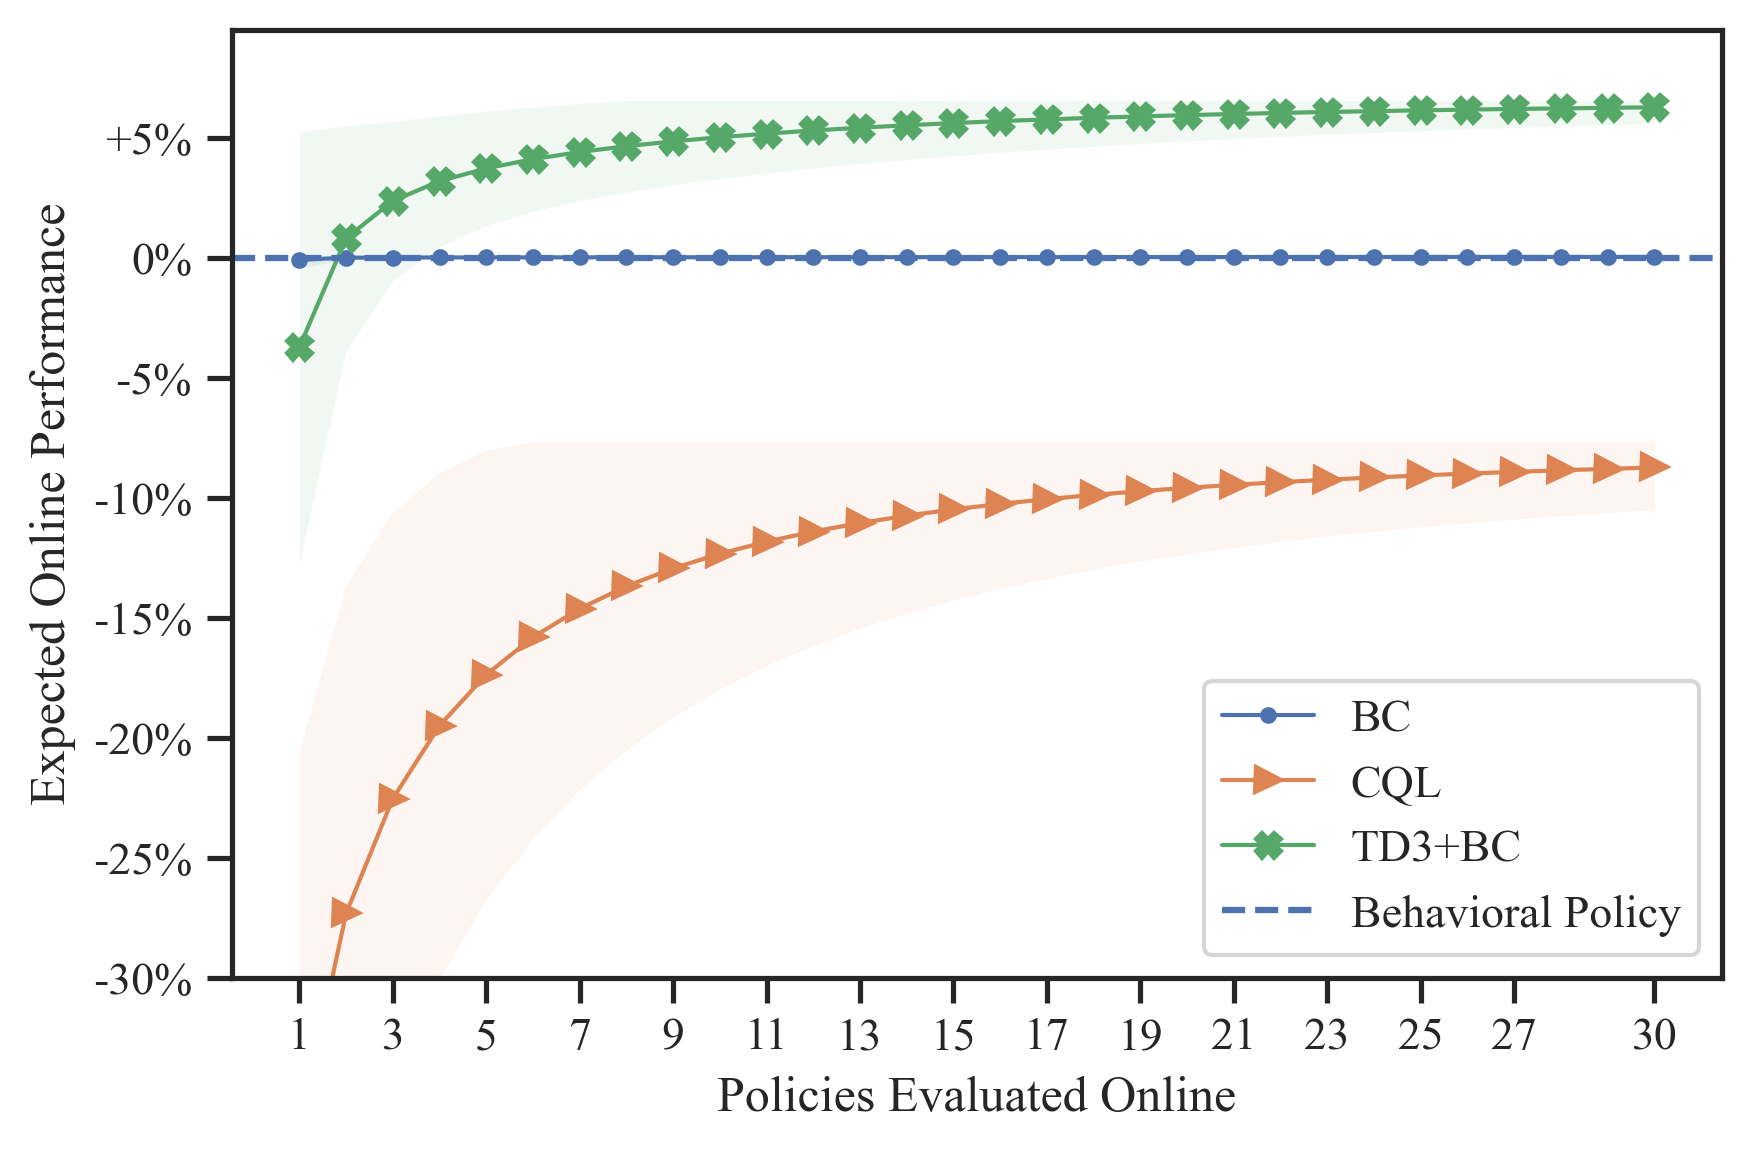

high 9999


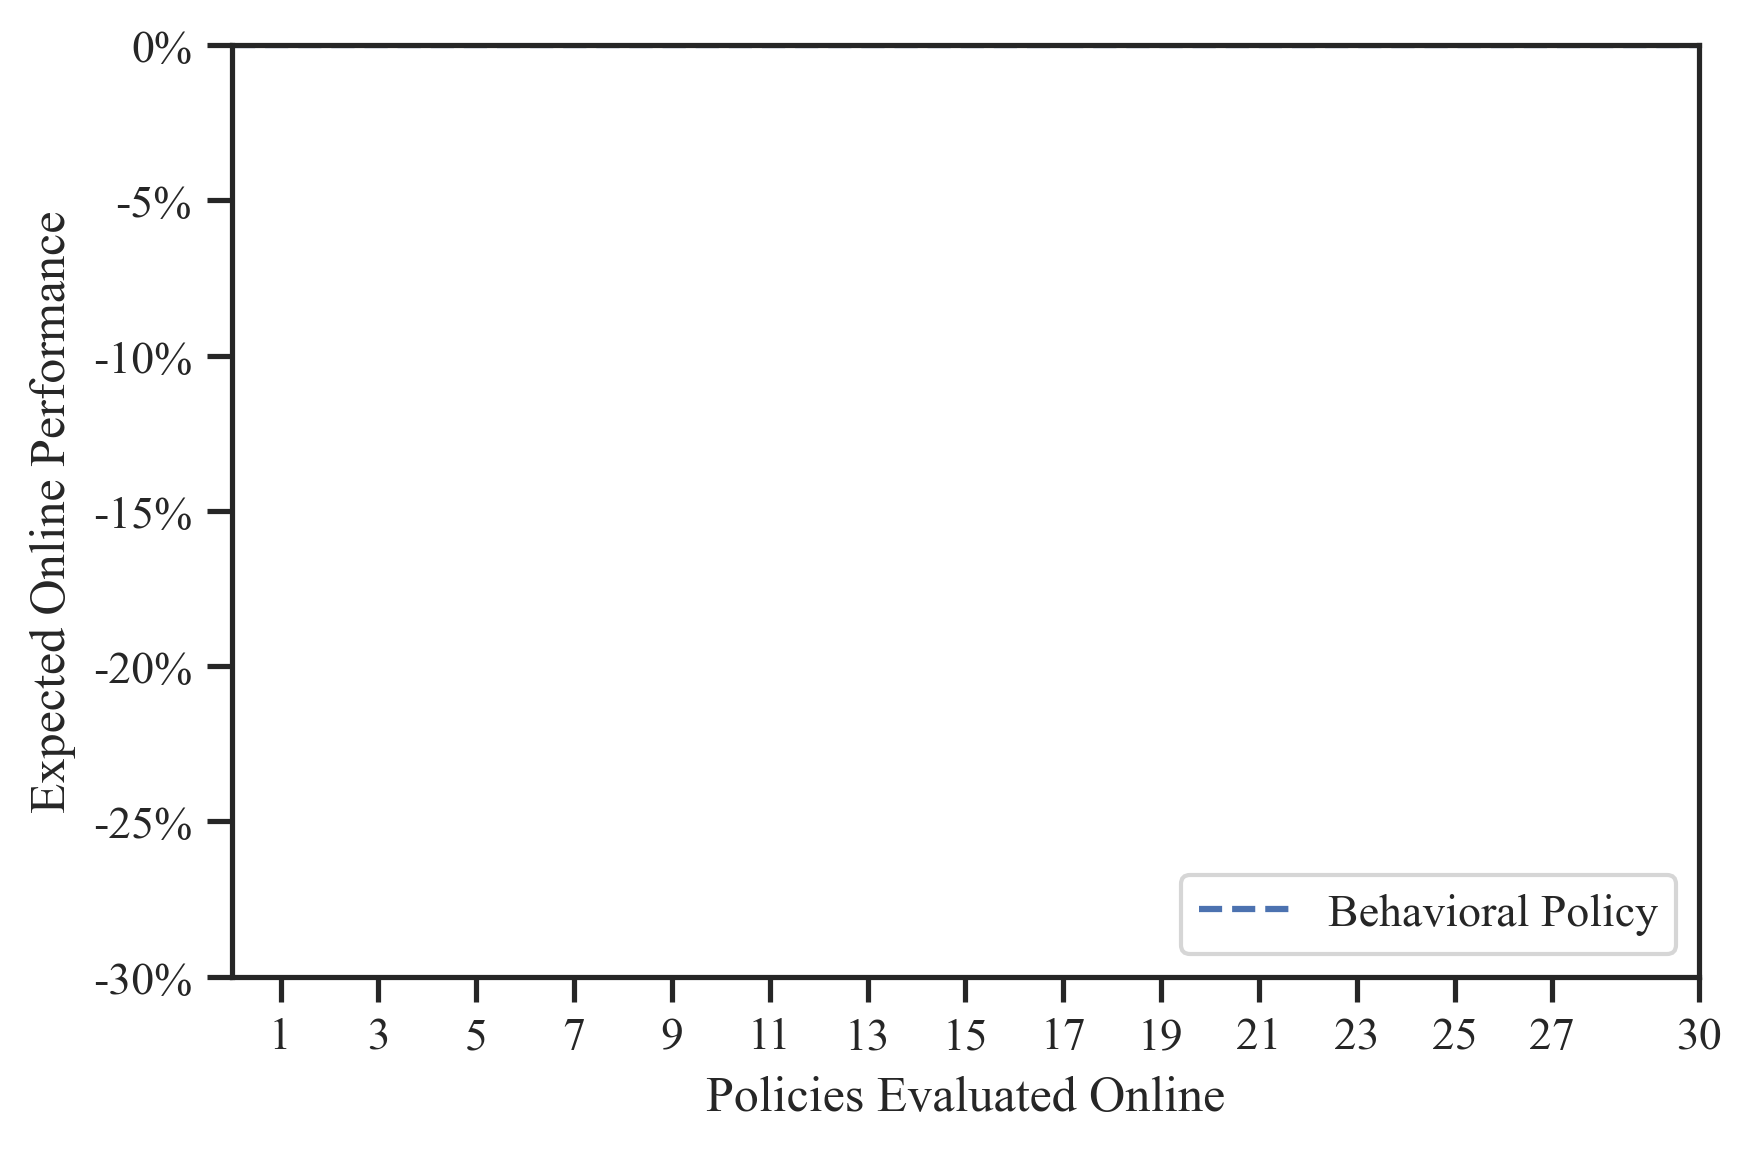

In [471]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

TARGET_TRIALS = 30
for levels, trajs in product(["low", "medium", "high"], [99, 999, 9999]):
    env = "finrl"
    cur_mask = (all_experiments.policy_level == levels) & (all_experiments.n_trajectories == trajs) & (all_experiments.ops_name == "uniform") & (all_experiments.env == env) & (all_experiments.alg.isin(["cql", "td3+bc", "bc"]))
    explore_experiments = all_experiments[cur_mask]

    # OPS Labels
    labels = {
        "uniform": "Uniform",
        "val_vs0_q": "$V(s_{0})$ using Critic",
        "val_vs0_fqe": "$V(s_{0})$ using FQE",
        "val_tderror": "TD-Error",
        "val_loss": "Action Difference",
    }

    # Draw
    h3_grid = explore_experiments.groupby(["alg", "eop_ind"]).agg({
        "eop_mean": "mean",
        "eop_std": "mean",
        "eop_max": "max",
        "eop_min": "min"
    })
    # to set default values
    marker         = cycle(('.', '>', 'X', 'o', '*')) 
    linewidth      = 1
    errorbar_kind  = "shade"
    errorbar_alpha = 0.08
    fontsize       = 12

    _, cur_ax = plt.subplots(1,1)
    cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
    cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

    for n_trajectories, datapoints in h3_grid.groupby(["alg"]):
        means = datapoints["eop_mean"][:TARGET_TRIALS]
        vars  = datapoints["eop_std"][:TARGET_TRIALS]
        max_acc = max(datapoints["eop_max"])
        min_acc = min(datapoints["eop_min"])
        x_axis = [i+1 for i in range(len(means))]
        if True:
            if errorbar_kind == 'shade':
                minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
                plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
                plt.fill_between(x_axis,
                                 minus_vars,
                                 plus_vars,
                                 alpha=errorbar_alpha)
            else:
                cur_ax.errorbar(x_axis,
                                means,
                                yerr=vars,
                                linestyle=linestyle,
                                linewidth=linewidth)
        cur_ax.plot(x_axis,
                    means,
                    marker=next(marker),
                    linewidth=linewidth,
                    label=f"{str.upper(n_trajectories)}"
                   )
        
        # NeoRL performance
#         if n_trajectories == "cql":
#             percent = get_neorl_percent(alg=n_trajectories, env=env, level=levels, traj=trajs)
#             plt.axhline(percent, linestyle="dashed", linewidth=2)

    left, right = cur_ax.get_xlim()

    # Draw baseline performance
    plt.axhline(1.0, linestyle="dashed", linewidth=1.5, label="Behavioral Policy")
    

    # Draw x axis
    plt.xlim((left, right))
    plt.ylim(bottom=0.7)
    plt.xticks(list(range(1, TARGET_TRIALS + 1, 2))[:-1] + [30])

    # Draw y axis (improvement percent?)
    from math import floor
    def improvement_ticks(y, pos):
        improvement = floor((y - 1.0) * 100)
        if improvement > 0:
            return f"+{improvement}%"
        else:
            return f"{improvement}%"
#     plt.ylim((0.7, 1.60))
    cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

    plt.locator_params(axis='y', nbins=10)
    plt.tight_layout()
    plt.legend(loc="lower right")
#     plt.savefig(f"{env}_{trajs}_{levels}_uniform.pdf")
    print(levels, trajs)
    plt.show()

### for other selection methods

low 9999


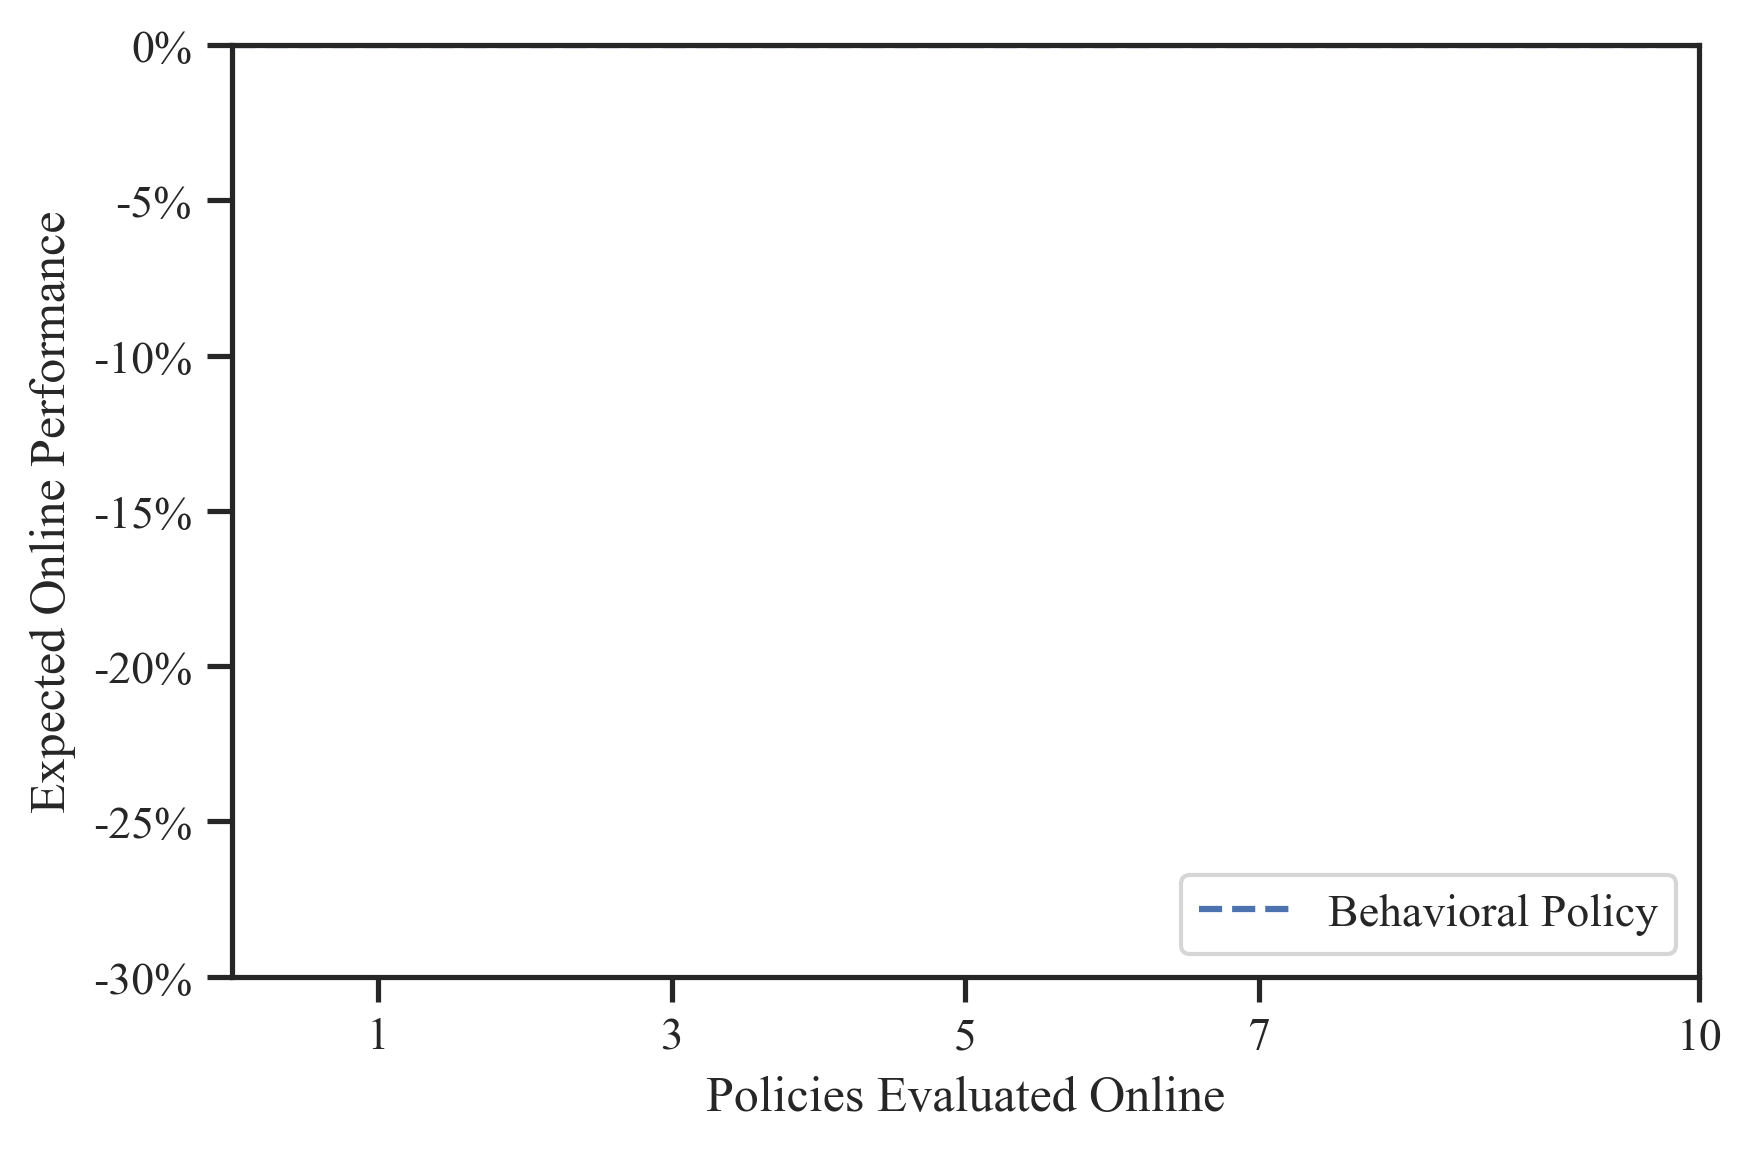

low 999


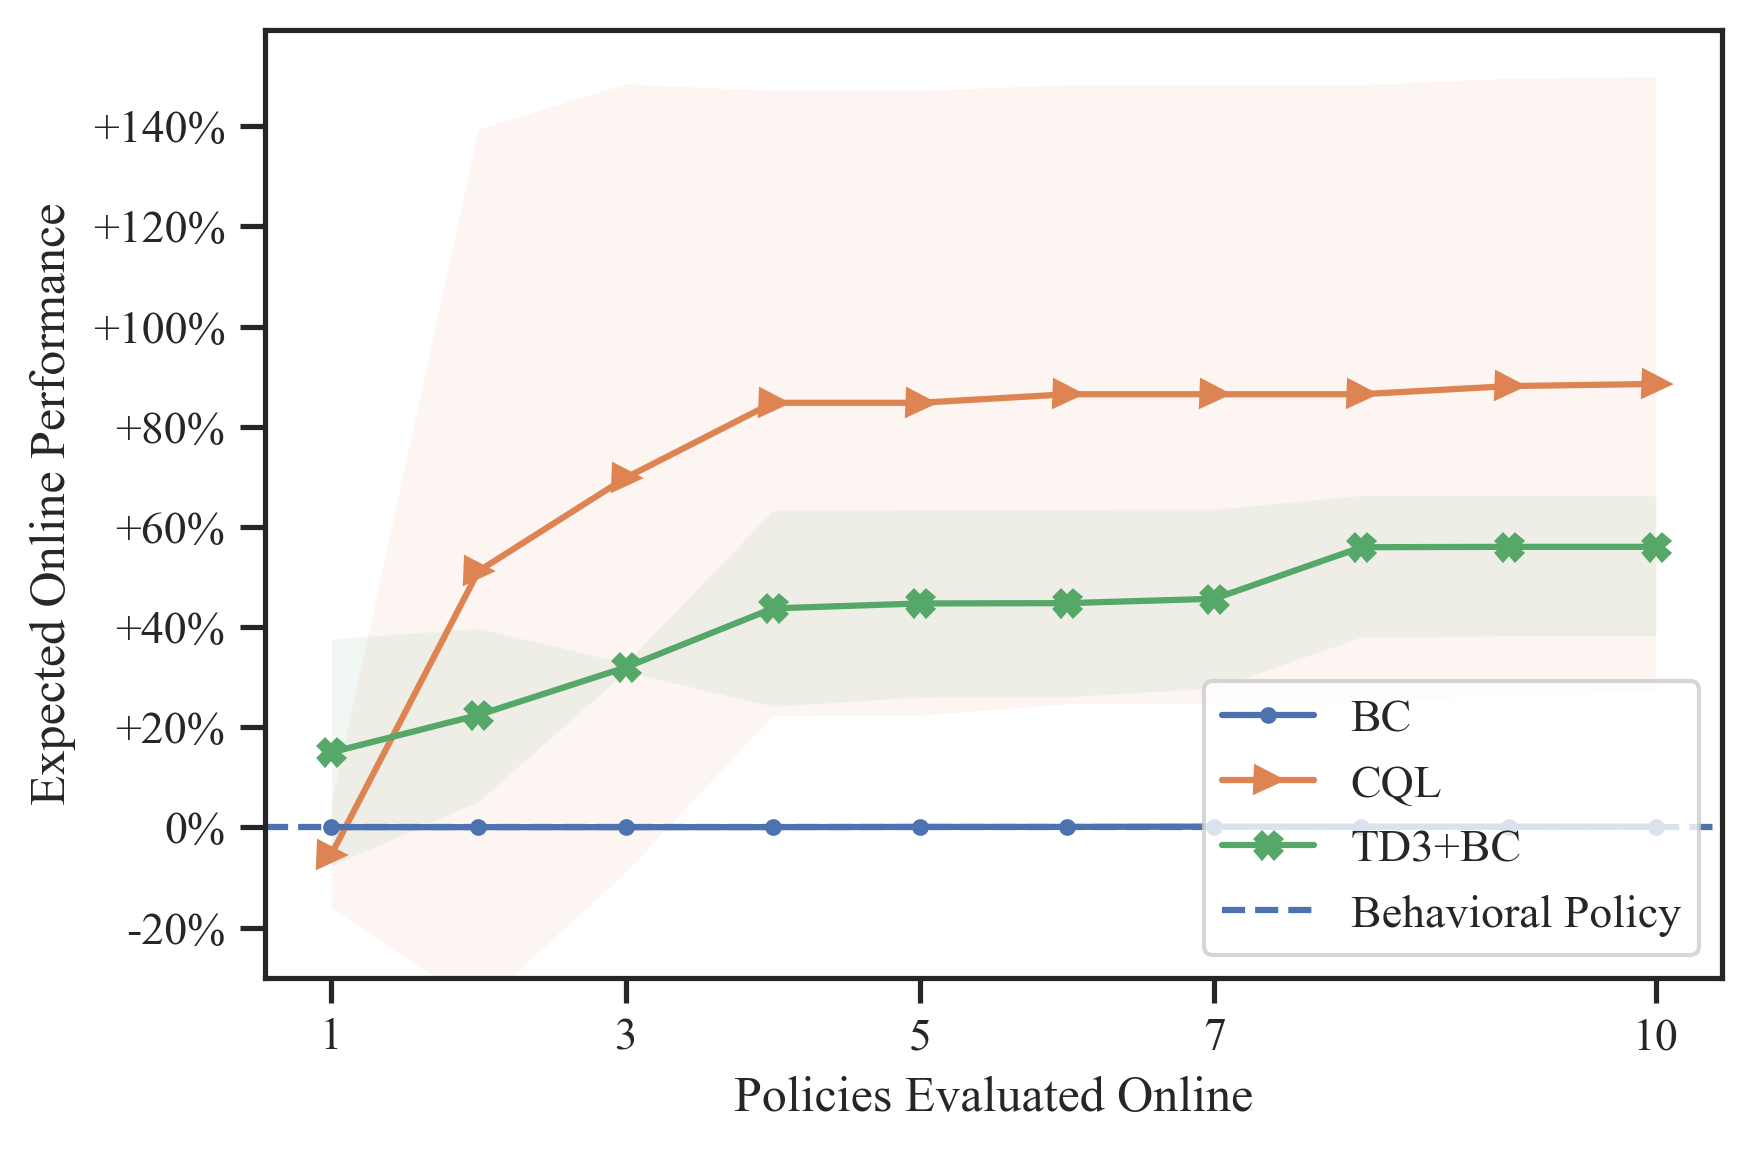

low 99


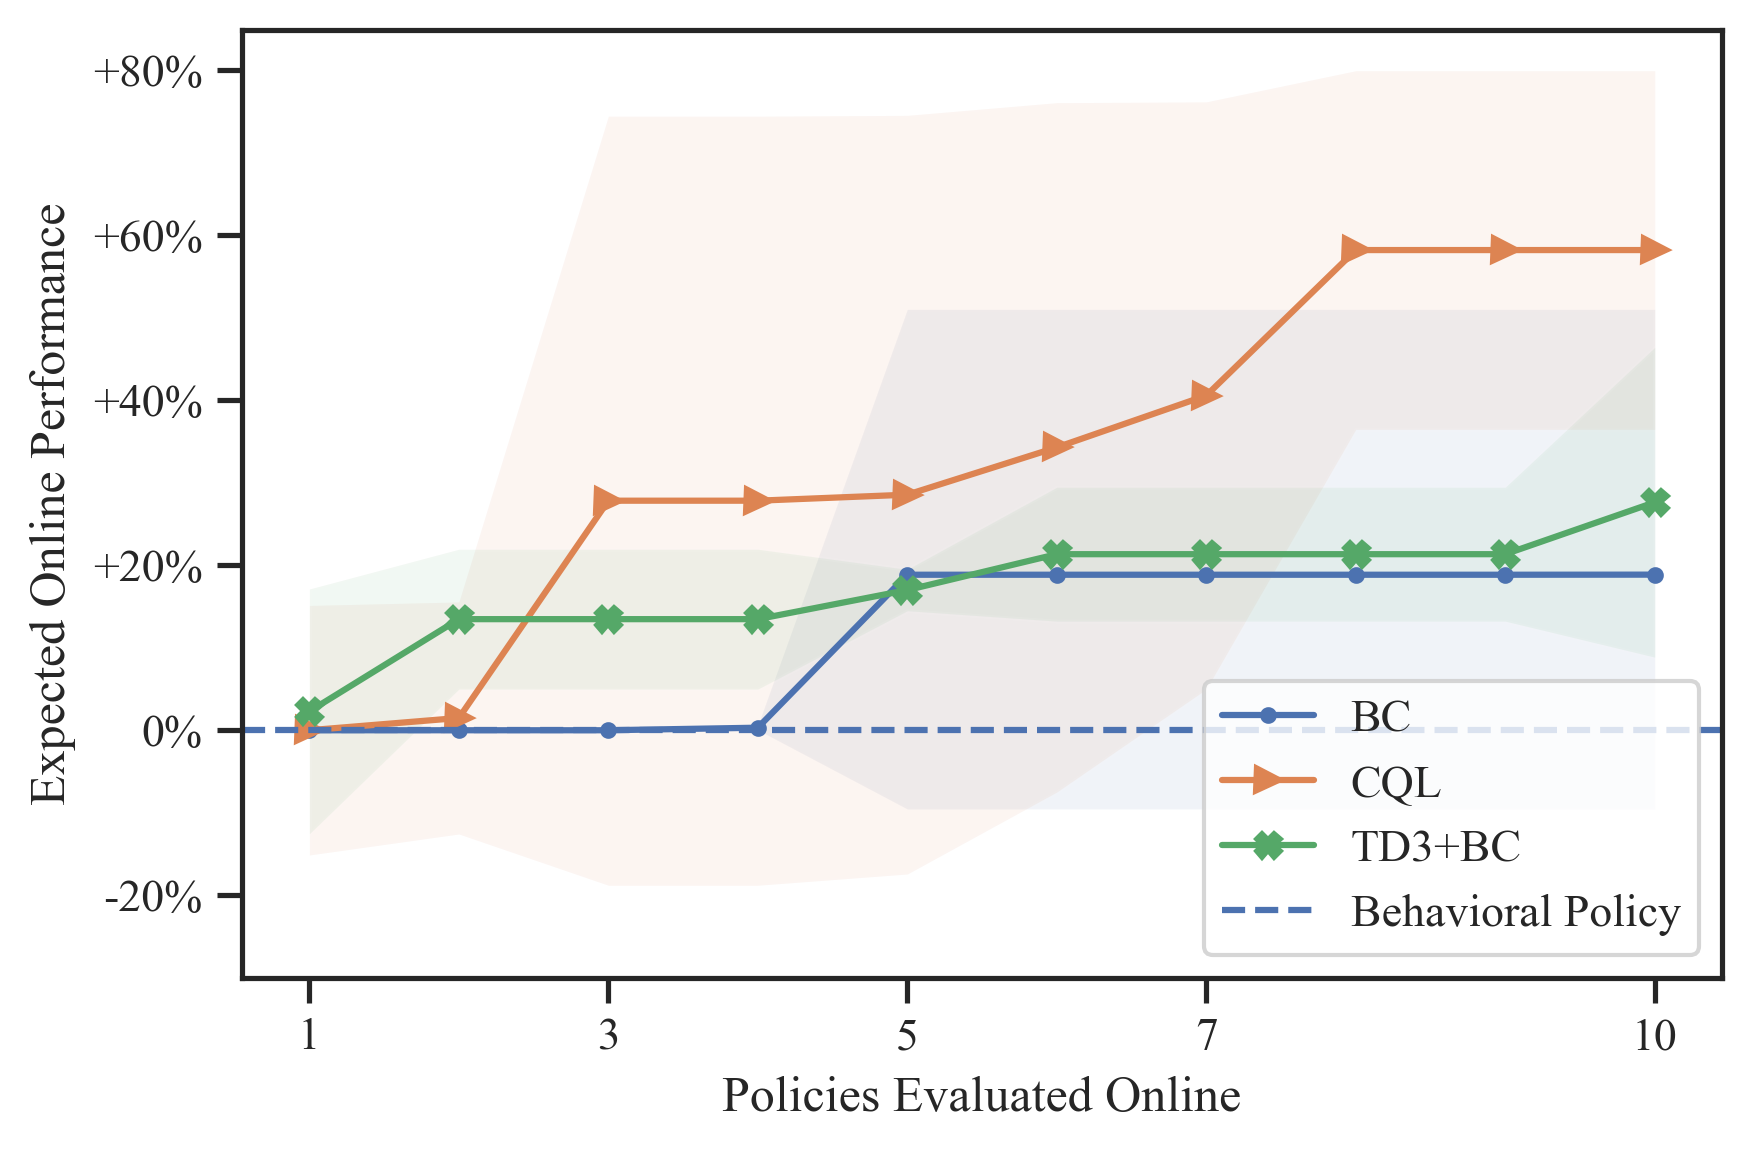

medium 9999


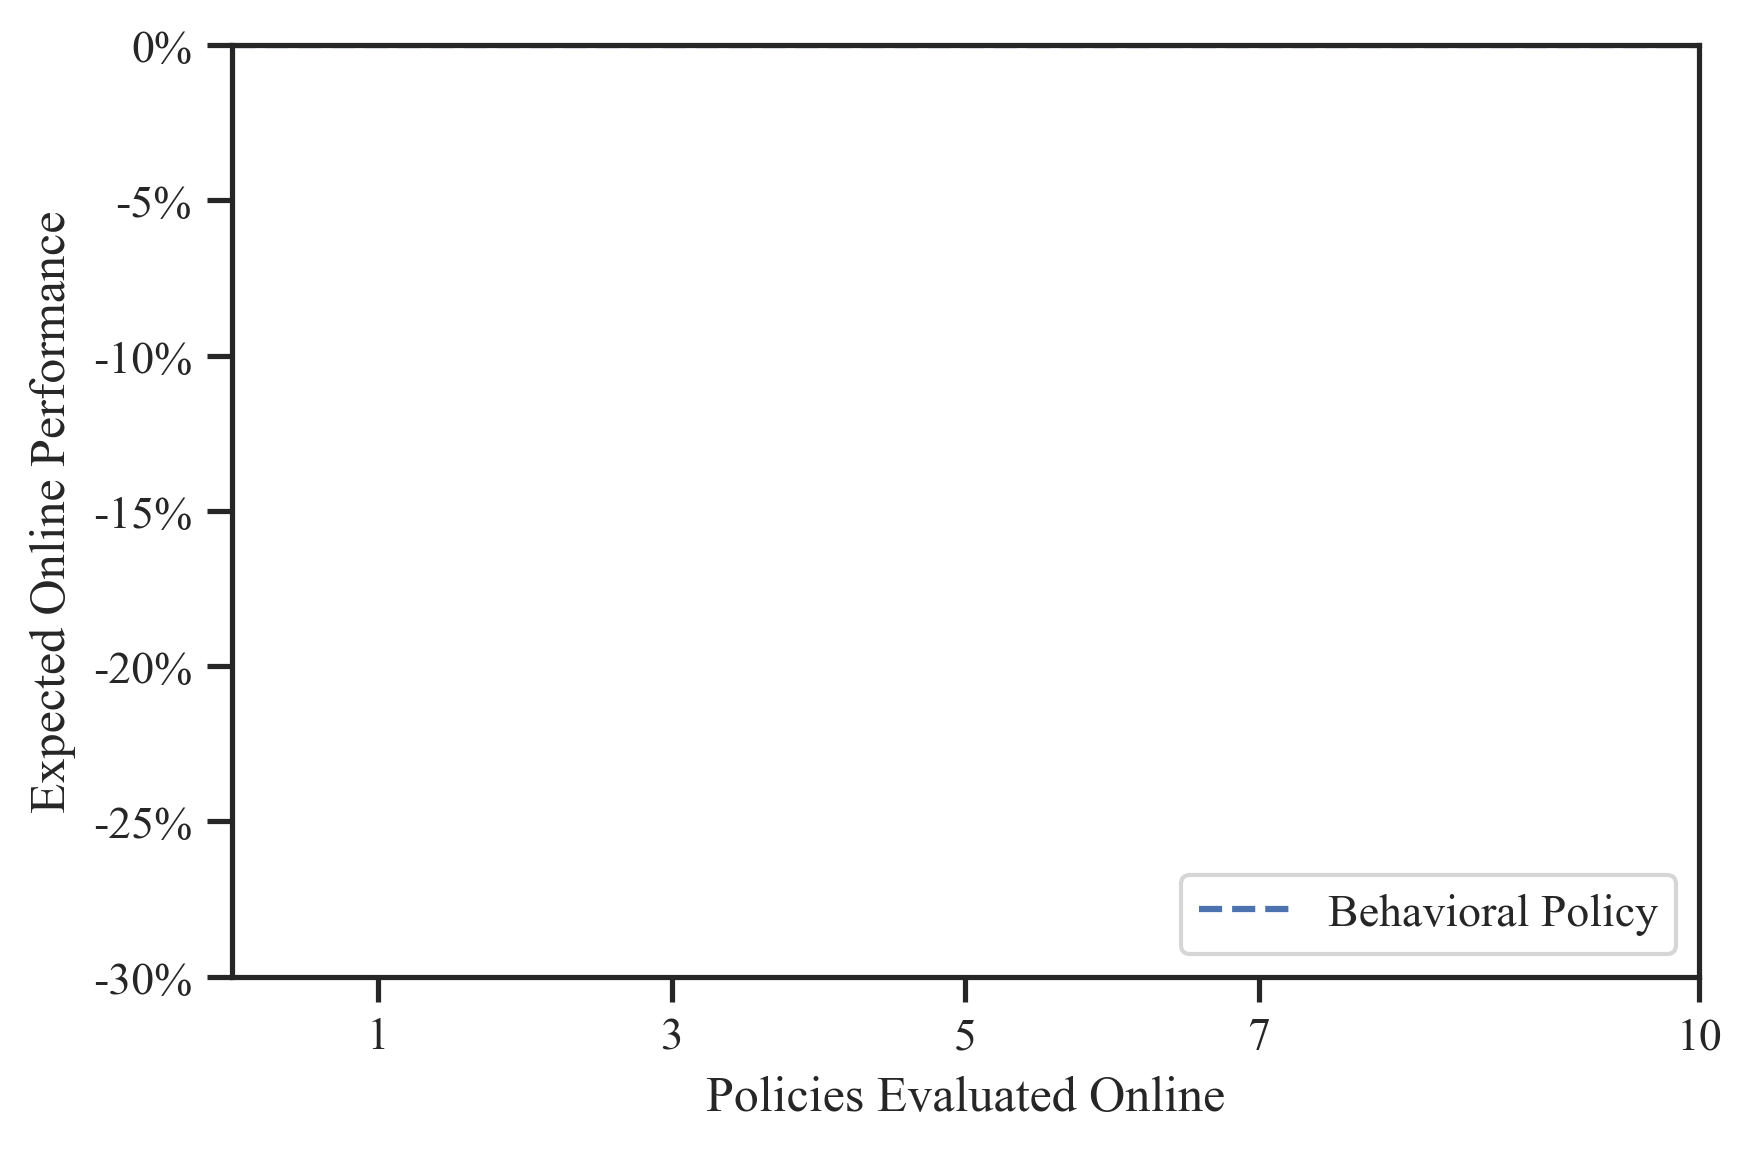

medium 999


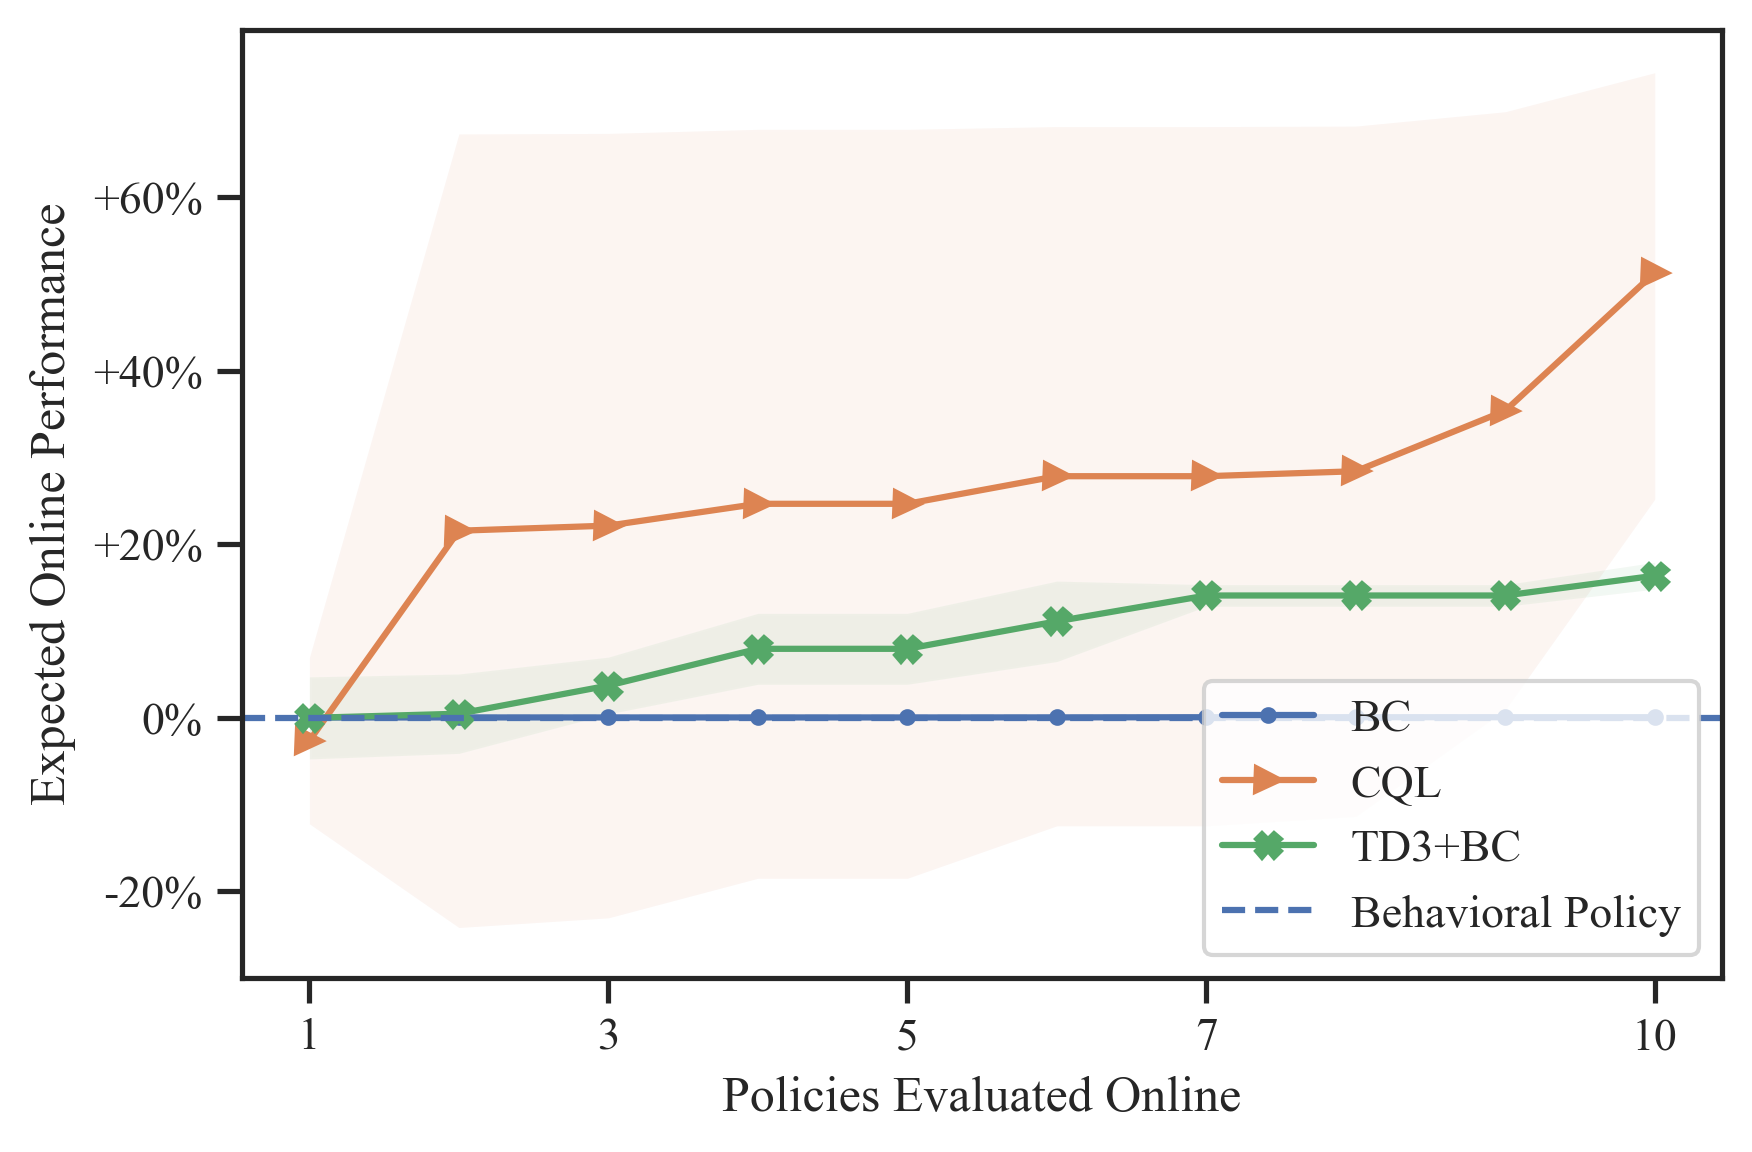

medium 99


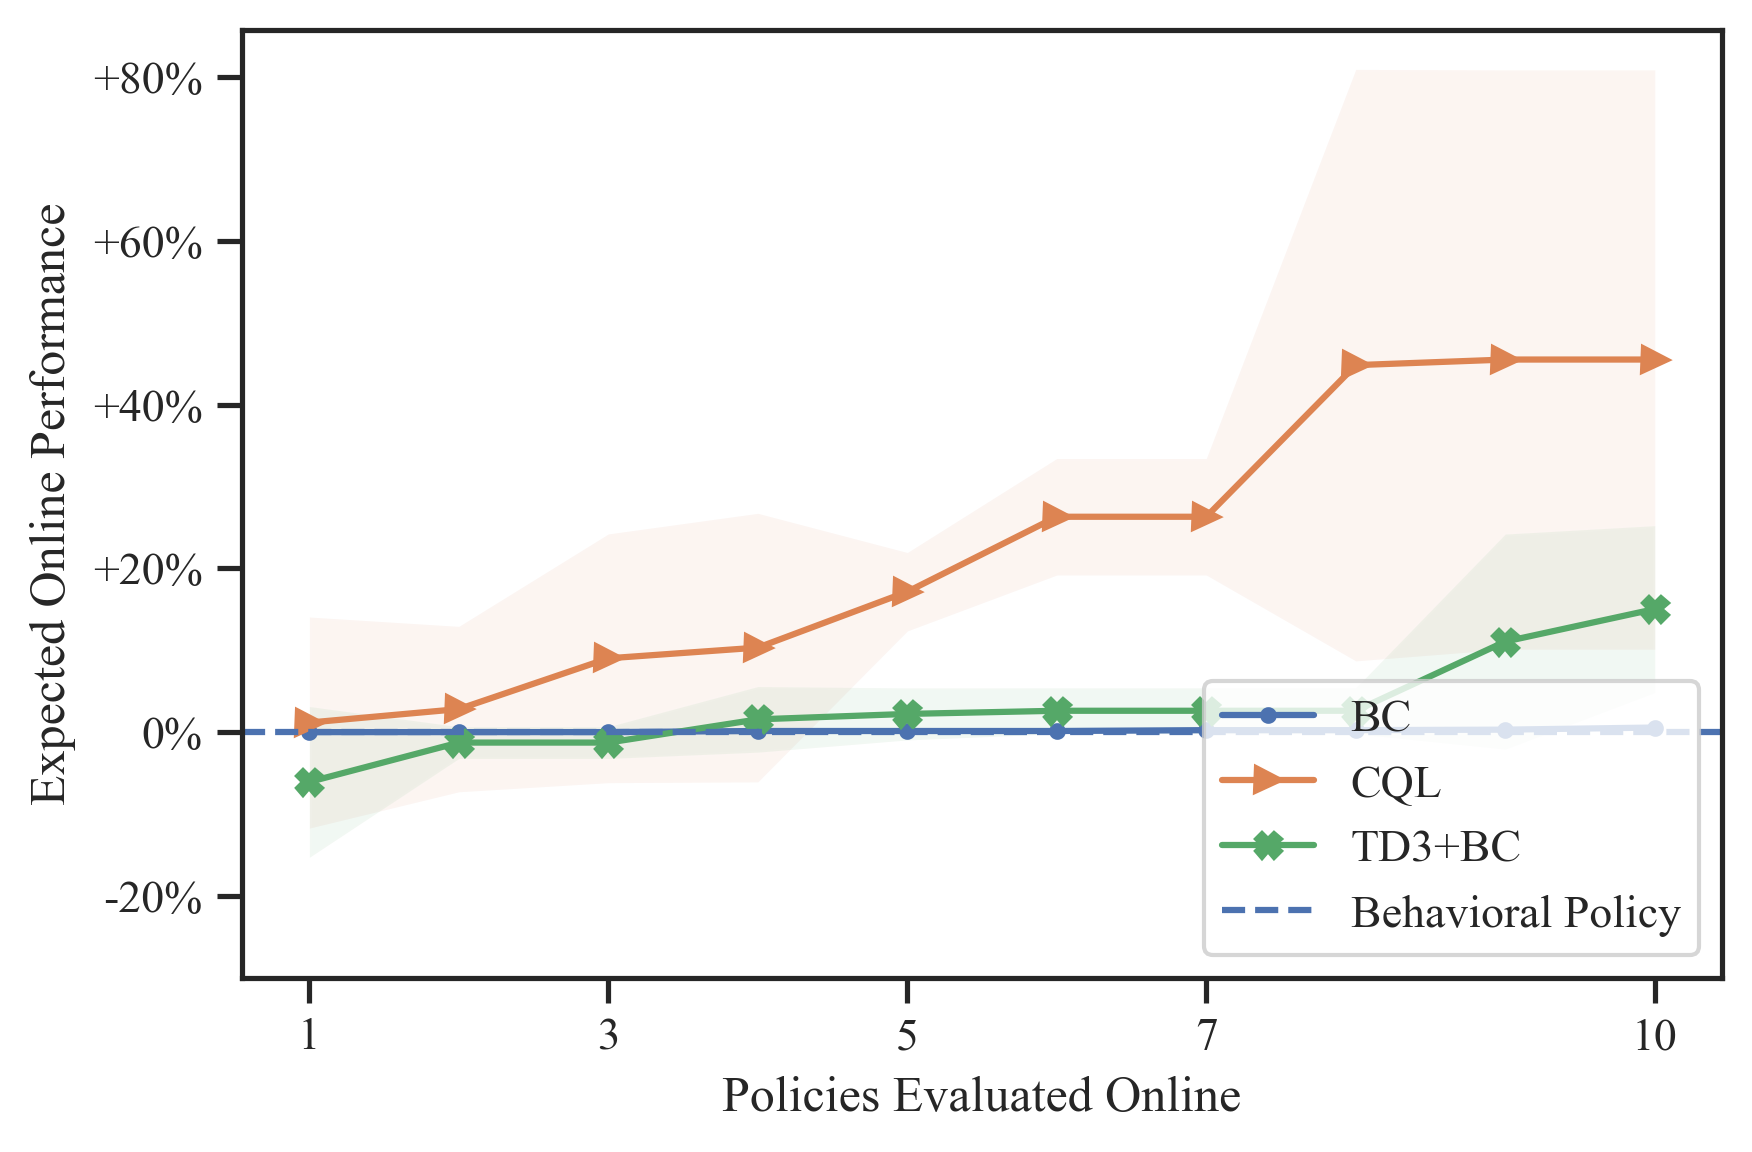

high 9999


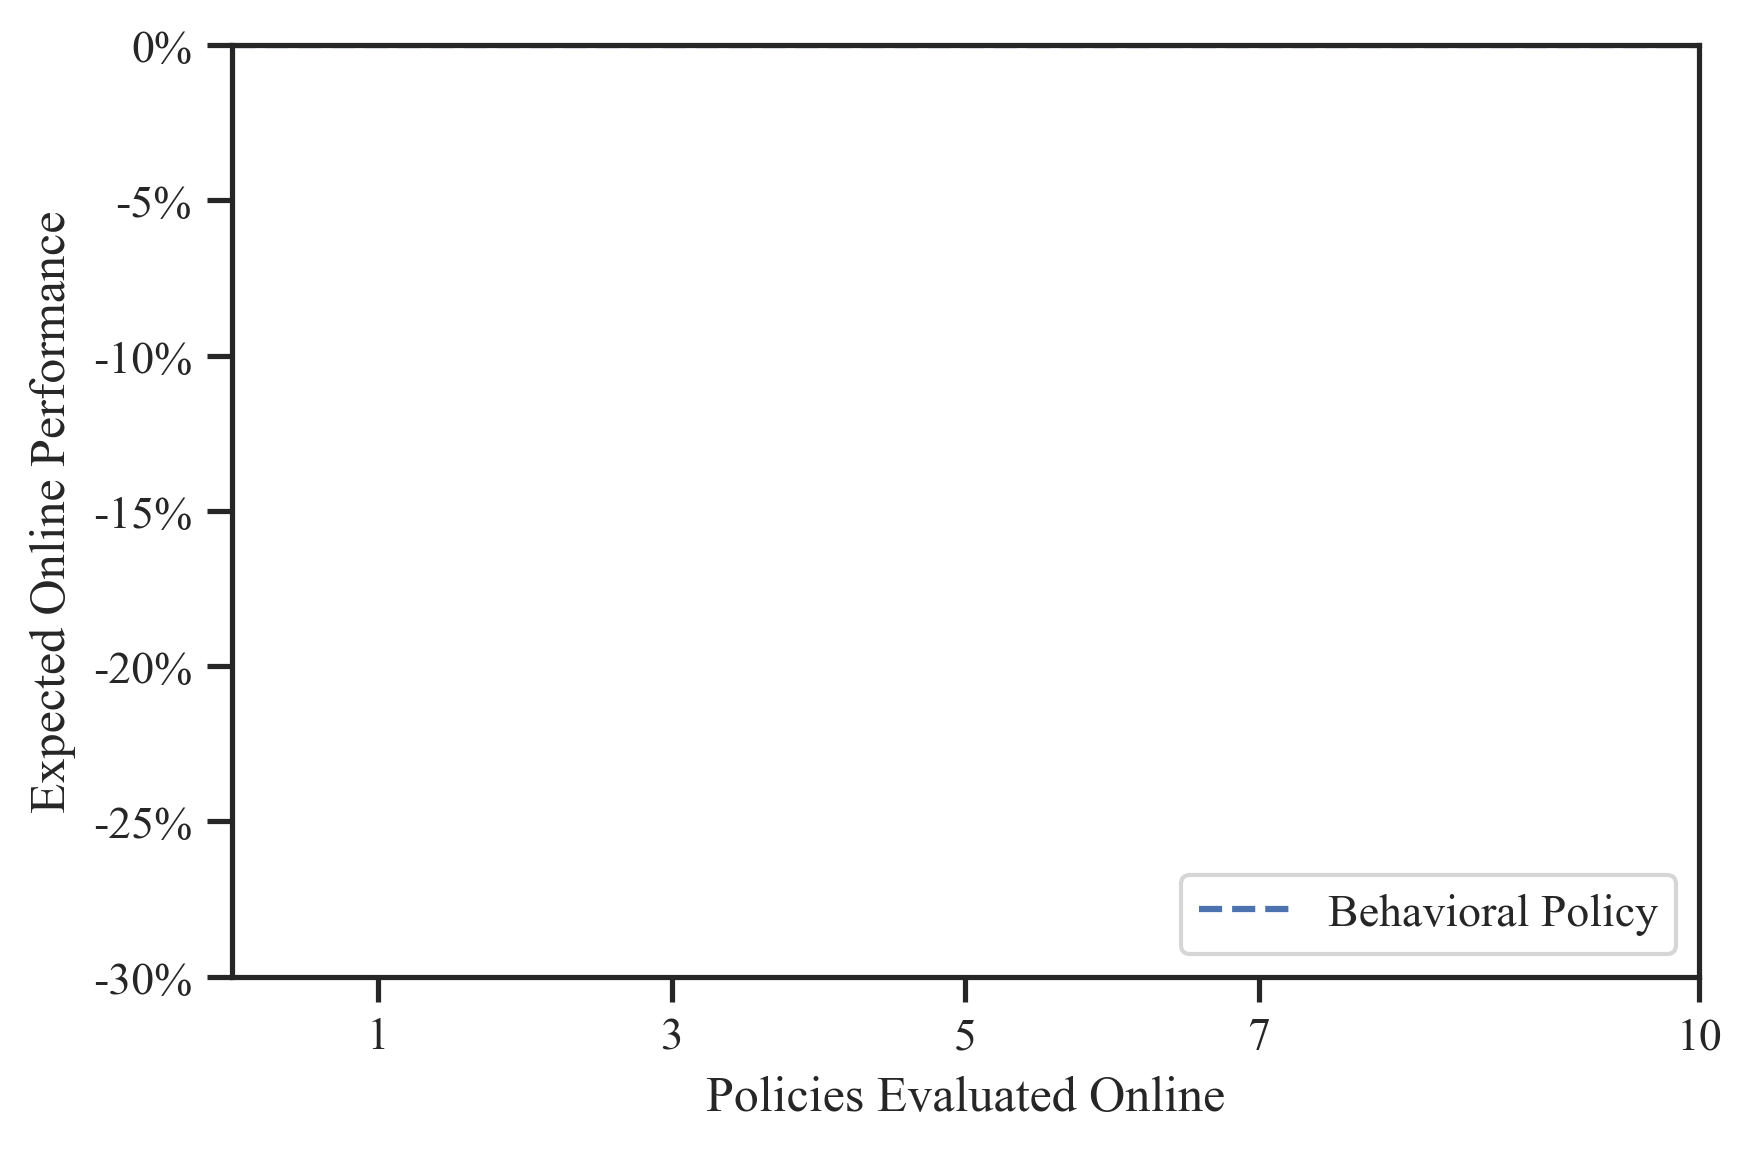

high 999


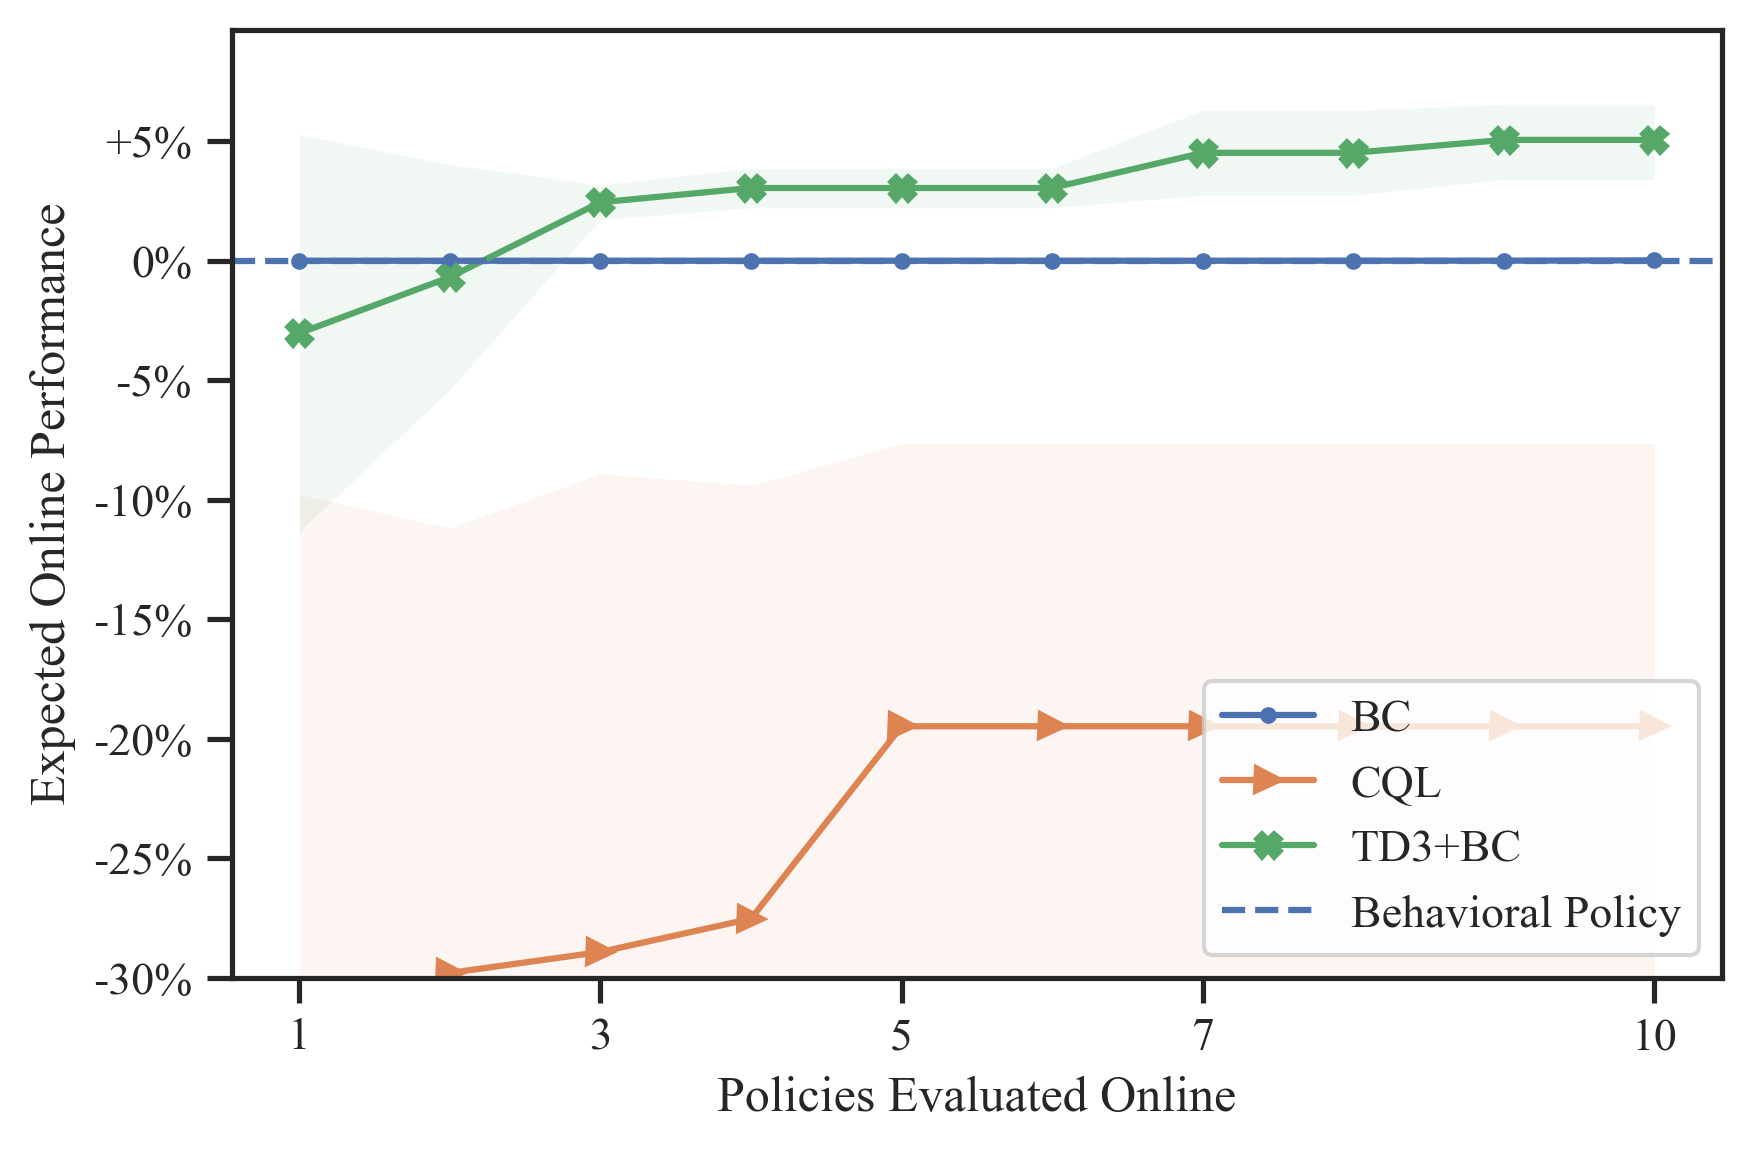

high 99


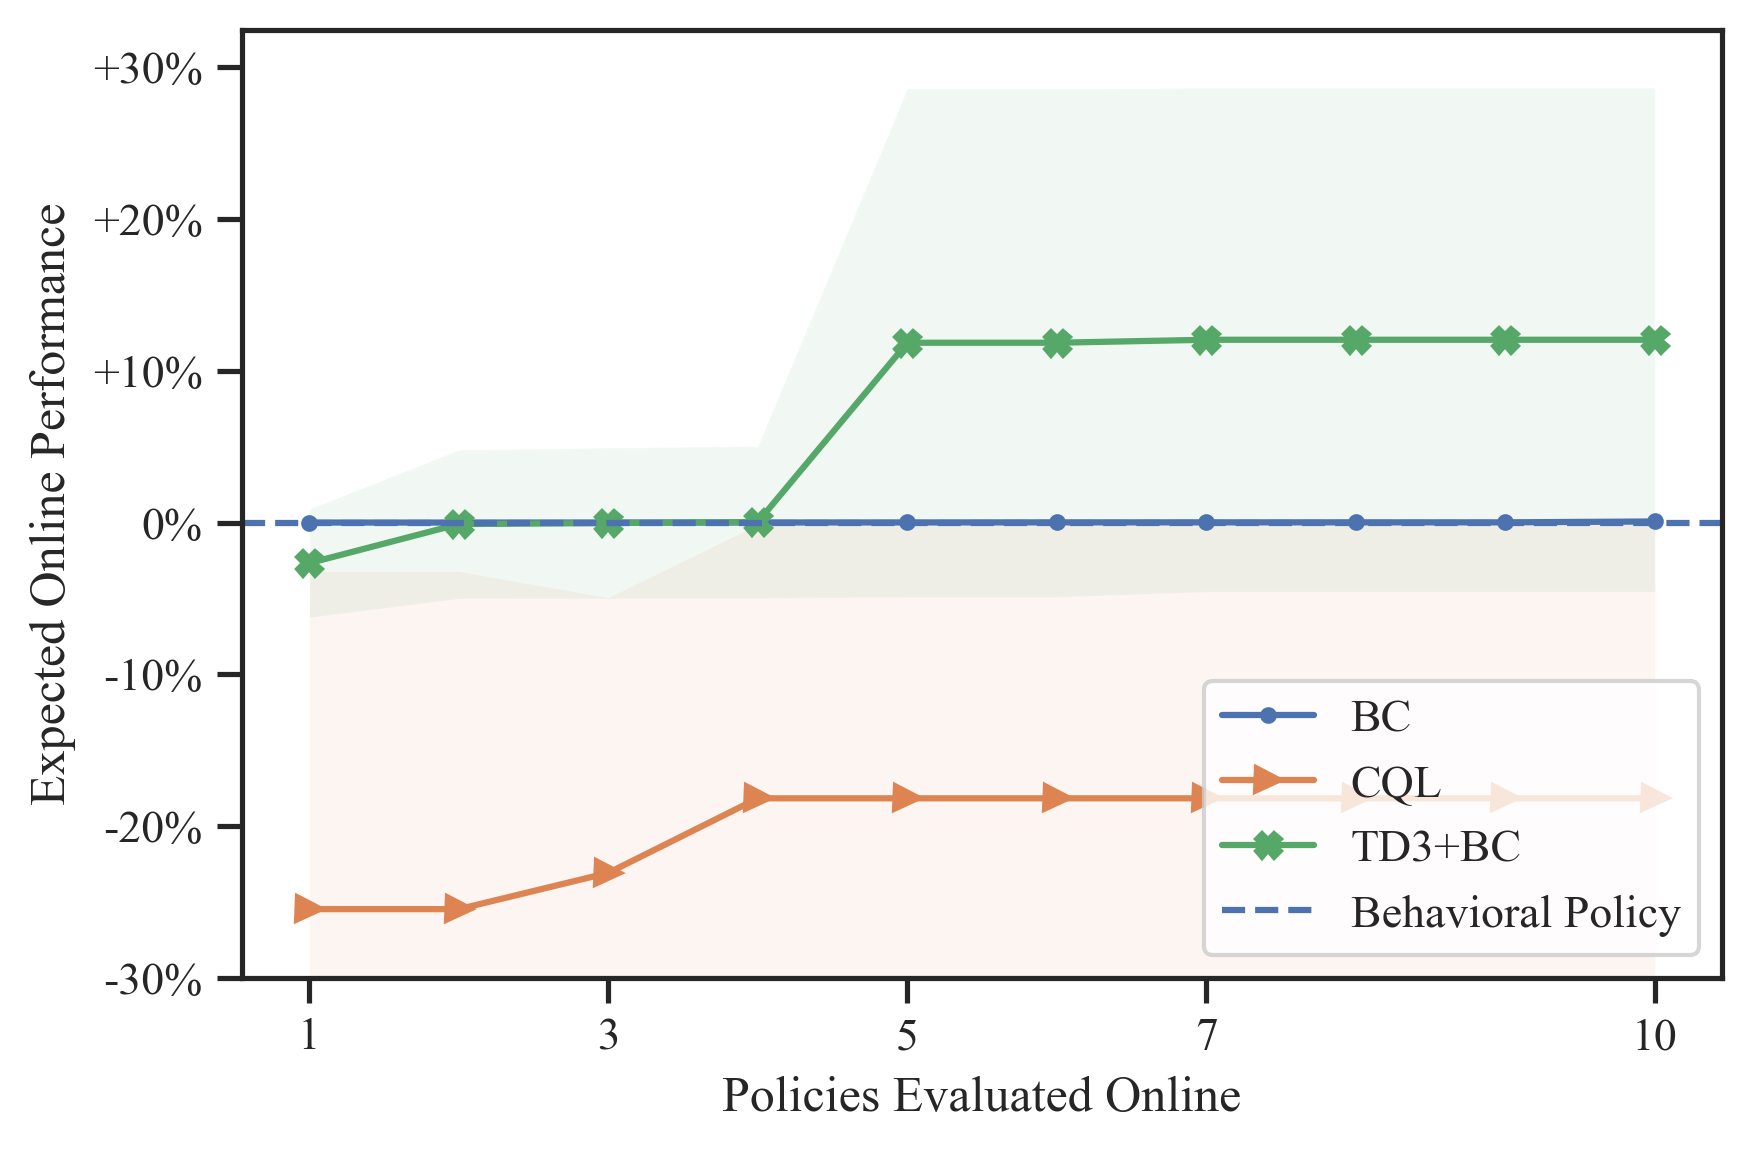

In [453]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

TARGET_TRIALS = 10
for levels, trajs in product(["low", "medium", "high"], [9999, 999, 99]):
    env = "finrl"
    cur_mask = (all_experiments.policy_level == levels) & (all_experiments.n_trajectories == trajs) & (all_experiments.ops_name == "val_loss") & (all_experiments.env == env) & (all_experiments.alg.isin(["cql", "td3+bc", "bc"]))
    explore_experiments = all_experiments[cur_mask]

    # OPS Labels
    labels = {
        "uniform": "Uniform",
        "val_vs0_q": "$V(s_{0})$ using Critic",
        "val_vs0_fqe": "$V(s_{0})$ using FQE",
        "val_tderror": "TD-Error",
        "val_loss": "Action Difference",
    }

    # Draw
    h3_grid = explore_experiments.groupby(["alg", "eop_ind"]).agg({
        "eop_mean": "mean",
        "eop_std": "mean",
        "eop_max": "max",
        "eop_min": "min"
    })
    # to set default values
    marker         = cycle(('.', '>', 'X', 'o', '*')) 
    linewidth      = 1.5
    errorbar_kind  = "shade"
    errorbar_alpha = 0.08
    fontsize       = 12

    _, cur_ax = plt.subplots(1,1)
    cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
    cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

    for n_trajectories, datapoints in h3_grid.groupby(["alg"]):
        means = datapoints["eop_mean"][:TARGET_TRIALS]
        vars  = datapoints["eop_std"][:TARGET_TRIALS]
        max_acc = max(datapoints["eop_max"])
        min_acc = min(datapoints["eop_min"])
        x_axis = [i+1 for i in range(len(means))]
        if True:
            if errorbar_kind == 'shade':
                minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
                plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
                plt.fill_between(x_axis,
                                 minus_vars,
                                 plus_vars,
                                 alpha=errorbar_alpha)
            else:
                cur_ax.errorbar(x_axis,
                                means,
                                yerr=vars,
                                linestyle=linestyle,
                                linewidth=linewidth)
    #     if n_trajectories == "uniform":
    #         linewidth = 1.5
    #         linestyle = "--"
    #     else:
    #         linewidth = 1.5
    #         linestyle = "-"
        cur_ax.plot(x_axis,
                    means,
                    marker=next(marker),
                    linewidth=linewidth,
                    label=f"{str.upper(n_trajectories)}"
                   )

    left, right = cur_ax.get_xlim()

    # Draw baseline performance
    plt.axhline(1.0, linestyle="dashed", linewidth=1.5, label="Behavioral Policy")

    # Draw x axis
    plt.xlim((left, right))
    plt.ylim(bottom=0.7)
    plt.xticks(list(range(1, TARGET_TRIALS + 1, 2))[:-1] + [10])

    # Draw y axis (improvement percent?)
    from math import floor
    def improvement_ticks(y, pos):
        improvement = floor((y - 1.0) * 100)
        if improvement > 0:
            return f"+{improvement}%"
        else:
            return f"{improvement}%"
#     plt.ylim((0.7, 1.60))
    cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

    plt.locator_params(axis='y', nbins=10)
    plt.tight_layout()
    plt.legend(loc="lower right")
    #plt.savefig(f"{env}_{trajs}_{levels}_uniform.pdf")
    print(levels, trajs)
    plt.show()

### Uniform Selection is Competitive with Other Methods

finrl cql


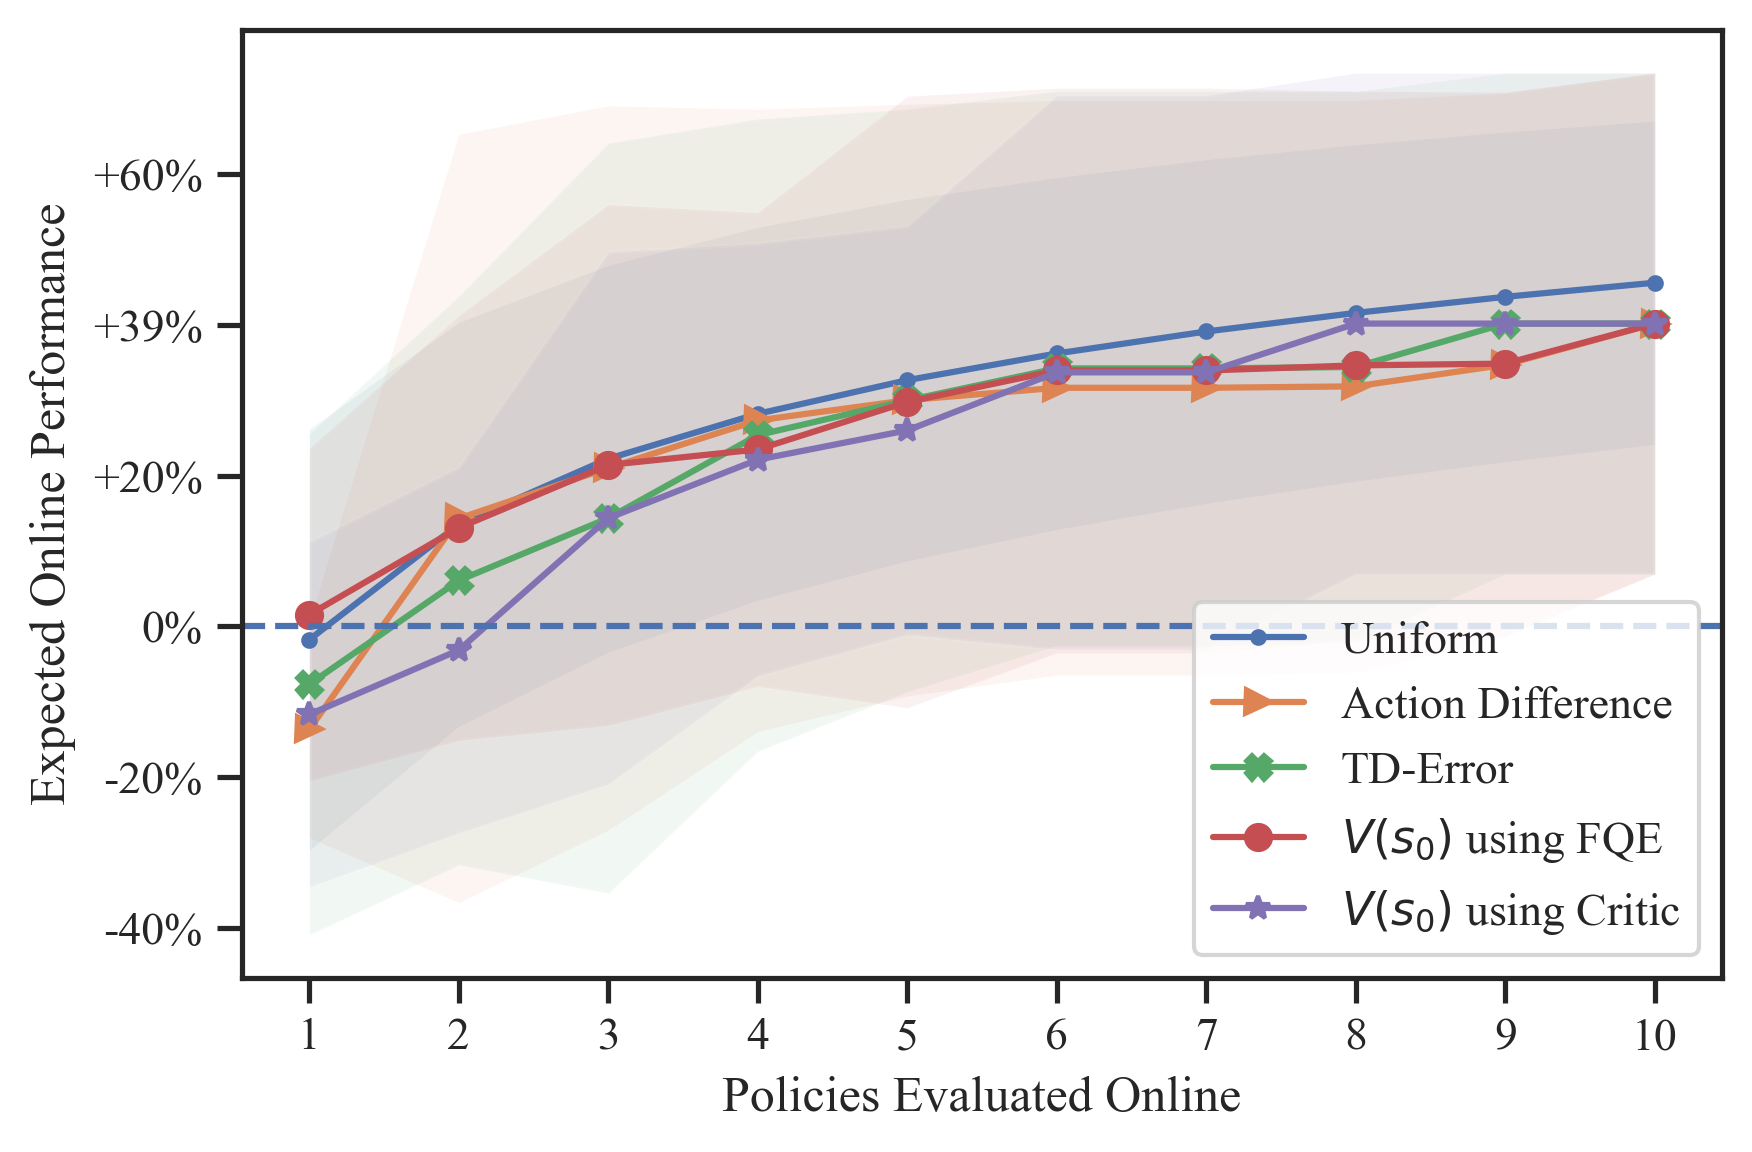

citylearn cql


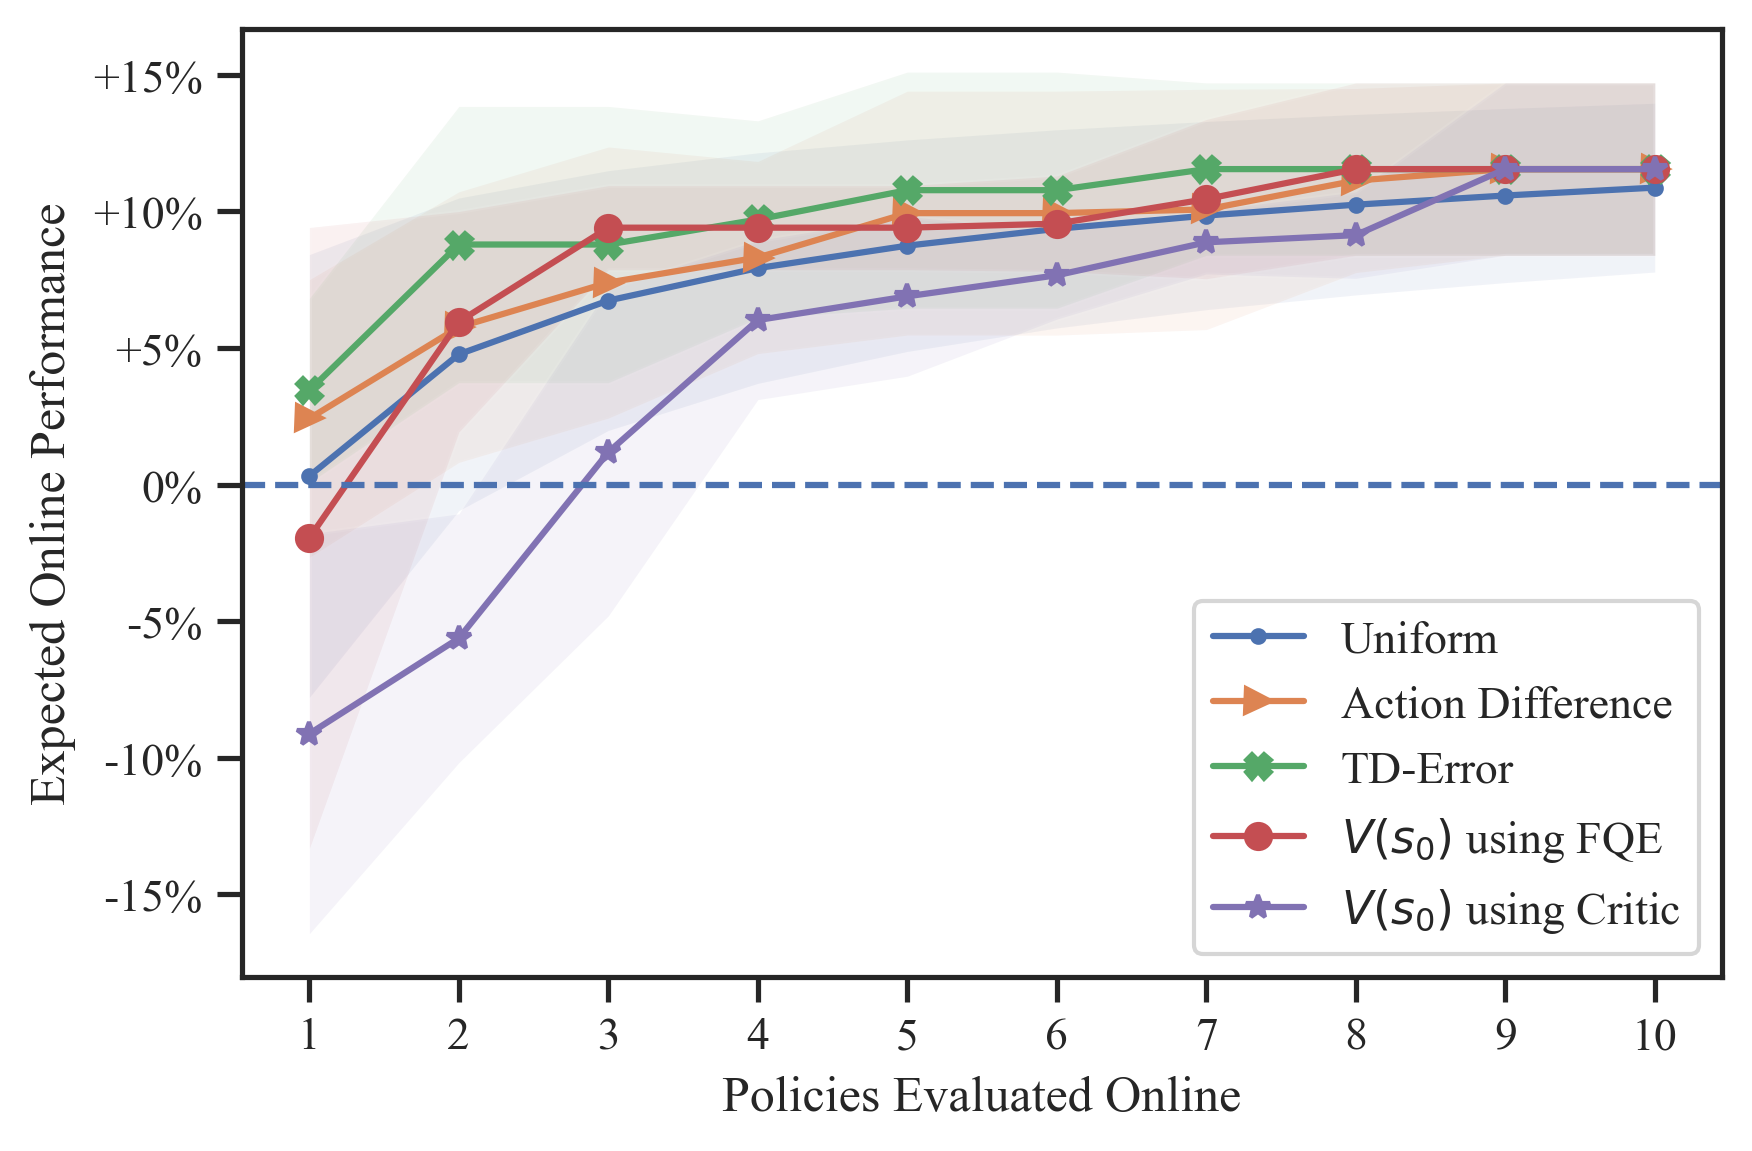

industrial cql


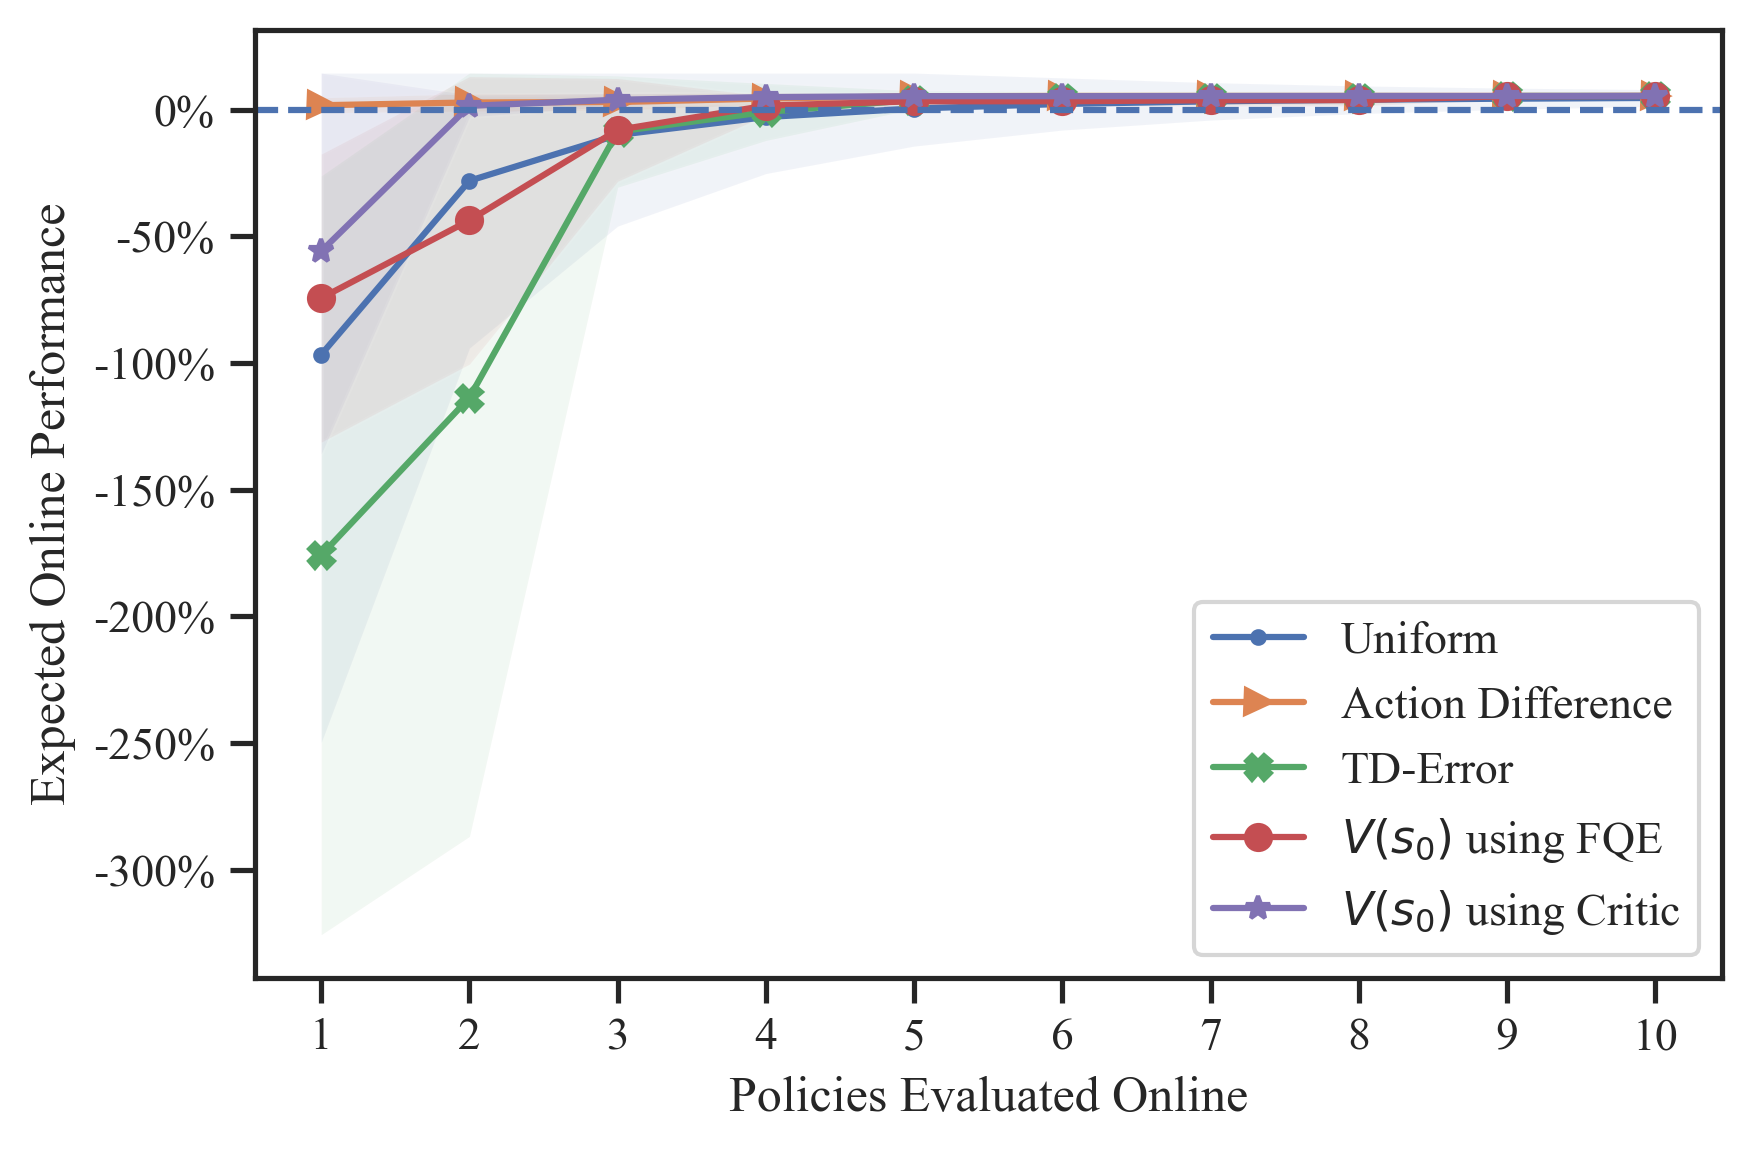

finrl td3+bc


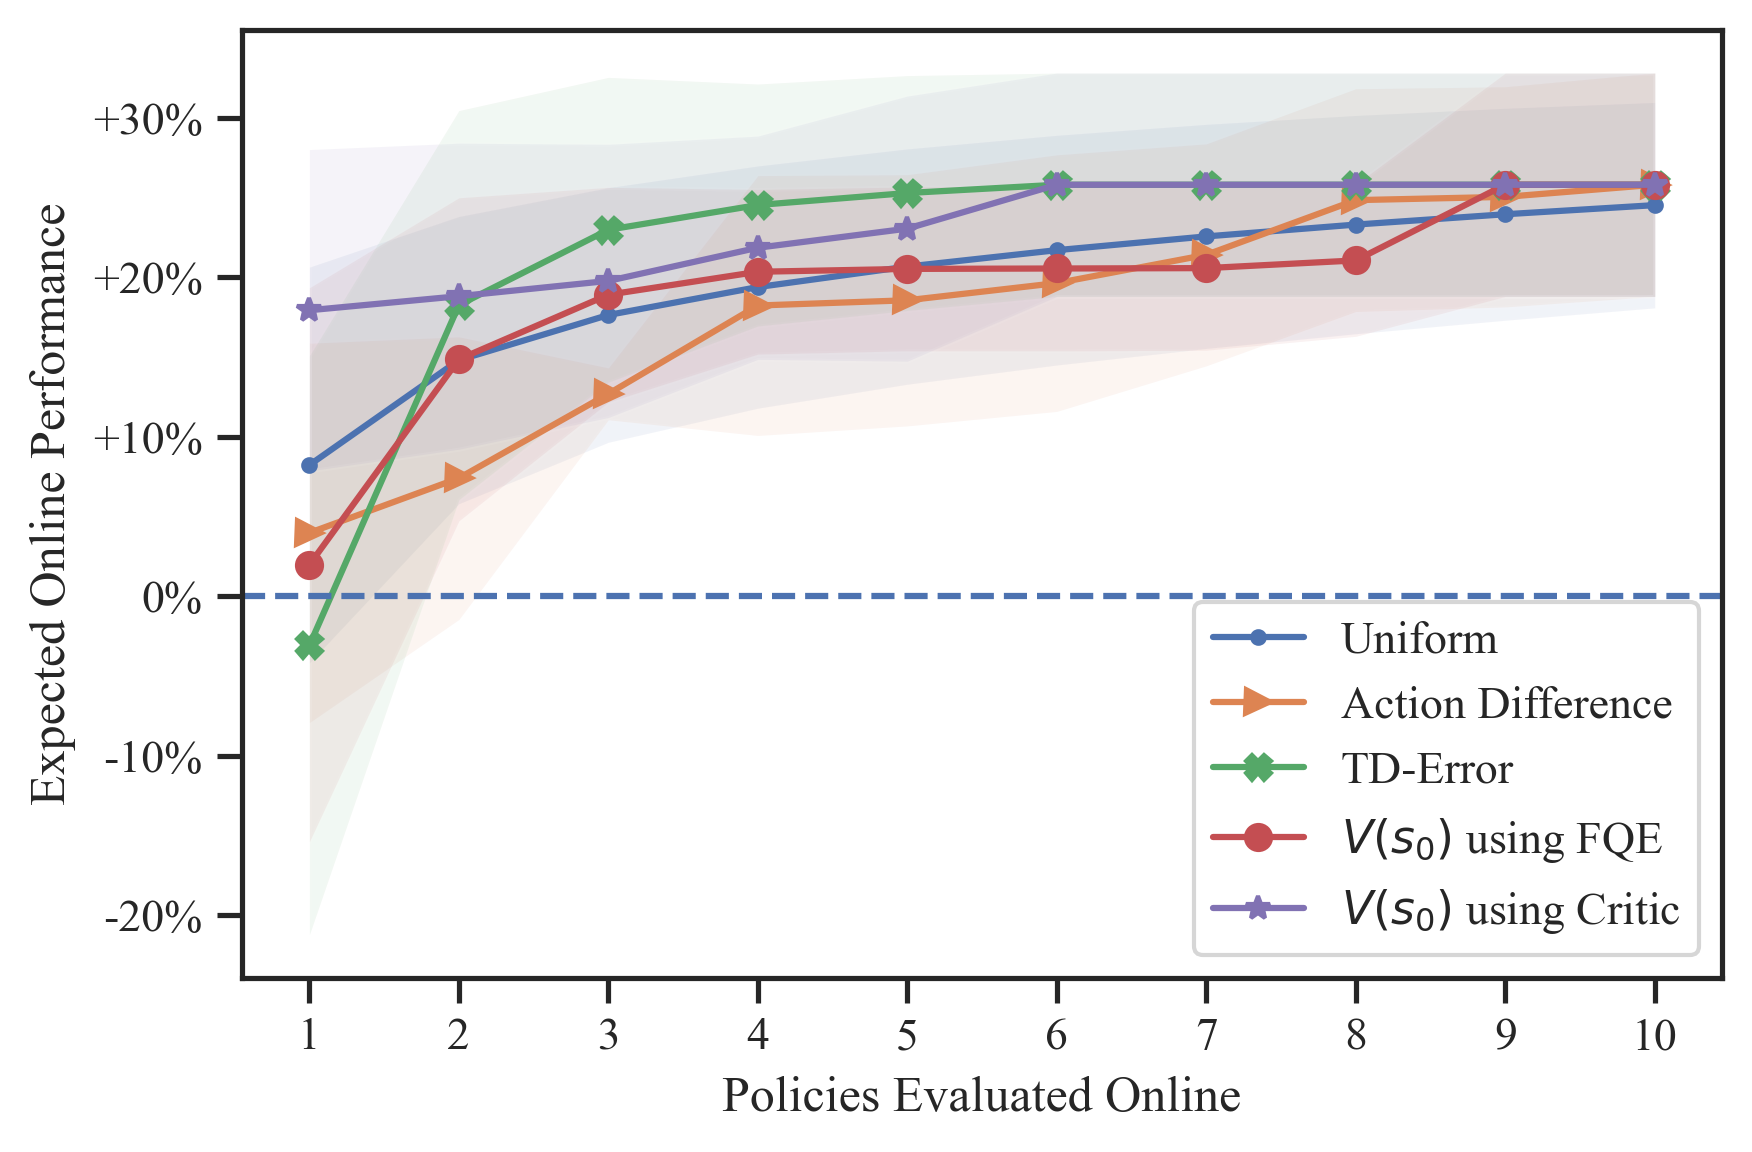

citylearn td3+bc


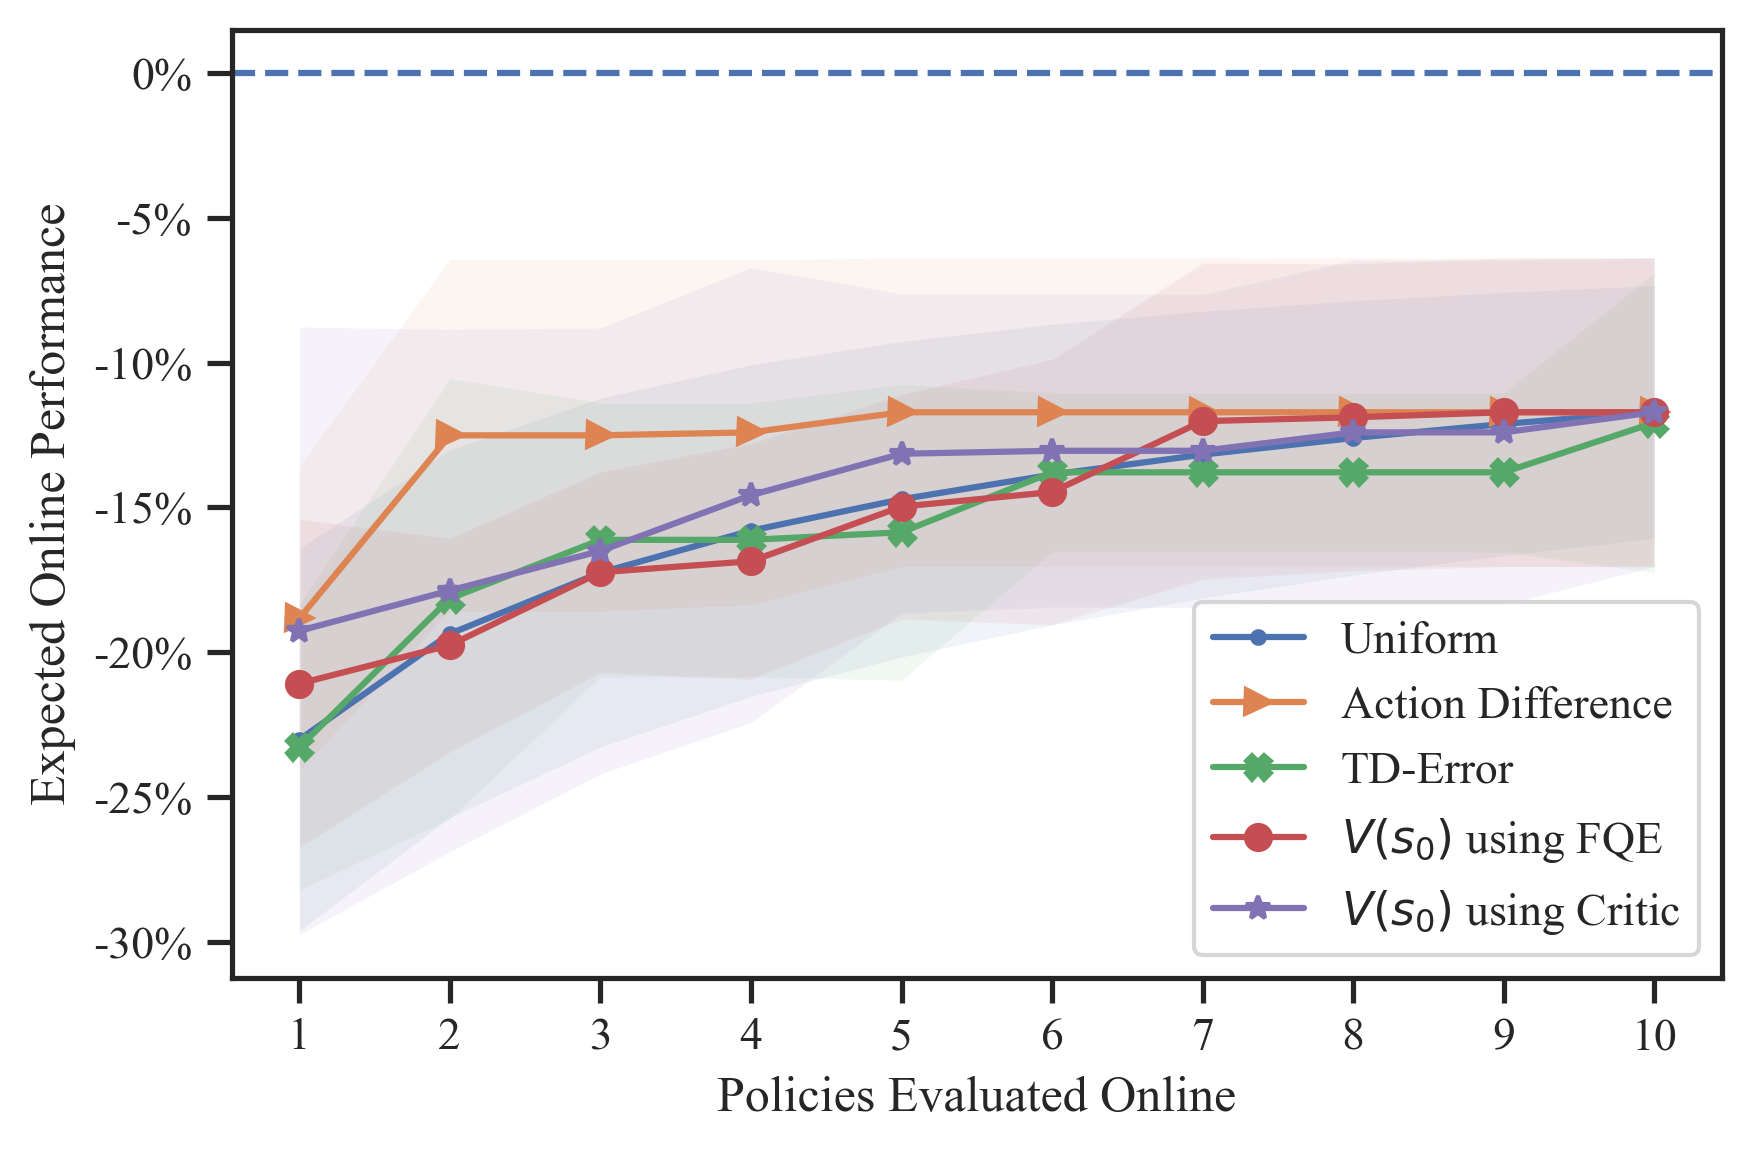

industrial td3+bc


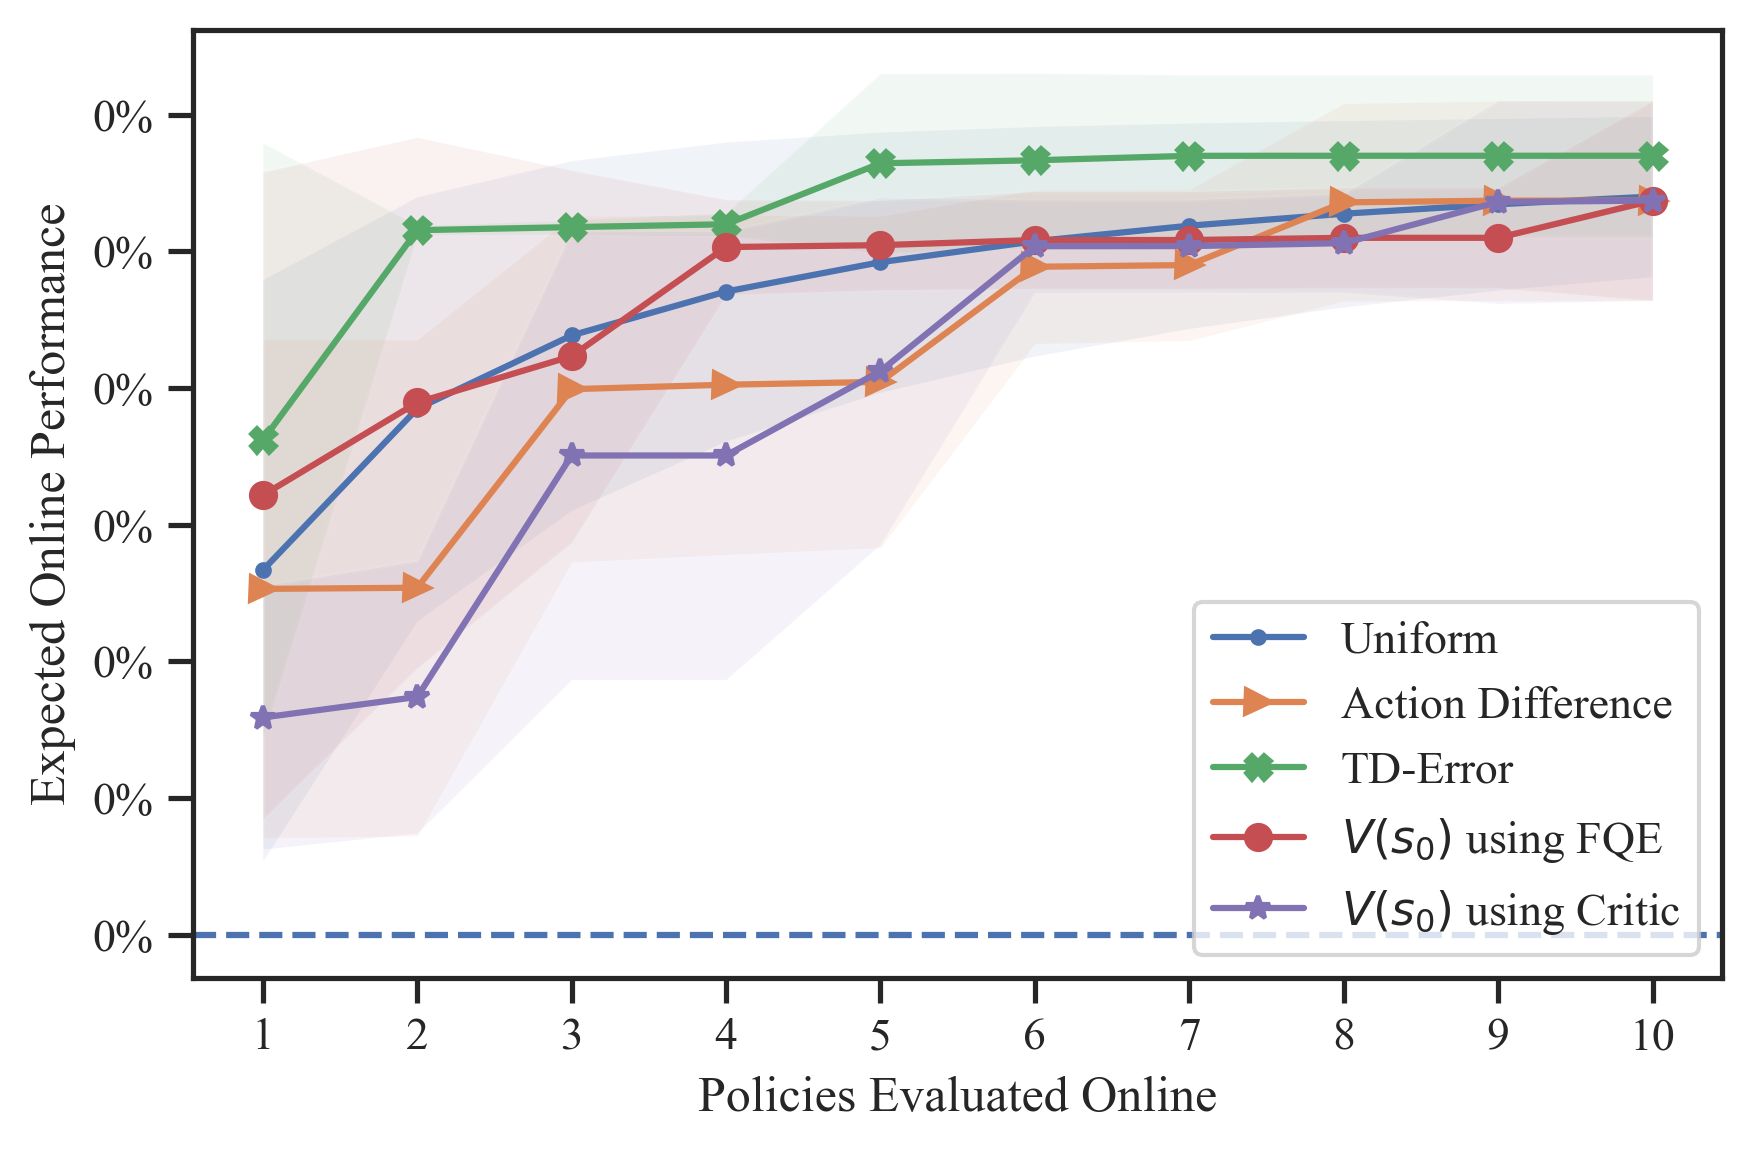

finrl bc


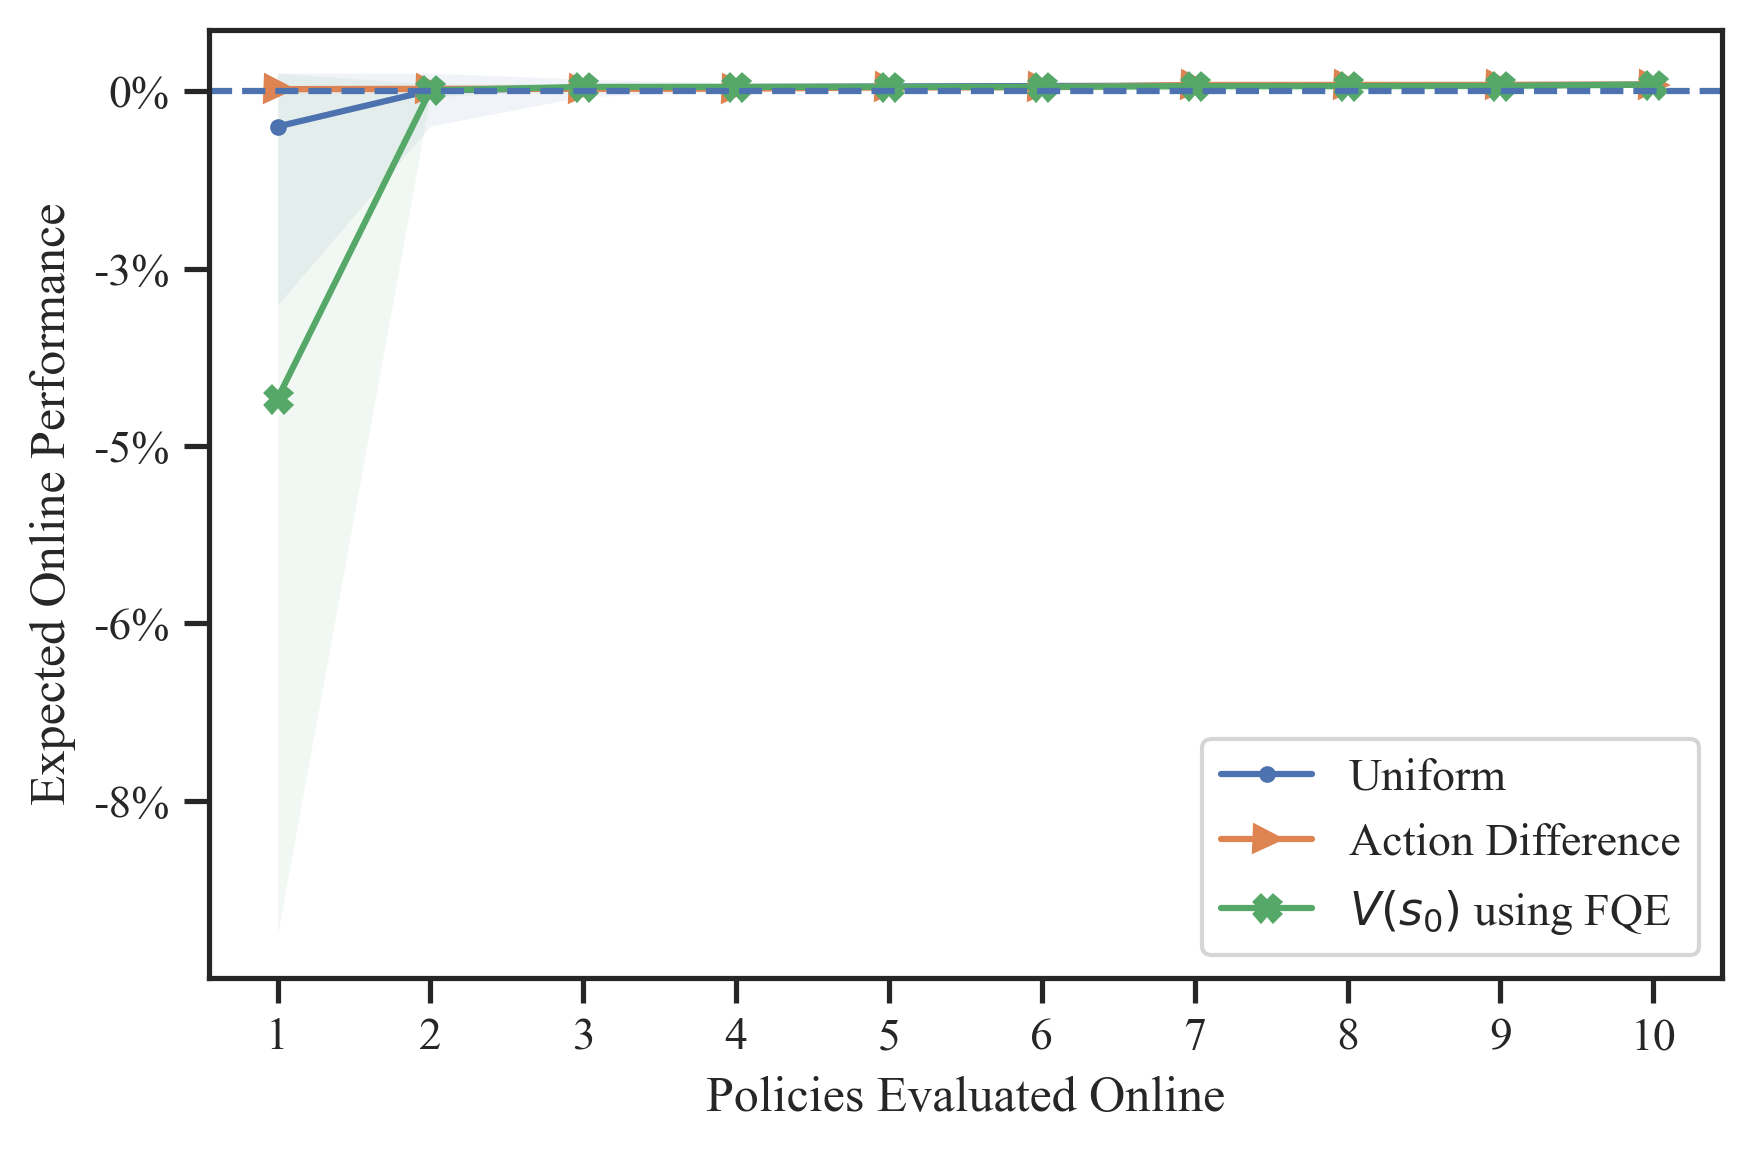

citylearn bc


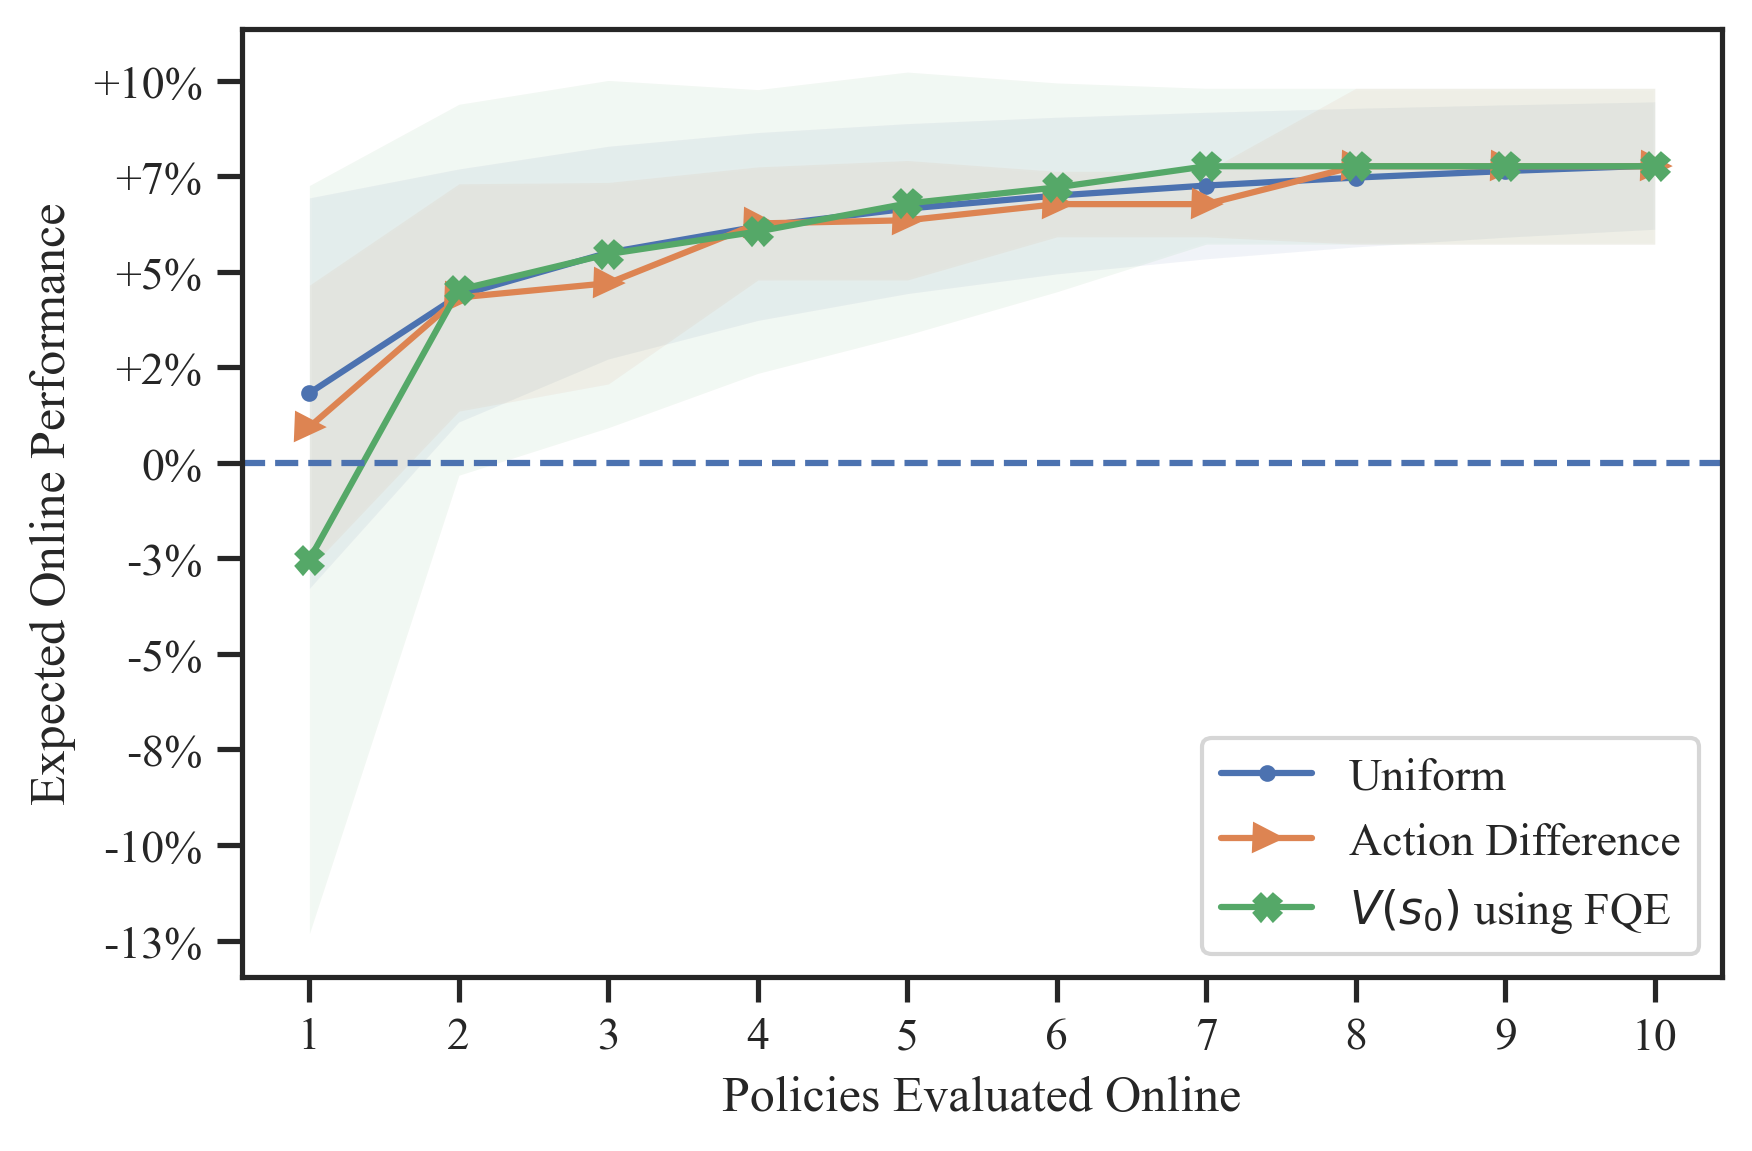

industrial bc


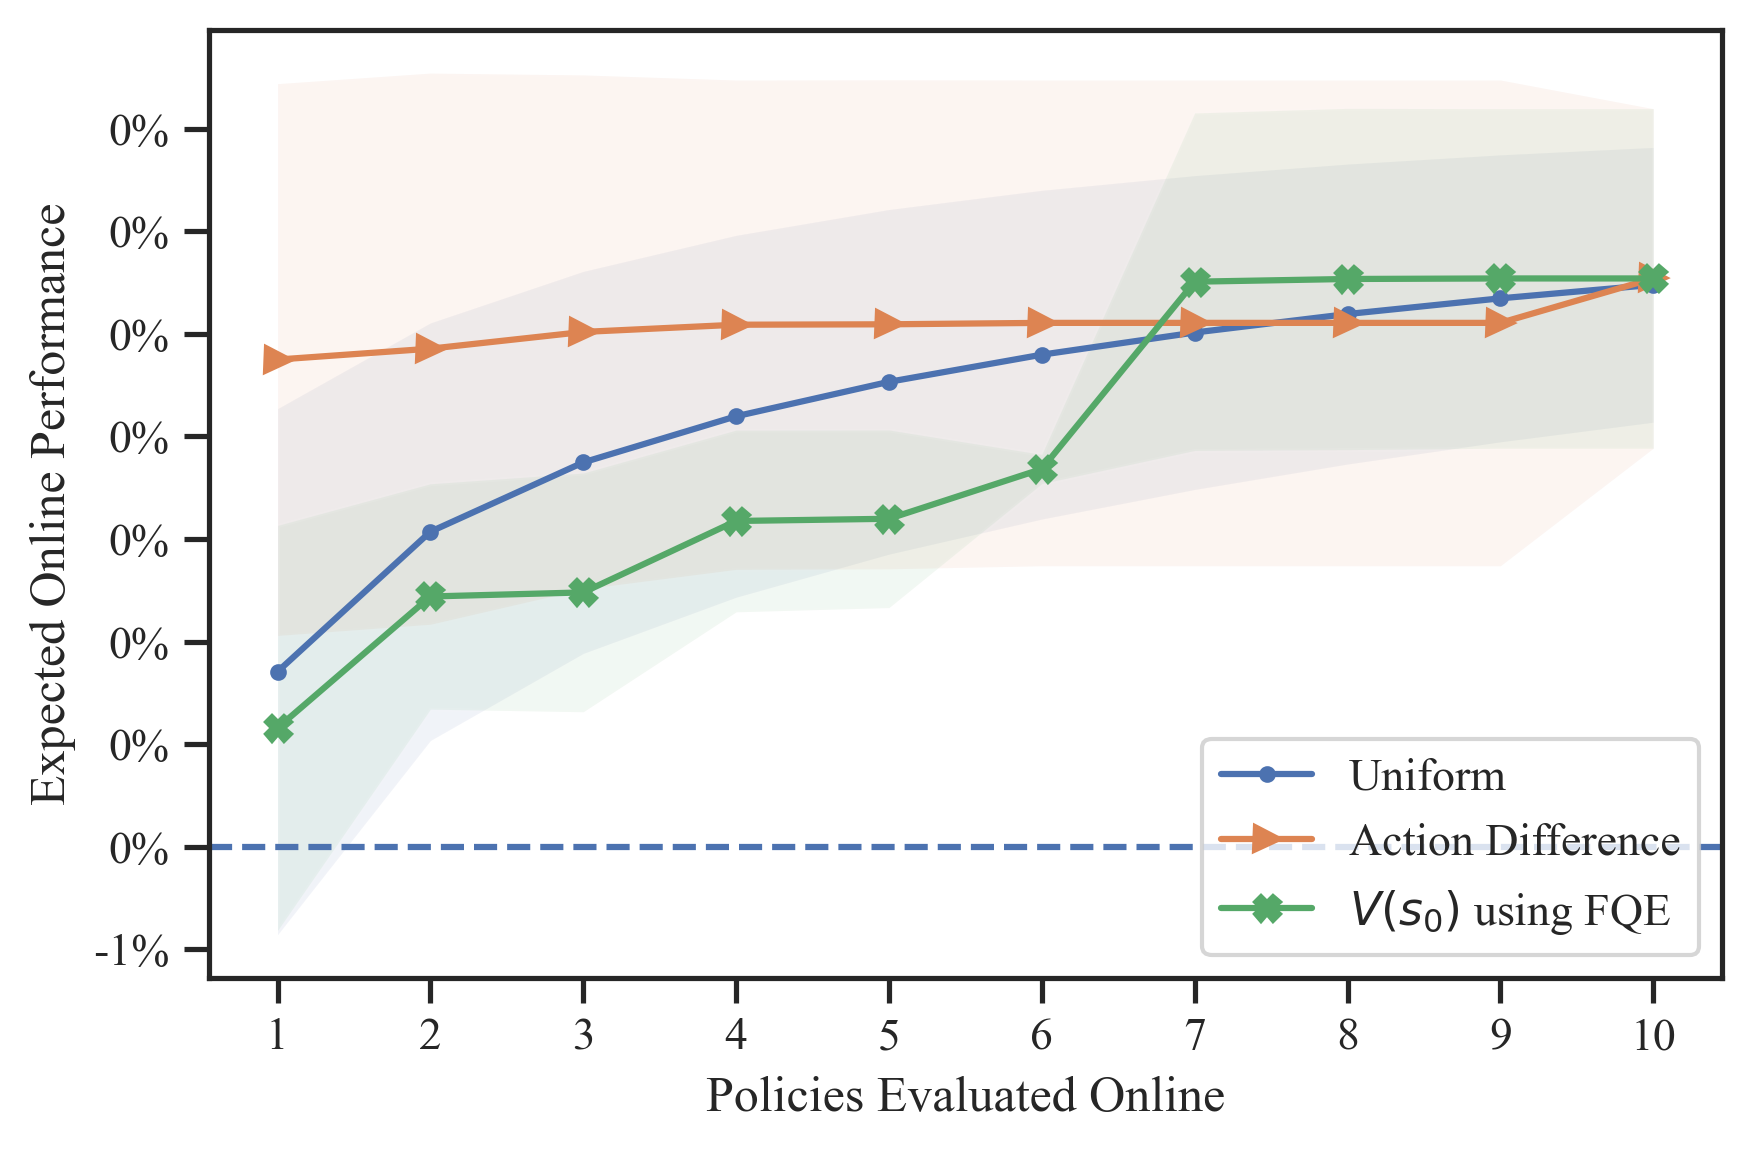

In [474]:
from eop.core import expected_online_performance
from eop.core import expected_online_performance_arbit
from itertools import product, cycle

TARGET_TRIALS = 10

for alg, env in product(["cql", "td3+bc", "bc"], ["finrl", "citylearn", "industrial"]):
    cur_mask = (all_experiments.n_trajectories == 999) & (all_experiments.env == env) & (all_experiments.alg == alg)# & (all_experiments.ops_name.isin(["uniform", "val_vs0_fqe"]))
    explore_experiments = all_experiments[cur_mask]

    # OPS Labels
    labels = {
        "uniform": "Uniform",
        "val_vs0_q": "$V(s_{0})$ using Critic",
        "val_vs0_fqe": "$V(s_{0})$ using FQE",
        "val_tderror": "TD-Error",
        "val_loss": "Action Difference",
    }

    # Draw
    h3_grid = explore_experiments.groupby(["ops_name", "eop_ind"]).agg({
        "eop_mean": "mean",
        "eop_std": "mean",
        "eop_max": "max",
        "eop_min": "min"
    })
    # to set default values
    marker         = cycle(('.', '>', 'X', 'o', '*')) 
    linewidth      = 1.5
    errorbar_kind  = "shade"
    errorbar_alpha = 0.08
    fontsize       = 12

    _, cur_ax = plt.subplots(1,1)
    cur_ax.set_ylabel("Expected Online Performance", fontsize=fontsize)
    cur_ax.set_xlabel("Policies Evaluated Online", fontsize=fontsize)

    for n_trajectories, datapoints in h3_grid.groupby(["ops_name"]):
        means = datapoints["eop_mean"][:TARGET_TRIALS]
        vars  = datapoints["eop_std"][:TARGET_TRIALS]
        max_acc = max(datapoints["eop_max"])
        min_acc = min(datapoints["eop_min"])
        x_axis = [i+1 for i in range(len(means))]
        if True:
            if errorbar_kind == 'shade':
                minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
                plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
                plt.fill_between(x_axis,
                                 minus_vars,
                                 plus_vars,
                                 alpha=errorbar_alpha)
            else:
                cur_ax.errorbar(x_axis,
                                means,
                                yerr=vars,
                                linestyle=linestyle,
                                linewidth=linewidth)
    #     if n_trajectories == "uniform":
    #         linewidth = 1.5
    #         linestyle = "--"
    #     else:
    #         linewidth = 1.5
    #         linestyle = "-"
        cur_ax.plot(x_axis,
                    means,
                    marker=next(marker),
                    linewidth=linewidth,
                    label=labels[n_trajectories]
                   )

    left, right = cur_ax.get_xlim()

    # Draw baseline performance
    plt.axhline(1.0, linestyle="dashed", linewidth=1.5)

    # Draw x axis
    plt.xlim((left, right))
    plt.xticks(list(range(1, TARGET_TRIALS + 1, 1)))

    # Draw y axis (improvement percent?)
    from math import floor
    def improvement_ticks(y, pos):
        improvement = floor((y - 1.0) * 100)
        if improvement > 0:
            return f"+{improvement}%"
        else:
            return f"{improvement}%"
#     plt.ylim((0.7, 1.60))
    cur_ax.yaxis.set_major_formatter(mticker.FuncFormatter(improvement_ticks))

    plt.locator_params(axis='y', nbins=10)
    plt.tight_layout()
    plt.legend(loc="lower right")
#     plt.savefig(f"ops_{alg}_{env}.pdf")
    print(env, alg)
    plt.show()